In [1]:
from IPython.display import HTML
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

In [54]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [53]:
def evaluate_ets(npa_):
    train,test,model_func,flag_ = npa_
    
    try:
        if(len(flag)==2):
            if(flag[1] is None):
                model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],trend=flag[1],dates=train.index).fit()
            else:
                model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],dates=train.index).fit()
        else:
            model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],damped_trend=flag[2],dates=train.index).fit()

        fc_ets_ = np.exp(model.get_prediction(start=test.index[0],end=test.index[-1]).summary_frame())
        rmse_ = mean_squared_error(test, fc_ets_['mean'], squared=True)
    except:
        #not enough data points
        rmse_ = np.nan
    
    return([flag,rmse_])

In [2]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total

def myfunc(x):
    return slope * x + intercept

In [3]:
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if val >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)

In [4]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [5]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [6]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [7]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [8]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [9]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [10]:
stock_fundamentals = market_data
screener = screener_sorted
fundamentals = stock_fundamentals
stock_indexes = sp1500_index_df

spdr_indexes = indexes
spdr_indexes.columns=['Symbol']
vanguard_sectors = sectors
vanguard_sectors.columns=['Symbol']

In [11]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]:
    subset = prices[prices['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [12]:
sector_performance_Q_smoothed_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
sector_performance_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]

Seasonal Indexes


Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison
Current


standard deviations


03-31     06-30     09-30     12-31
SP1500                      0.134644  0.072380  0.037999  0.110320
SP500                       0.127411  0.070450  0.039033  0.106496
SP600                       0.199479  0.088447  0.037096  0.179394
SP400                       0.157662  0.100224  0.037075  0.138781
Communication Services ETF  0.138244  0.095192  0.045269  0.123434
Consumer Discretionary ETF  0.151791  0.146922  0.083611  0.127243
Consumer Staples ETF        0.096633  0.035421  0.049261  0.063730
Energy ETF                  0.369457  0.166709  0.099129  0.202483
Financials ETF              0.192299  0.053666  0.014462  0.140299
Health Care ETF             0.079810  0.054107  0.065798  0.098650
Industrials ETF             0.178470  0.072339  0.066050  0.134044
Information Technology ETF  0.135329  0.113409  0.054569  0.136753
Materials ETF               0.163483  0.099766  0.065317  0.127072
Real Estate ETF             0.161483  0.056090  0.032025  0.078165
Utilities ETF               0.092016  0.021473  0.033841  0.054883

t scores


03-31     06-30     09-30     12-31
SP1500                     -0.035281  0.505153  0.489908  0.202519
SP500                      -0.042087  0.512730  0.522980  0.210329
SP600                      -0.039834  0.407076  0.230960  0.144515
SP400                      -0.056330  0.357747  0.247928  0.166115
Communication Services ETF -0.106341  0.357027  0.223180  0.064848
Consumer Discretionary ETF -0.062503  0.366041  0.280865  0.185493
Consumer Staples ETF       -0.086371  0.447954  0.315992  0.322196
Energy ETF                  0.067680  0.258283 -0.179260  0.093682
Financials ETF             -0.048166  0.508740  0.933164  0.208614
Health Care ETF            -0.100433  0.650529  0.278976  0.215182
Industrials ETF            -0.027615  0.360421  0.307577  0.133187
Information Technology ETF  0.020546  0.480423  0.562966  0.220841
Materials ETF              -0.072960  0.371283  0.191302  0.206478
Real Estate ETF            -0.073157  0.604012  0.271246  0.220111
Utilities ETF              -0.006140  0.544116  0.518265  0.342246

p values


array([[<AxesSubplot:title={'center':'03-31'}>,
        <AxesSubplot:title={'center':'06-30'}>],
       [<AxesSubplot:title={'center':'09-30'}>,
        <AxesSubplot:title={'center':'12-31'}>]], dtype=object)

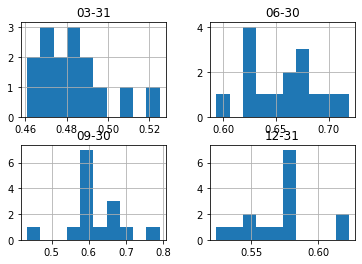

In [13]:
from scipy import stats as st
from scipy.stats import t

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

warnings.filterwarnings('ignore')
for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]*np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()

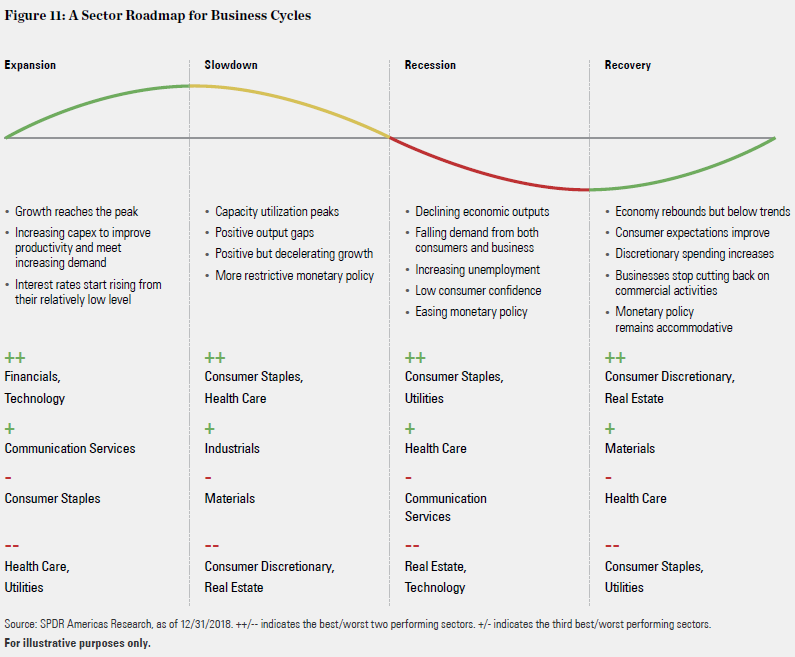

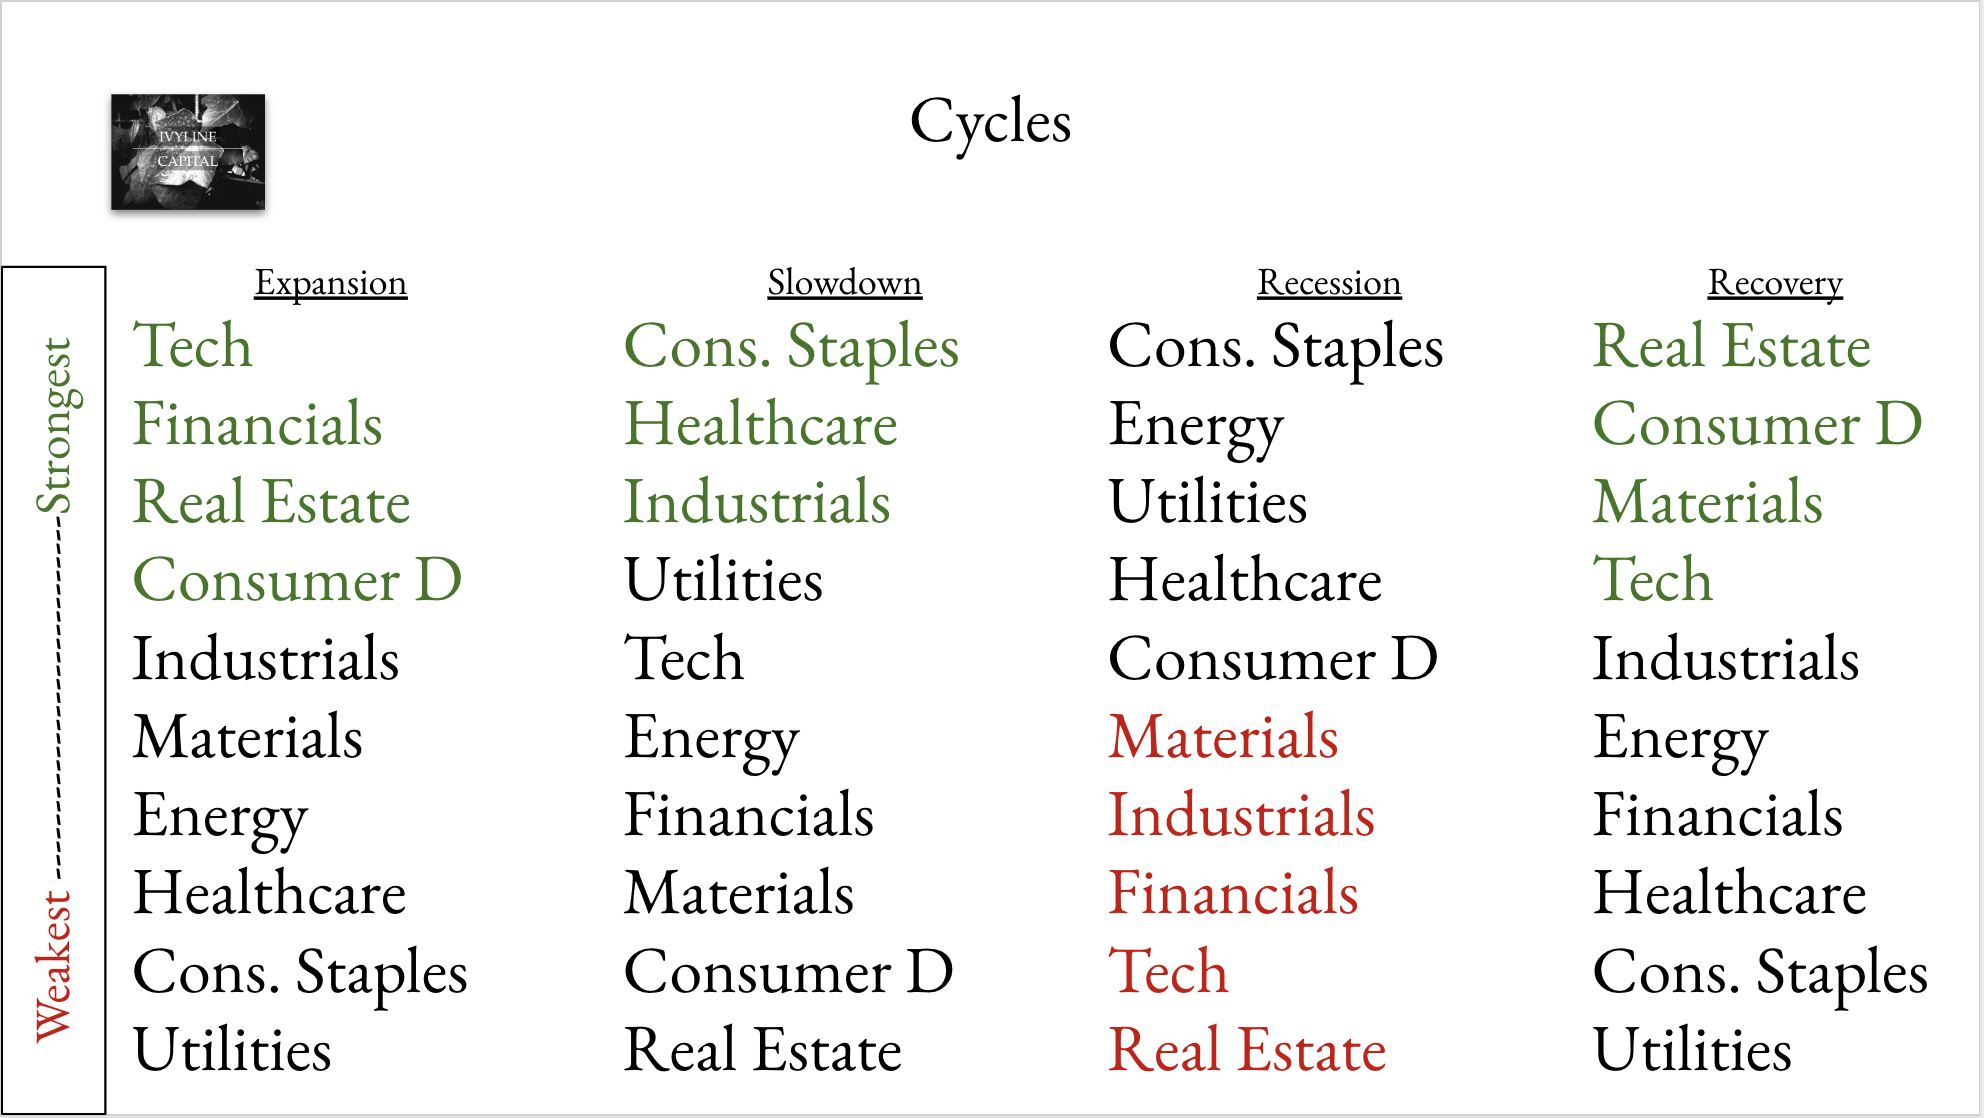

In [14]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))
path=r"C:\Users\User\Documents\wiki\wiki\Finance\Business Cycles-2.png"
display(Image.open(path))

In [15]:
sector_performance_return_pvt = sector_performance_return[sector_performance_return.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_return.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performances

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


In [16]:
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)

Comparative to Seasonal Indexes, tells you who is over or underperforming.
This is Seasonal Index - Extrapolated Current Quarter.
+: seasonal > current
-: current > seasonal
Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison


In [17]:
index_performance = []
for v in spdr_indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=spdr_indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=spdr_indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted

Index Symbol  risk_trend_factor
0   SP500    SPY          -3.791861
1  SP1500   SPTM          -3.879022
2   SP400   MDYG          -5.134573
3   SP600    SLY          -5.242200

In [18]:
sector_performance = []
for v in vanguard_sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = vanguard_sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted

Symbol  risk_trend_factor                      Sector
3     VDE          -0.123306                  Energy ETF
2     VDC          -2.283970        Consumer Staples ETF
10    VPU          -2.520459               Utilities ETF
9     VNQ          -3.053370             Real Estate ETF
8     VAW          -3.165271               Materials ETF
5     VHT          -3.323632             Health Care ETF
6     VIS          -4.514668             Industrials ETF
4     VFH          -4.617891              Financials ETF
1     VCR          -4.721407  Consumer Discretionary ETF
7     VGT          -4.954472  Information Technology ETF
0     VOX          -8.783598  Communication Services ETF

Rolling Quarterly Mean Return


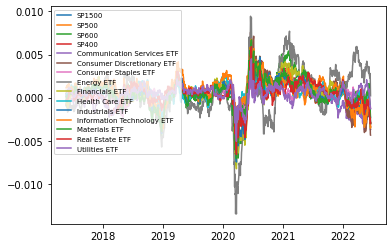

In [19]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


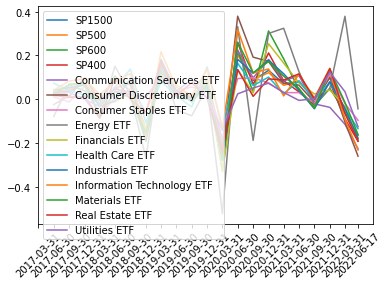

In [20]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


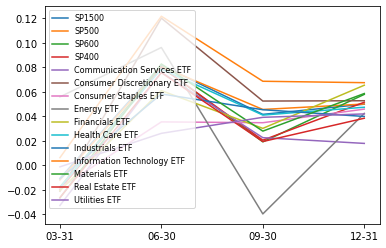

In [21]:
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()

In [22]:
threshold = .975

In [23]:
screener_sorted_ = screener_sorted.reset_index().merge(stock_indexes,on='Symbol',how='left')

screener_good = screener_sorted_[screener_sorted_['risk_trend_factor']!='missing']

risk_trend_threshold = screener_good['risk_trend_factor'].quantile(q=[threshold]).values[0]


In [24]:
risk_trend_threshold

0.051078501531639196

In [25]:
stock_sectors = stock_fundamentals['sector']

In [26]:
temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener[['risk_trend_factor']].merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']
temp_sm = temp_sm.merge(spdr_indexes.reset_index(), on='index', how='left')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index','index_Symbol']
temp_sm.index = sector_merged['Symbol']

for spdr_ in range(0,len(spdr_indexes['Symbol'].values)):
    spdr__ = spdr_indexes['Symbol'].values[spdr_]
    spdr__i = spdr_indexes['Symbol'].index[spdr_]
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__

array([[<AxesSubplot:title={'center':'risk_trend_factor'}>]], dtype=object)

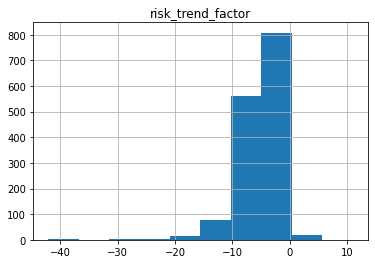

In [27]:
screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [28]:
len(screener)

1520

In [29]:
prices_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Symbol',
       'trailing_1yr_max', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'trailing_1yr_min', 'supply_trend_1yr',
       'supply_trend_60d', 'supply_trend_30d', 'trailing_60d_max',
       'trailing_60d_min', 'trailing_30d_max', 'trailing_30d_min', '90dSMA',
       '90dSDev', 'TP', '21dstdTP', '21dMA-TP', '21dBOLU', '21dBOLD',
       'trailing_risk_40d_max', 'trailing_risk_40d_min', 'risk_per_share',
       '30d_vol', '30d_vol_2yr', 'volume_factor', '1YMF', 'risk_trend_factor'],
      dtype='object')

In [30]:
risk_screened = screener_good[(screener_good['risk_trend_factor']>risk_trend_threshold) & (screener_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
temp_df = risk_screened[['Symbol','latest_p','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','volume_factor','adf','hurst','Sector','Market Index']]
temp_df.set_index('Symbol',inplace=True)
pd.concat([temp_df,temp_sm],axis=0)

Index(['Symbol', 'max_2y', 'min_2y', 'std_2y', 'mean_2y', 'max_1y', 'min_1y',
       'std_1y', 'mean_1y', 'latest_p', '2yr_close_0pct', '2yr_close_2pct',
       '2yr_close_9pct', '2yr_close_25pct', '2yr_close_50pct',
       '2yr_close_75pct', '2yr_close_91pct', '2yr_close_98pct',
       '2yr_close_100pct', '1yr_close_0pct', '1yr_close_2pct',
       '1yr_close_9pct', '1yr_close_25pct', '1yr_close_50pct',
       '2yr_close_75pct', '1yr_close_91pct', '1yr_close_98pct',
       '1yr_close_100pct', 'risk_trend_factor', 'supply_trend_1yr',
       'supply_trend_60d', 'supply_trend_30d', 'vol_30d_2yr', 'pct_1yr',
       'pct_2yr', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'vol_30d', 'volume_factor', 'adf', 'hurst',
       '1YMF', 'Market Index', 'Sector'],
      dtype='object')


latest_p MIN_Lookback_One_Year MIN_Lookback_2_Months  \
Symbol                                                          
ACC     64.230003             49.209999             65.019997   
MTOR    35.939999                 32.93             36.279999   
TVTY    32.130001             27.870001             32.889999   
BANF    94.860001             77.379997                 86.82   
Y           830.5            737.890015            862.869995   
...           ...                   ...                   ...   
ODFL          NaN                   NaN                   NaN   
EW            NaN                   NaN                   NaN   
PCRX          NaN                   NaN                   NaN   
CBOE          NaN                   NaN                   NaN   
PCAR          NaN                   NaN                   NaN   

       MIN_Lookback_1_Months risk_trend_factor volume_factor       adf  \
Symbol                                                                   
ACC                65.019997         10.926848      2.134689  0.978004   
MTOR               36.279999          5.065223      1.664475  0.319063   
TVTY               32.889999          2.341879      1.643789  0.518794   
BANF                   86.82          2.011991      1.135864  0.955166   
Y                 862.869995          1.771776       1.56538  0.382688   
...                      ...               ...           ...       ...   
ODFL                     NaN         -5.178995           NaN       NaN   
EW                       NaN         -2.677285           NaN       NaN   
PCRX                     NaN         -2.849253           NaN       NaN   
CBOE                     NaN         -4.539896           NaN       NaN   
PCAR                     NaN         -4.010257           NaN       NaN   

           hurst              Sector Market Index  index index_Symbol  
Symbol                                                                 
ACC     0.420279         Real Estate        SP400    NaN          NaN  
MTOR     0.43585               error        SP600    NaN          NaN  
TVTY    0.448871               error        SP600    NaN          NaN  
BANF    0.536352               error        SP600    NaN          NaN  
Y       0.459685  Financial Services        SP400    NaN          NaN  
...          ...                 ...          ...    ...          ...  
ODFL         NaN         Industrials          NaN  SP500          SPY  
EW           NaN          Healthcare          NaN  SP500          SPY  
PCRX         NaN          Healthcare          NaN  SP600          SLY  
CBOE         NaN  Financial Services          NaN  SP500          SPY  
PCAR         NaN         Industrials          NaN  SP500          SPY  

[1555 rows x 12 columns]

In [31]:

screened_final_set = risk_screened

In [32]:
fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))

In [33]:
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

In [34]:
list_ = []
for i in index_risk_sorted['Symbol'].values:
    list_.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_.append(i)
for i in screened_final_set['Symbol'].values:
    list_.append(i)
indexes = np.unique(list_, return_index=True)[1]
list__ = [list_[index] for index in sorted(indexes)]

In [38]:
summary = pd.DataFrame()

In [39]:
summary = pd.DataFrame()
for name_ in np.unique(prices_df['Symbol'].values):
    summary = pd.concat([summary,pd.DataFrame(prices_df[prices_df['Symbol']==name_][['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','volume_factor']].iloc[-1]).T.reset_index().set_index('Symbol')],axis=0)



In [40]:
threshold

0.975

In [41]:
threshold_value = summary.dropna()['risk_trend_factor'].quantile([threshold])

temp_sm

In [42]:
summary

index MIN_Lookback_One_Year MIN_Lookback_2_Months  \
Symbol                                                          
A      2022-06-17            147.679993            179.570007   
AA     2022-06-17             44.419998             98.089996   
AAL    2022-06-17             22.549999             22.549999   
AAN    2022-06-17                   NaN             35.439999   
AAON   2022-06-17                 81.25             83.790001   
...           ...                   ...                   ...   
ZIMV   2022-06-17                   NaN                   NaN   
ZION   2022-06-17             60.650002             75.440002   
ZTS    2022-06-17            187.320007            249.270004   
ZUMZ   2022-06-17             50.060001             55.099998   
ZYXI   2022-06-17             16.263636             16.263636   

       MIN_Lookback_1_Months risk_trend_factor volume_factor  
Symbol                                                        
A                 179.570007         -9.088903      1.131711  
AA                 98.089996         -3.704472       0.98632  
AAL                22.549999         -3.126898      0.707794  
AAN                35.439999               NaN           NaN  
AAON               83.790001         -10.22921      1.041044  
...                      ...               ...           ...  
ZIMV                     NaN               NaN           NaN  
ZION               75.440002         -4.600841      0.978199  
ZTS               249.270004          -6.71488      1.095466  
ZUMZ               55.099998         -5.921479      1.674903  
ZYXI               16.263636        -10.695845      0.673641  

[1519 rows x 6 columns]

In [43]:
temp_sm.columns

Index(['risk_trend_factor', 'Sector', 'index', 'index_Symbol'], dtype='object')

In [45]:
risk_trend_factor_sector_dict = dict()
for s in sectors['Symbol']:
    risk_trend_factor_sector_dict[s] = prices_df[prices_df['Symbol']==s]['risk_trend_factor'].values[-1]
    
risk_trend_factor_sector_dict['error']='error'    

In [46]:
inv_dict_map = {v: k for k, v in dict_indexes.items()}
inv_dict_map[np.nan] = 'error'
in_ = [inv_dict_map[t[0]] for t in temp_sm[['index']].values]
se_ = [dict_sectors[t[0]] for t in temp_sm[['Sector']].values]
#temp_sm[['Sector','index']]
symbols_w_index_sector = pd.concat([pd.DataFrame(se_,columns=['index'],index=temp_sm.index),pd.DataFrame(in_,columns=['sector'],index=temp_sm.index)],axis=1)

In [47]:
symbols_w_sector_rtf = pd.DataFrame([risk_trend_factor_sector_dict[s] for s in symbols_w_index_sector['index'].values],columns=['sector_risk_trend_factor'],index=symbols_w_index_sector.index)

In [49]:
rick_screener = pd.concat([summary.sort_values(by='risk_trend_factor',ascending=False).iloc[:,1:],symbols_w_index_sector,symbols_w_sector_rtf,temp_sm[['index','Sector']]],axis=1)

In [50]:
rick_screener_final = rick_screener.dropna()[rick_screener.dropna()['risk_trend_factor'].values > threshold_value.values[0]]

In [51]:
rick_screener_final

MIN_Lookback_One_Year MIN_Lookback_2_Months MIN_Lookback_1_Months  \
Symbol                                                                     
ACC                49.209999             65.019997             65.019997   
MTOR                   32.93             36.279999             36.279999   
TVTY               27.870001             32.889999             32.889999   
BANF               77.379997                 86.82                 86.82   
Y                 737.890015            862.869995            862.869995   
SAFM              177.479996                 200.0                 200.0   
SJI                    29.24                 35.32                 35.32   
LNTH               25.790001             64.139999             69.738998   
ROG               206.130005             274.51001             274.51001   
TWI                    11.82                 15.77             18.889999   
PBF                18.780001             30.129999                 32.41   
GO                     36.77                 36.77                 37.82   
HRB                    26.23                 28.17             34.959999   
AZPN              162.559998            169.220001            191.460007   
CEIX                   18.93             50.389999             55.259998   
PSB               165.850006            189.229996            189.830002   
MCK               204.660004            333.440002            339.940002   
GCP                27.780001             32.279999             32.279999   
WRB                54.953335             71.269997             71.529999   
FCN               147.380005            167.279999            170.649994   
XOM                64.800003             91.510002             92.919998   
MANT                    92.0                  92.0             94.730003   
SM                 24.780001             43.689999             43.689999   
DINO               39.389999             40.950001             48.290001   
PLAB                   14.56             20.299999             20.299999   
MPC                64.839996             91.879997             98.290001   
LLY               235.850006                 314.0                 314.0   
VLO                84.949997            111.519997            131.690002   
APA                24.299999             45.220001                 45.27   
PPC                26.280001             29.700001             30.559999   
MRO                    14.16             27.719999                  29.0   
DVN                    31.99             64.980003                 73.18   
UTHR              212.619995            218.380005            218.380005   
VIVO               27.450001             28.719999             28.719999   
ROCC                   25.59                 42.66                 42.66   
COP                61.779999            107.519997            108.300003   
OXY                    32.52             63.240002             69.169998   
MGPI                   76.68             97.610001                 104.0   

       risk_trend_factor volume_factor  index sector sector_risk_trend_factor  \
Symbol                                                                          
ACC            10.926848      2.134689    VNQ   MDYG                 -3.05337   
MTOR            5.065223      1.664475  error    SLY                    error   
TVTY            2.341879      1.643789  error    SLY                    error   
BANF            2.011991      1.135864  error    SLY                    error   
Y               1.771776       1.56538    VFH   MDYG                -4.617891   
SAFM            1.751569      1.334104    VDC   MDYG                 -2.28397   
SJI             1.295238      0.791297  error    SLY                    error   
LNTH            1.178774      1.823238    VHT    SLY                -3.323632   
ROG             1.068804      0.980653  error    SLY                    error   
TWI             0.931088      1.389288    VIS    SLY                -4.5146

In [52]:
rick_screener_final.to_csv('rick_screener_final.csv')

In [55]:
#completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df = completed_fred_pvt

temp_new = completed_fred_pvt.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates.index)
temp_dates = pd.date_range(completed_fred_pvt.index[0].strftime('%Y-%m-%d'), completed_fred_pvt.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
nyse_inbetween_temp_dates = nyse_dates.index[(nyse_dates.index >= temp_dates[0]) & (nyse_dates.index <= temp_dates[-1])]
temp_new = temp_new.reindex(nyse_inbetween_temp_dates)

completed_fred_pvt_df = temp_new
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

nominal, pct_change, pct_change().cumsum
Market volatility


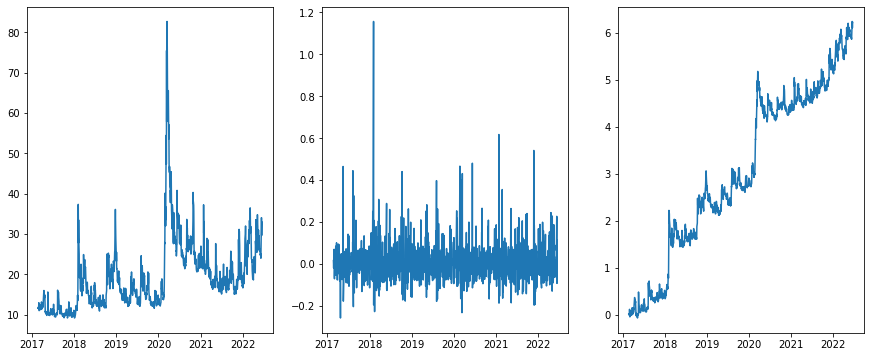

Consumer Confidence


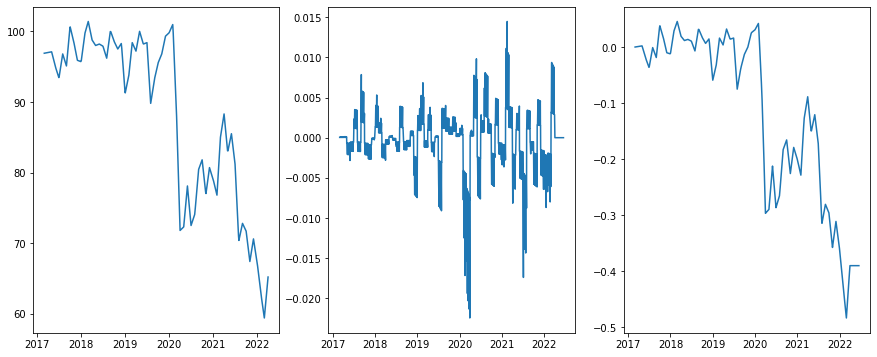

Unemployment


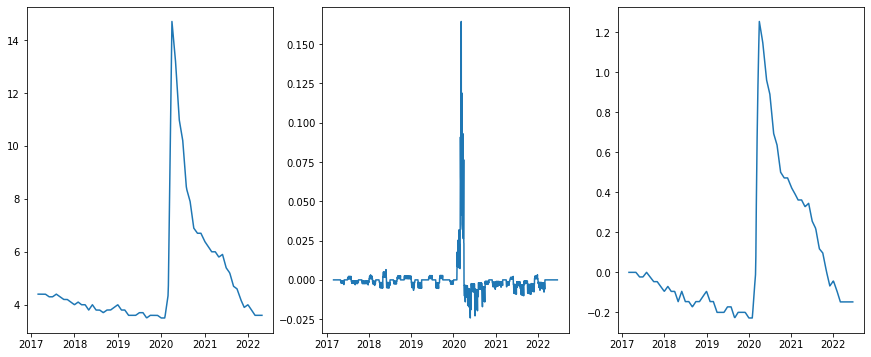

Inflation


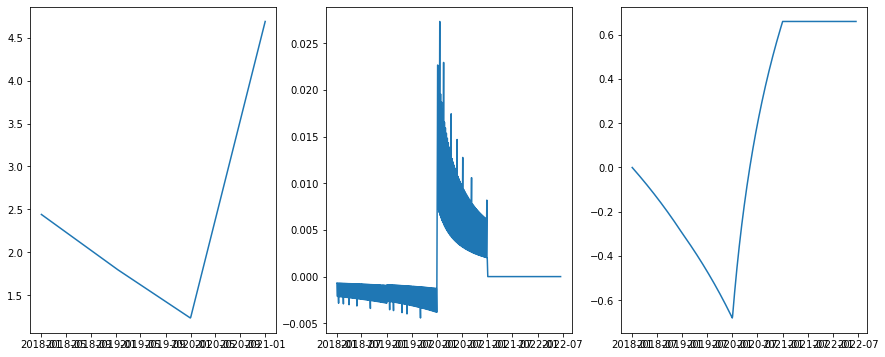

Interest Rates


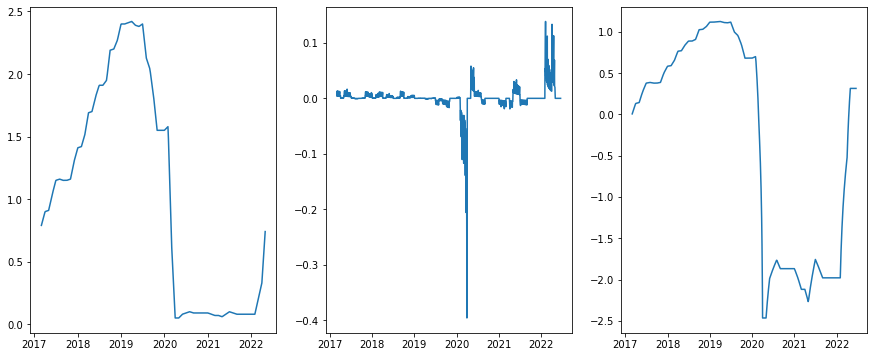

10 Year to 3 Month


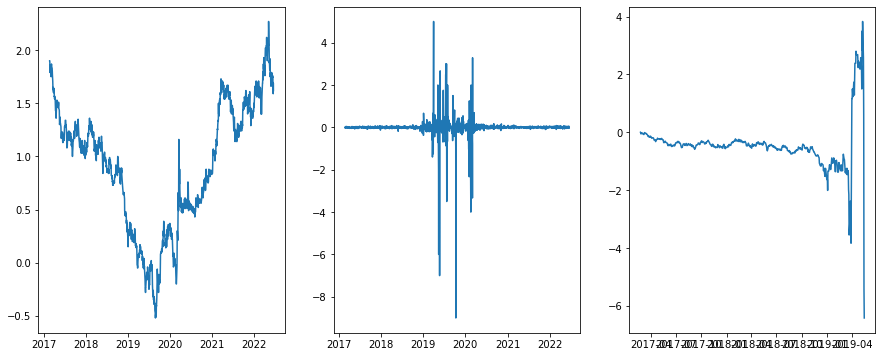

Recession Indicator


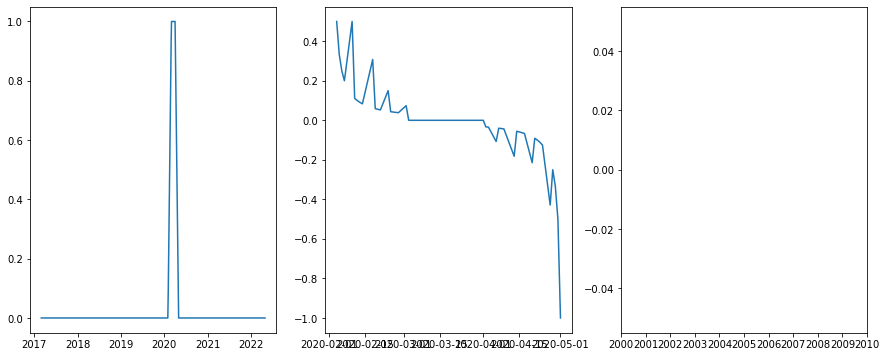

In [56]:
fred_friendly_names = ['Market volatility','Consumer Confidence','Unemployment','Inflation','Interest Rates','10 Year to 3 Month','Recession Indicator']
fred_names = ['VIXCLS','UMCSENT','UNRATE','FPCPITOTLZGUSA','FEDFUNDS','T10Y3M','USREC']
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos])
    name = fred_names[pos]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    plt.show()

In [57]:
#screener['vol_30d_2yr']

adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.
symbol: SPY
sector: error
sector: error
Index: SP500
vol_30d_2yr: 1719938470.5078125
Sector 1YMF: -287.8400573730469
1YMF: -287.8400573730469
risk trend factor: -3.791860877423899
      totalAssets  trailingPE
SPY  3.781762e+11    3.819317


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  365.859985  364.518828  396.470318  428.421808  419.420001   

              90dSDev   90d_lower   90d_upper  
2022-06-17  25.514981  368.390039  470.449963

volume_factor    latest_p        vol_30d_2yr   pct_2yr       adf     hurst
SPY      1.183517  365.859985  1719938470.507812  0.369677  0.658465  0.422658

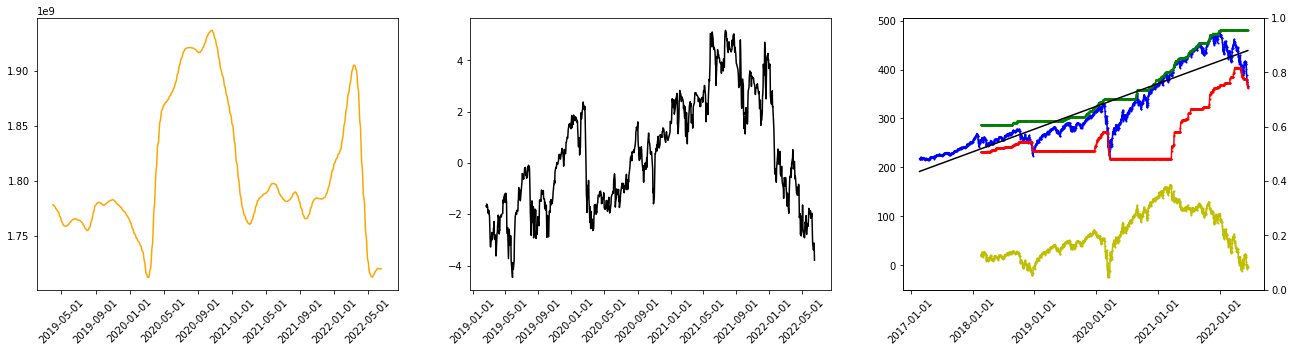

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 955.5530380098148 1191.7433986704013
test cv mean error, stdev (10 folds): 1006.6410231755444 1238.3800061175375
sell date: 2022-08-28
expected return: 0.07058189734213904
discounted return: 0.0009610577166867529
quarter return: 1.0923975305788942


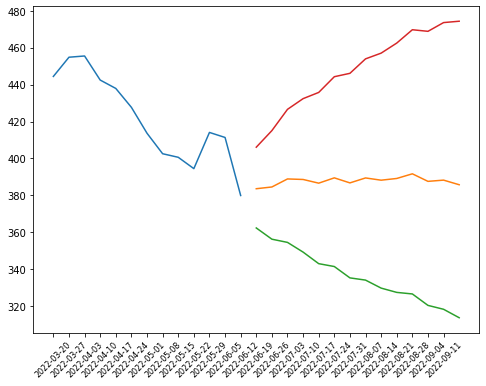

['options', ('2022-06-30', '2022-09-16', '2022-09-30', '2022-12-16', '2023-01-20', '2023-03-17', '2023-06-16', '2023-12-15', '2024-01-19', '2024-12-20')]
symbol: SPTM
sector: error
sector: error
Index: SP1500
vol_30d_2yr: 10189559.1796875
Sector 1YMF: -34.95000076293945
1YMF: -34.95000076293945
risk trend factor: -3.8790224724143685
       totalAssets
SPTM  5.538233e+09


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  45.310001  44.984943  48.919841  52.854739  51.683968  3.088065   

            90d_lower  90d_upper  
2022-06-17  45.507837  57.860099

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
SPTM      1.653055  45.310001  10189559.179688  0.388272  0.658826  0.429487

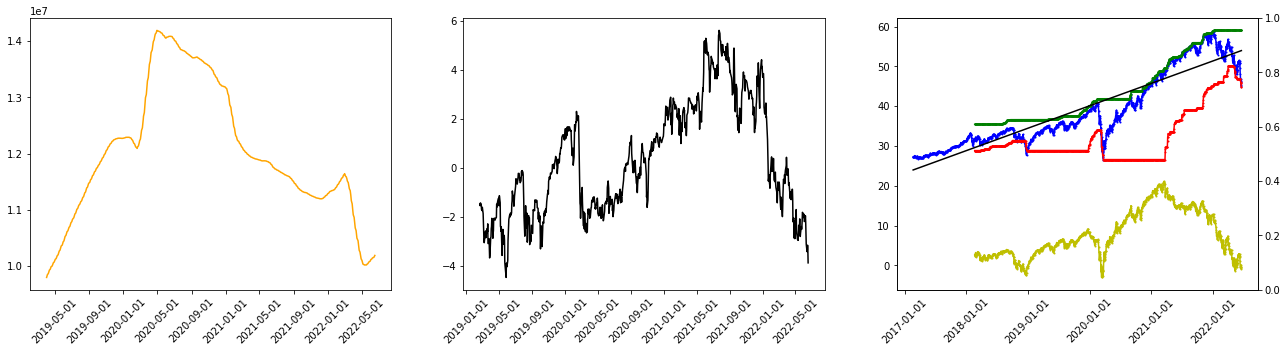

ets next 13 weeks
inner cv scores:
best model: ['add', None]
best inner cv score, sdev (11 folds): 14.216913910760638 16.99929371054808
test cv mean error, stdev (10 folds): 15.009608201431117 17.634103163229298
sell date: 2022-08-28
expected return: 0.07826007110730726
discounted return: 0.0010618125740489148
quarter return: 1.1025602010577402


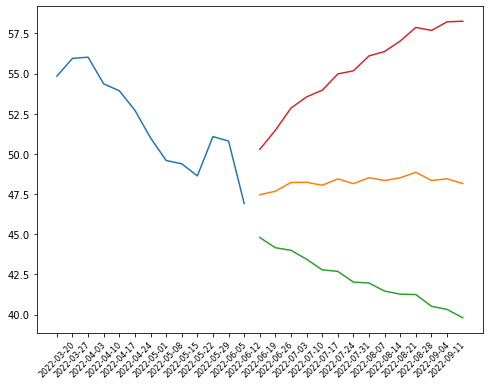

symbol: MDYG
sector: error
sector: error
Index: SP400
vol_30d_2yr: 4938966.40625
Sector 1YMF: -69.05999755859375
1YMF: -69.05999755859375
risk trend factor: -5.134573474205833
Empty DataFrame
Columns: []
Index: [MDYG]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     59.93  59.511554  65.413016  71.314478  69.046349  4.323319   

            90d_lower  90d_upper  
2022-06-17  60.399712  77.692987

volume_factor latest_p    vol_30d_2yr   pct_2yr       adf     hurst
MDYG      0.576598    59.93  4938966.40625  0.256027  0.494117  0.451147

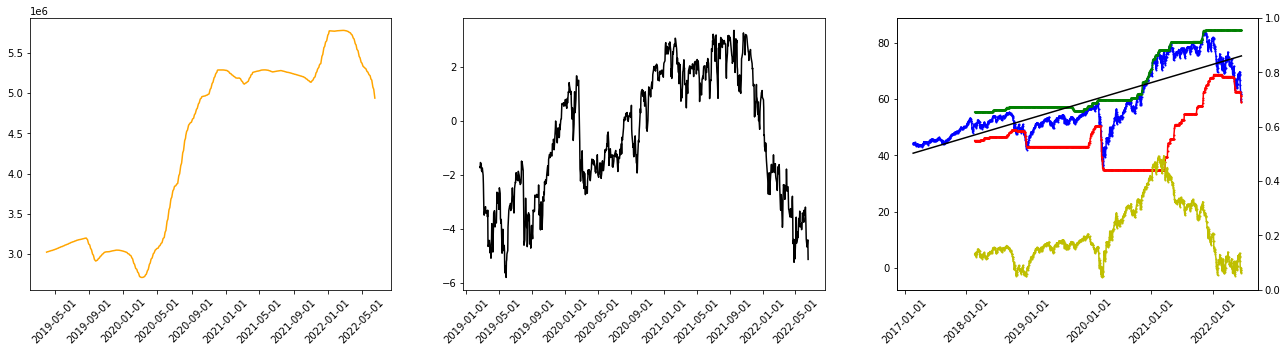

ets next 13 weeks
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 63.12940057605013 122.8158975223343
test cv mean error, stdev (10 folds): 68.7769682058603 127.44125678814828
sell date: 2022-08-28
expected return: 0.08795996029825129
discounted return: 0.001188090383676288
quarter return: 1.115429391183908


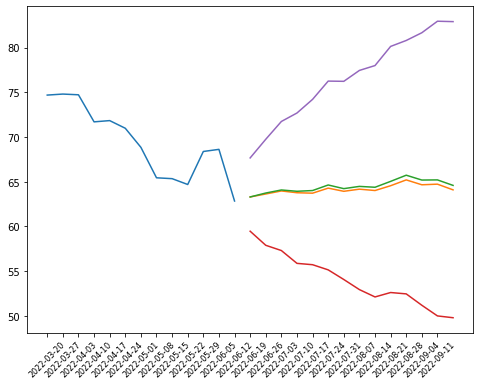

symbol: SLY
sector: error
sector: error
Index: SP600
vol_30d_2yr: 1808137.109375
Sector 1YMF: -77.27001953125
1YMF: -77.27001953125
risk trend factor: -5.242200185196592
Empty DataFrame
Columns: []
Index: [SLY]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  78.089996  78.068302  85.071269  92.074236  88.226349  4.474948   

            90d_lower  90d_upper  
2022-06-17  79.276452  97.176246

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf    hurst
SLY       1.23276  78.089996  1808137.109375  0.449524  0.532018  0.51304

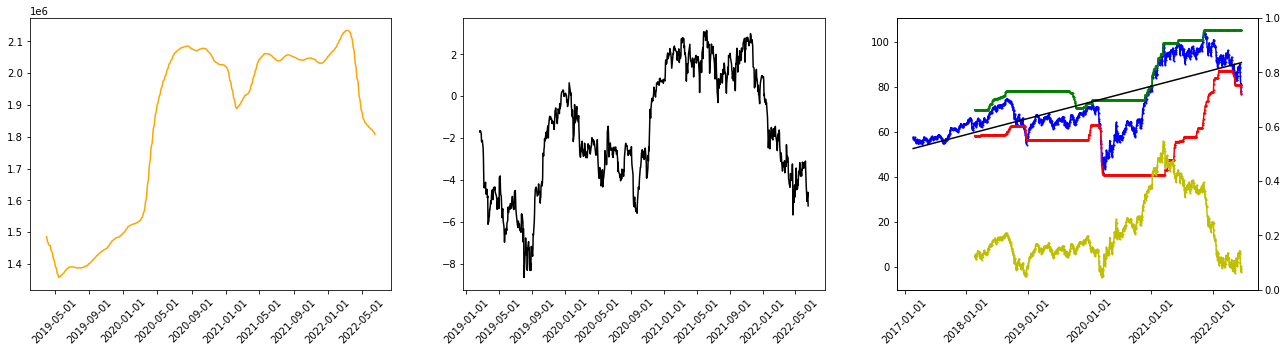

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', False]
best inner cv score, sdev (11 folds): 103.79480906546087 141.07842997596458
test cv mean error, stdev (10 folds): 112.11692332120931 145.36713007164084
sell date: 2022-08-28
expected return: 0.12123340538683379
discounted return: 0.0016129802185542719
quarter return: 1.1598313773583642


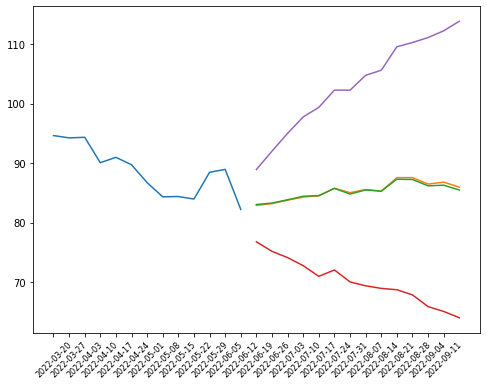

symbol: VDE
sector: error
sector: Energy
Index: nan
vol_30d_2yr: 25785341.015625
Sector 1YMF: -3.82000732421875
1YMF: -3.82000732421875
risk trend factor: -0.12330558135216596
      totalAssets  trailingPE
VDE  1.106882e+10    8.493072


Adj Close     21dBOLD   21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  102.349998  106.909959  119.43381  131.957661  112.539048   

             90dSDev 90d_lower   90d_upper  
2022-06-17  6.727104  99.08484  125.993256

volume_factor    latest_p      vol_30d_2yr  pct_2yr       adf     hurst
VDE      0.896641  102.349998  25785341.015625  0.70127  0.621023  0.512979

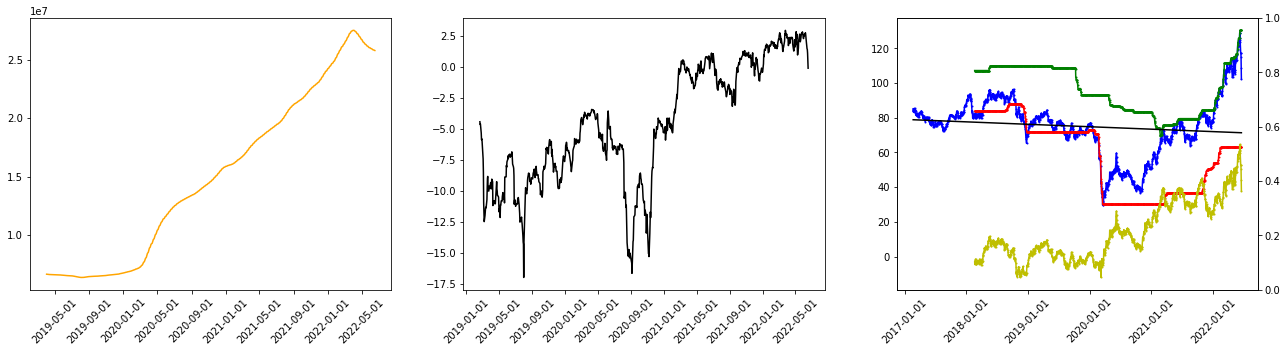

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 162.26029547339874 186.69480203926034
test cv mean error, stdev (10 folds): 177.93582907450696 188.7790932527092
sell date: 2022-09-11
expected return: 0.26130892989861954
discounted return: 0.002734909707801547
quarter return: 1.2856549169792901


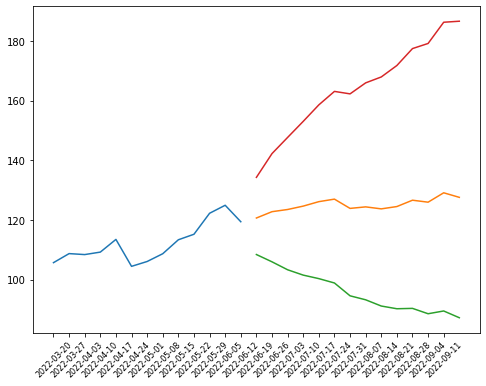

symbol: VDC
sector: error
sector: Consumer Defensive
Index: nan
vol_30d_2yr: 3264449.609375
Sector 1YMF: -74.80001831054688
1YMF: -74.80001831054688
risk trend factor: -2.283970024749523
      totalAssets
VDC  8.239956e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  177.059998  176.153403  185.845715  195.538026  194.674128   

             90dSDev   90d_lower   90d_upper  
2022-06-17  7.920194  178.833739  210.514517

volume_factor    latest_p     vol_30d_2yr  pct_2yr       adf     hurst
VDC      1.413592  177.059998  3264449.609375  0.48903  0.752482  0.355797

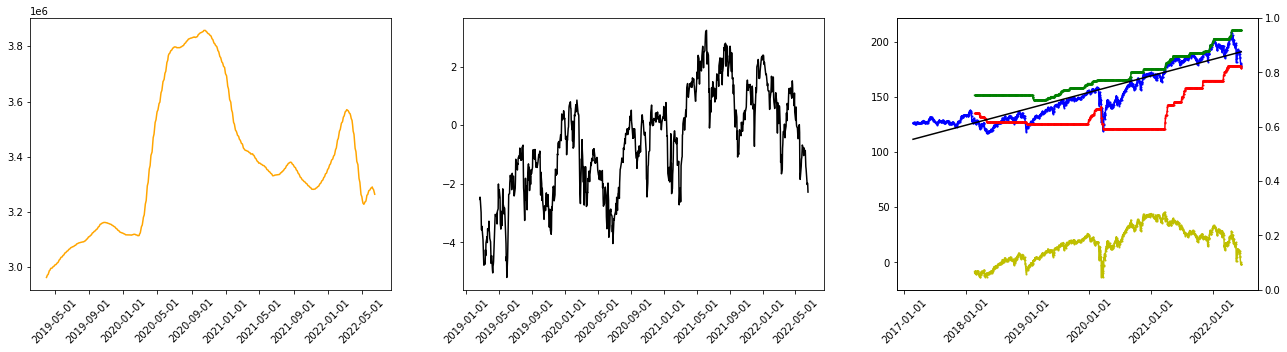

ets next 13 weeks
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 100.42512436388353 79.00572548206128
test cv mean error, stdev (10 folds): 95.34992470977237 81.1342076121161
sell date: 2022-08-14
expected return: 0.057358010250891024
discounted return: 0.0009789587563415747
quarter return: 1.0941963312790575


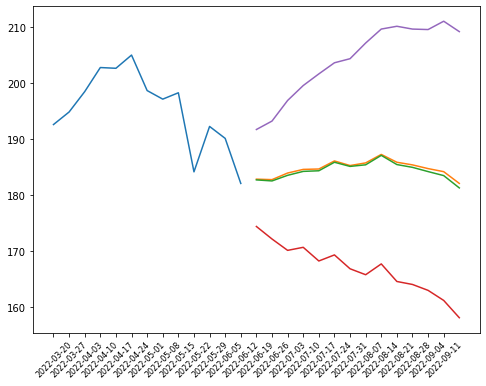

['options', ('2022-07-15',)]
symbol: VPU
sector: error
sector: Utilities
Index: nan
vol_30d_2yr: 5031661.71875
Sector 1YMF: -59.12998962402344
1YMF: -59.12998962402344
risk trend factor: -2.5204591944584465
      totalAssets
VPU  7.854255e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  141.440002  142.694749  156.469524  170.244299  158.564286   

             90dSDev  90d_lower   90d_upper  
2022-06-17  5.736683  147.09092  170.037651

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
VPU      1.250581  141.440002  5031661.71875  0.451674  0.569436  0.290073

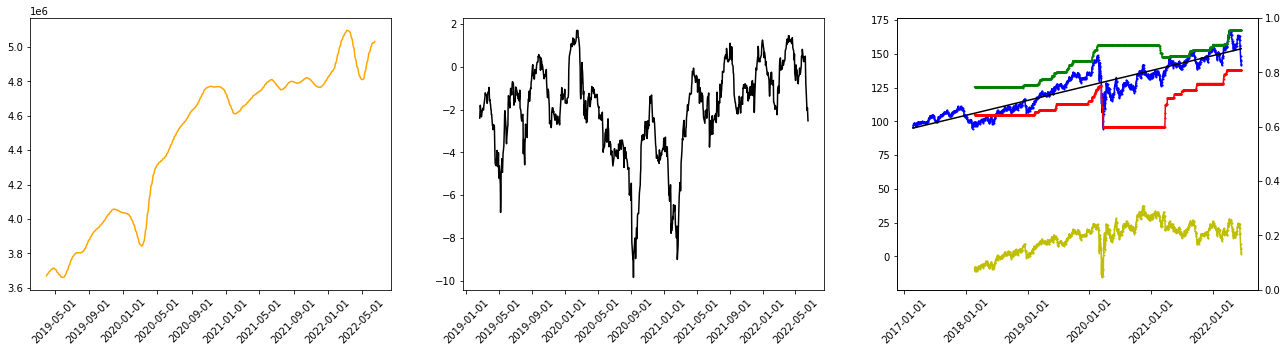

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', False]
best inner cv score, sdev (11 folds): 157.5005463320466 358.7513912245251
test cv mean error, stdev (10 folds): 172.24636181311752 373.0696811226028
sell date: 2022-06-19
expected return: 0.07690704446643742
discounted return: 0.07690704446643748
quarter return: 912.8429021811893


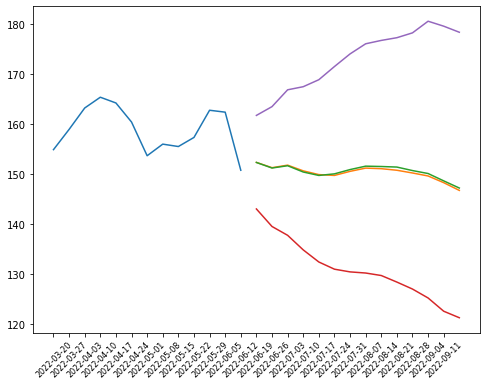

symbol: VNQ
sector: error
sector: Real Estate
Index: nan
vol_30d_2yr: 102932828.515625
Sector 1YMF: -76.09000396728516
1YMF: -76.09000396728516
risk trend factor: -3.053370235265123
      totalAssets
VNQ  7.839537e+10


Adj Close    21dBOLD  21dMA-TP     21dBOLU      90dSMA   90dSDev  \
2022-06-17  87.699997  86.580768  94.91381  103.246851  101.788572  7.189885   

            90d_lower   90d_upper  
2022-06-17  87.408801  116.168343

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf    hurst
VNQ      1.231534  87.699997  102932828.515625  0.296727  0.445676  0.39584

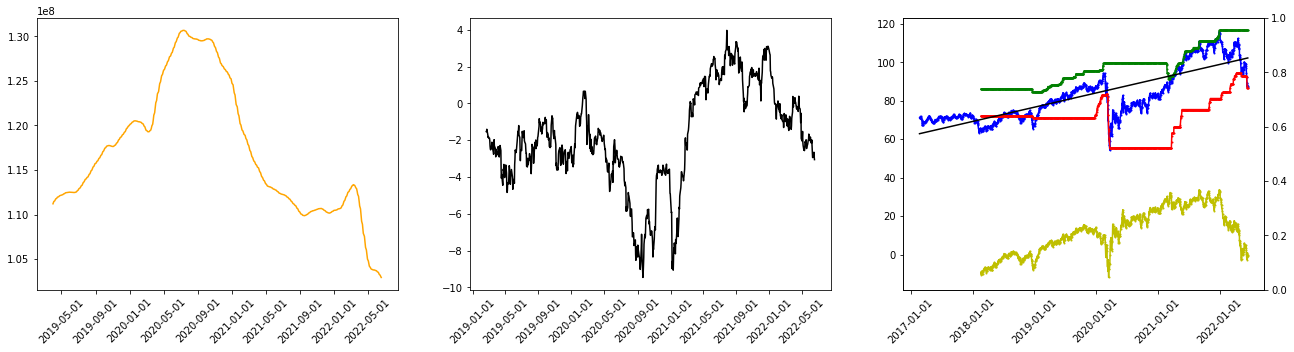

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 86.6754558291555 161.69827782578633
test cv mean error, stdev (10 folds): 93.69119366383254 167.9867282547259
sell date: 2022-08-28
expected return: 0.0600990038461087
discounted return: 0.000822342214404248
quarter return: 1.0785573848150745


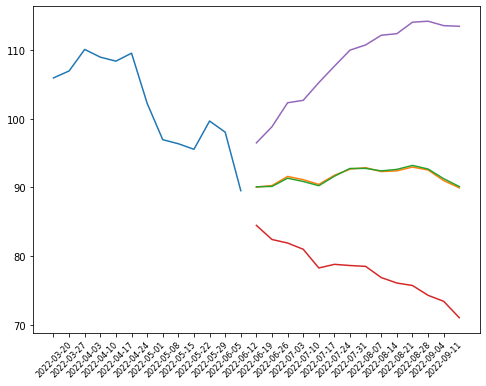

['options', ('2023-01-20', '2024-01-19')]
symbol: VAW
sector: error
sector: Basic Materials
Index: nan
vol_30d_2yr: 2683599.21875
Sector 1YMF: -109.739990234375
1YMF: -109.739990234375
risk trend factor: -3.165271062358118
      totalAssets
VAW  5.085875e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  162.800003  163.360294  181.546031  199.731768  187.277779   

             90dSDev   90d_lower   90d_upper  
2022-06-17  8.558355  170.161068  204.394489

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf    hurst
VAW      1.040096  162.800003  2683599.21875  0.553392  0.650248  0.42433

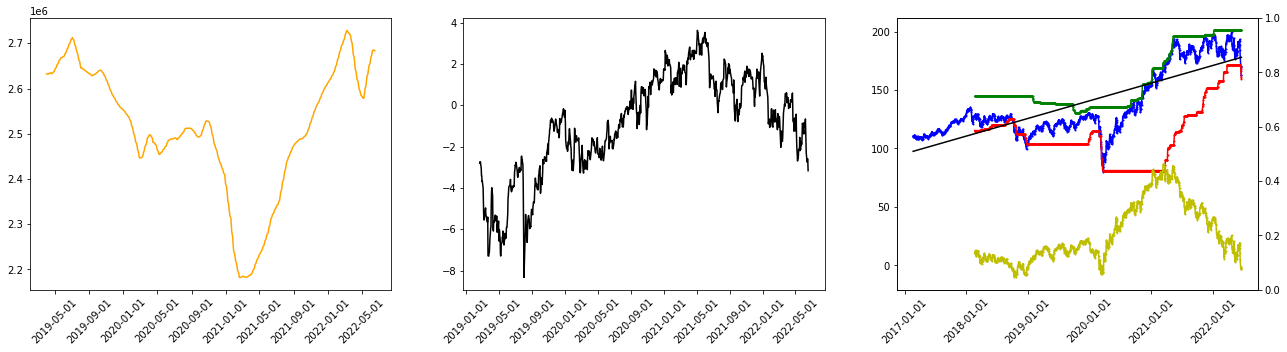

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 205.01175993608055 229.50284903376593
test cv mean error, stdev (10 folds): 219.7129902096578 235.7145379038364
sell date: 2022-09-11
expected return: 0.1434571605937443
discounted return: 0.0015783769202852849
quarter return: 1.1561507849128567


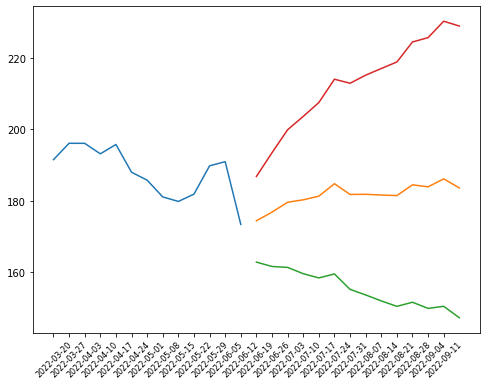

['options', ('2022-08-19',)]
symbol: VHT
sector: error
sector: Healthcare
Index: nan
vol_30d_2yr: 5367987.5
Sector 1YMF: -122.20997619628906
1YMF: -122.20997619628906
risk trend factor: -3.3236323632363236
      totalAssets  trailingPE
VHT  1.866525e+10    4.748669


Adj Close     21dBOLD    21dMA-TP    21dBOLU     90dSMA  \
2022-06-17  220.210007  218.770447  234.353333  249.93622  243.78492   

              90dSDev   90d_lower   90d_upper  
2022-06-17  11.544258  220.696404  266.873435

volume_factor    latest_p vol_30d_2yr   pct_2yr       adf     hurst
VHT      1.223885  220.210007   5367987.5  0.406751  0.629182  0.332826

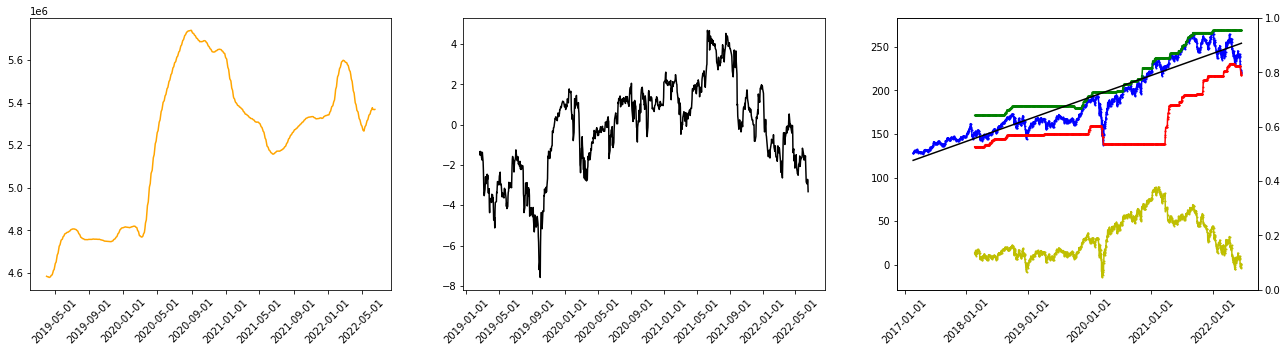

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 237.05412833601966 269.8255274714534
test cv mean error, stdev (10 folds): 227.72489246640166 281.2988311923906
sell date: 2022-06-19
expected return: 0.021888029867561654
discounted return: 0.021888029867561665
quarter return: 7.33001226082971


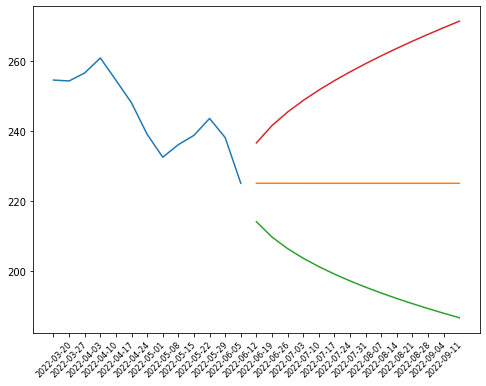

symbol: VIS
sector: error
sector: Industrials
Index: nan
vol_30d_2yr: 3372254.1015625
Sector 1YMF: -141.5800018310547
1YMF: -141.5800018310547
risk trend factor: -4.514668337867341
Empty DataFrame
Columns: []
Index: [VIS]


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  159.809998  159.424409  172.598254  185.772099  181.362857   

             90dSDev   90d_lower   90d_upper  
2022-06-17  9.892736  161.577386  201.148329

volume_factor    latest_p     vol_30d_2yr  pct_2yr       adf     hurst
VIS      0.869685  159.809998  3372254.101562  0.42518  0.484643  0.470479

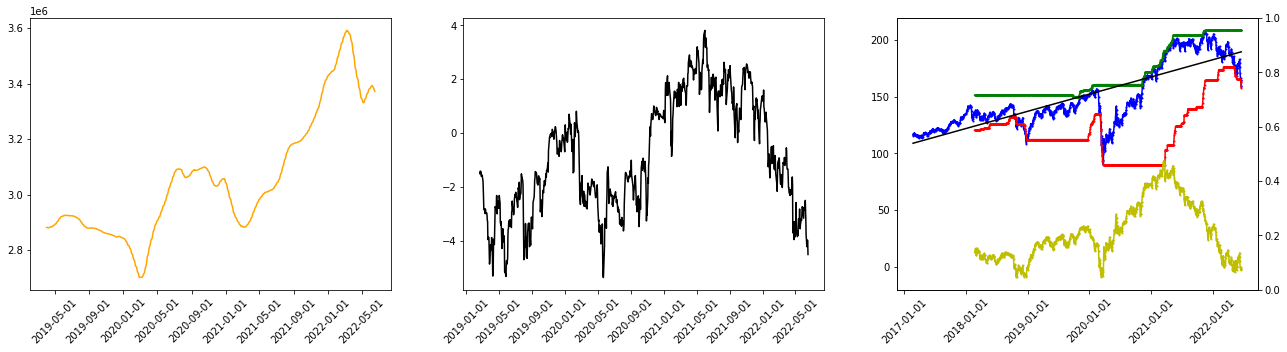

ets next 13 weeks
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 213.0870605161709 181.94570153913904
test cv mean error, stdev (10 folds): 223.72397175150405 187.53720445617554
sell date: 2022-07-24
expected return: 0.09548269646947537
discounted return: 0.002536408054857109
quarter return: 1.2624497831793169


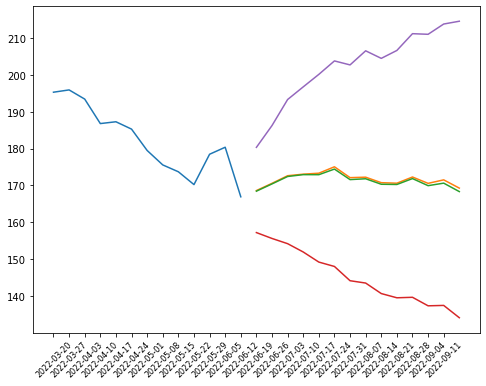

['options', ('2022-08-19',)]
symbol: VFH
sector: error
sector: Financial Services
Index: nan
vol_30d_2yr: 16520124.609375
Sector 1YMF: -72.2699966430664
1YMF: -72.2699966430664
risk trend factor: -4.617890709055871
      totalAssets
VFH  1.046217e+10


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-17  75.849998  74.907534  82.472858  90.038182  86.832222  5.55532   

            90d_lower  90d_upper  
2022-06-17  75.721582  97.942862

volume_factor   latest_p      vol_30d_2yr  pct_2yr       adf     hurst
VFH      1.270717  75.849998  16520124.609375  0.43829  0.480904  0.491635

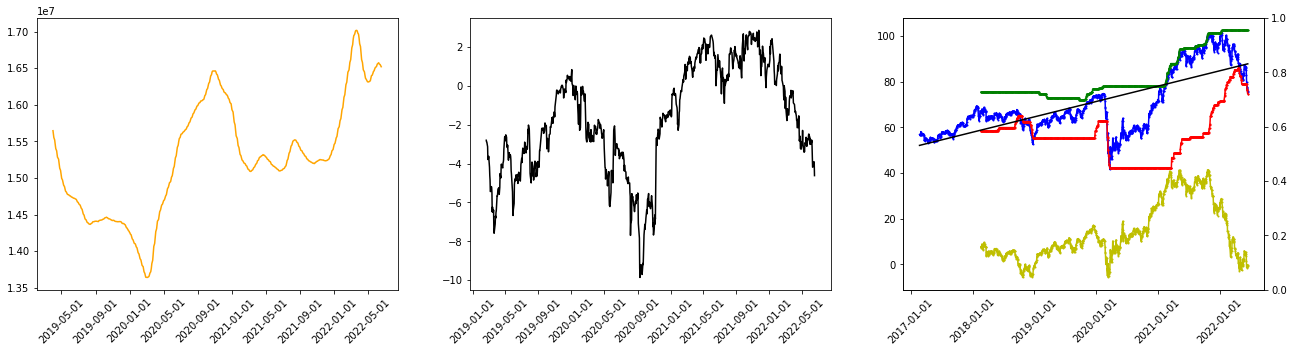

ets next 13 weeks
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 54.78029860420309 49.08269637960944
test cv mean error, stdev (10 folds): 57.39467195215102 50.743015953261754
sell date: 2022-07-24
expected return: 0.06062646092997322
discounted return: 0.0016363299522101915
quarter return: 1.1623215267522433


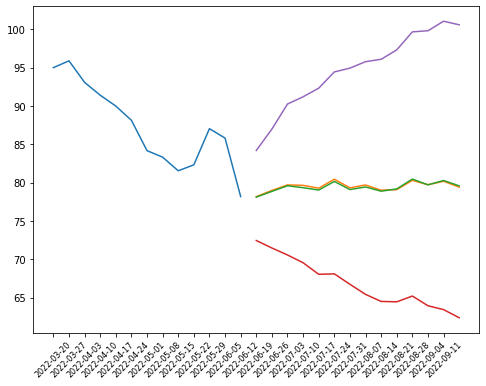

['options', ('2022-08-19',)]
symbol: VCR
sector: error
sector: Consumer Cyclical
Index: nan
vol_30d_2yr: 2596418.1640625
Sector 1YMF: -359.96002197265625
1YMF: -359.96002197265625
risk trend factor: -4.72140697901556
      totalAssets
VCR  6.015592e+09


Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  225.869995  218.39857  242.946031  267.493493  271.133333   

              90dSDev   90d_lower   90d_upper  
2022-06-17  28.125894  214.881544  327.385121

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
VCR      1.292819  225.869995  2596418.164062  0.205768  0.641228  0.473825

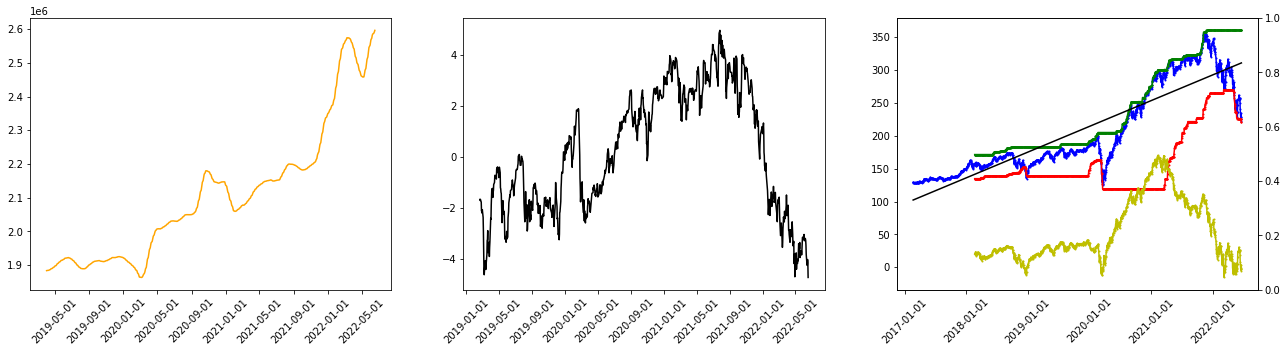

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 1049.0896144908686 1552.3876259817202
test cv mean error, stdev (10 folds): 1148.8474336165784 1594.2751961062204
sell date: 2022-08-07
expected return: 0.0593821658336815
discounted return: 0.0011543833035236872
quarter return: 1.1119797791234622


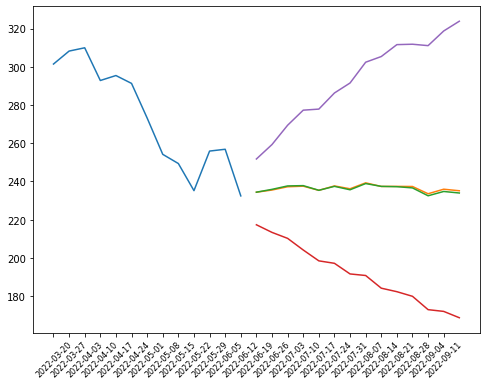

symbol: VGT
sector: error
sector: Technology
Index: nan
vol_30d_2yr: 14308852.5390625
Sector 1YMF: -363.4599914550781
1YMF: -363.4599914550781
risk trend factor: -4.954471974241429
      totalAssets
VGT  5.138536e+10


Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-17  319.809998  313.391914  345.179842  376.96777  371.755716   

              90dSDev   90d_lower  90d_upper  
2022-06-17  29.840347  312.075022  431.43641

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf    hurst
VGT      1.152846  319.809998  14308852.539062  0.262275  0.685573  0.43018

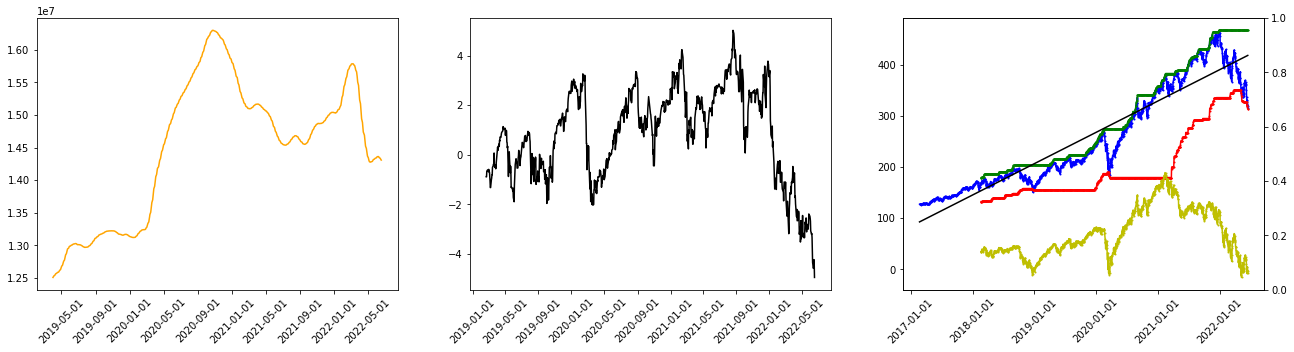

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 992.8049728521456 793.2003753375456
test cv mean error, stdev (10 folds): 1054.935316188718 805.9910660489109
sell date: 2022-08-07
expected return: 0.06229491495844206
discounted return: 0.001209362328965513
quarter return: 1.1176118263536885


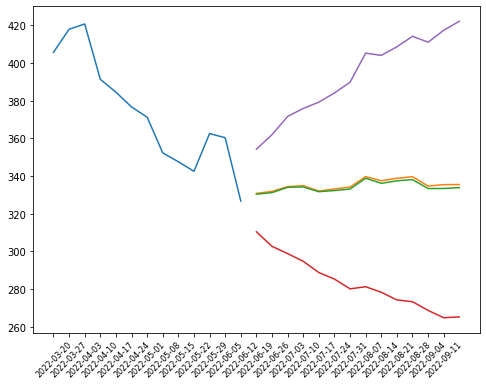

['options', ('2022-08-19',)]
symbol: VOX
sector: error
sector: Communication Services
Index: nan
vol_30d_2yr: 4644931.8359375
Sector 1YMF: -166.010009765625
1YMF: -166.010009765625
risk trend factor: -8.783597691159713
Empty DataFrame
Columns: []
Index: [VOX]


Adj Close    21dBOLD   21dMA-TP     21dBOLU      90dSMA  90dSDev  \
2022-06-17  92.860001  91.464788  99.415079  107.365371  107.439841  9.28909   

            90d_lower   90d_upper  
2022-06-17  88.861661  126.018022

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
VOX      1.840996  92.860001  4644931.835938  0.059723  0.708136  0.512969

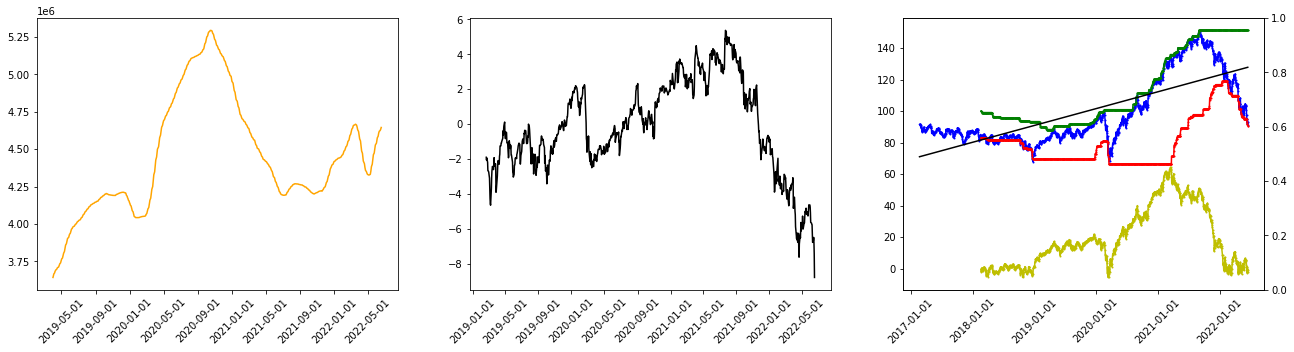

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 85.90984878407944 73.83518328694369
test cv mean error, stdev (10 folds): 91.80178558008868 74.93310982290866
sell date: 2022-08-28
expected return: 0.06417181312801591
discounted return: 0.000876395872420721
quarter return: 1.0839297663024807


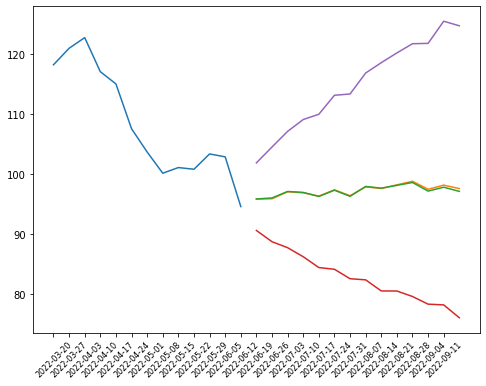

['options', ('2022-07-15',)]
symbol: ACC
sector: Real Estate
Index: SP400
vol_30d_2yr: 27009982.03125
Sector 1YMF: 13.440017700195312
1YMF: 13.440017700195312
risk trend factor: 10.926847725292072
        beta currentRatio debtToEquity dividendRate dividendYield  \
ACC  1.00147        2.184      122.276         1.88         0.029   

    earningsGrowth     ebitda ebitdaMargins forwardPE grossMargins  \
ACC          1.498  466354240       0.47421  98.81539       0.5349   

    grossProfits heldPercentInstitutions          industry   marketCap  \
ACC    498042000                 0.97986  REIT—Residential  8938053632   

    operatingMargins payoutRatio pegRatio priceToBook  \
ACC          0.19318         4.7     1.96    2.993987   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
ACC                     9.088625       0.06005      1.888        0.01582   

    returnOnEquity revenueGrowth revenuePerShare       sector  \
ACC        0.01872         0.176         

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  64.230003  64.240713  64.712222  65.183731  62.082857  3.916774   

            90d_lower  90d_upper  
2022-06-17  54.249309  69.916406

volume_factor   latest_p     vol_30d_2yr  pct_2yr       adf     hurst
ACC      2.134689  64.230003  27009982.03125  0.97101  0.978004  0.420279

Sector 1YMF: -76.09000396728516
Sector Volume Factor: 1.2315342134094496
Sector Risk Trend Factor: -3.053370235265123
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


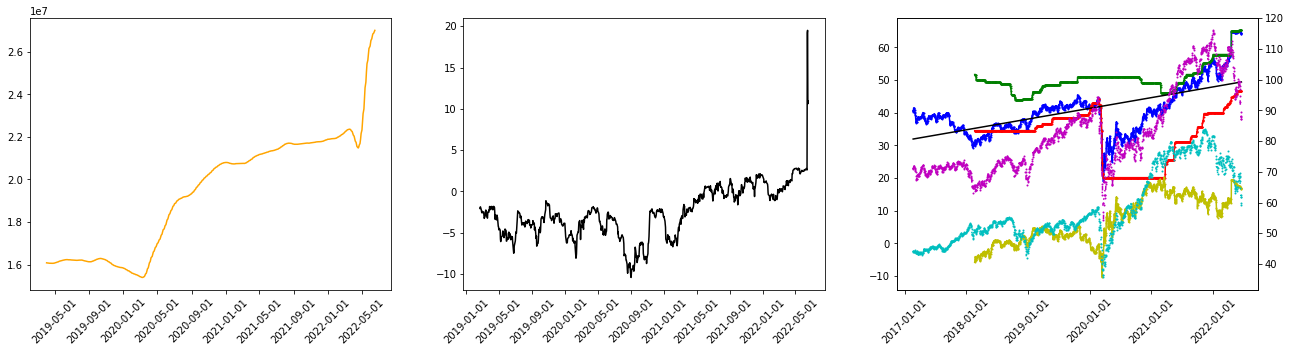

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 14.002980451308668 10.442431952669184
test cv mean error, stdev (10 folds): 15.172164712879768 10.242651713301198
sell date: 2022-09-18
expected return: 0.0043873211349221685
discounted return: 4.758509843005854e-05
quarter return: 1.0043873211349195


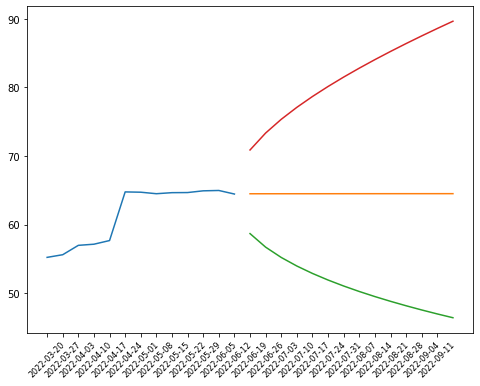

['quarterly_balance_sheet',                              2022-03-31    2021-12-31    2021-09-30  \
Capital Surplus            4.693018e+09  4.694242e+09  4.538210e+09   
Total Liab                 4.218002e+09  4.273301e+09  4.501487e+09   
Total Stockholder Equity   3.093994e+09  3.117378e+09  2.982993e+09   
Minority Interest          1.842520e+08  1.839070e+08  6.423900e+07   
Deferred Long Term Liab    7.300000e+06  3.450000e+07  2.750000e+07   
Total Assets               7.496248e+09  7.574586e+09  7.548719e+09   
Common Stock               1.393000e+06  1.391000e+06  1.390000e+06   
Other Current Assets       1.698800e+07  1.432600e+07  2.016300e+07   
Other Liab                 1.522020e+08  1.697290e+08  1.850330e+08   
Treasury Stock            -1.600417e+09 -1.578255e+09 -1.556607e+09   
Other Assets               2.143290e+08  1.773490e+08  2.318220e+08   
Cash                       8.765600e+07  1.203510e+08  4.207300e+07   
Total Current Liabilities  5.727700e+07  1.168230

Adj Close    21dBOLD   21dMA-TP   21dBOLU     90dSMA   90dSDev  \
2022-06-17  35.939999  35.942037  36.098889  36.25574  35.883651  0.243988   

            90d_lower  90d_upper  
2022-06-17  35.395675  36.371626

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf    hurst
MTOR      1.664475  35.939999  15456103.320312  0.980154  0.319063  0.43585

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


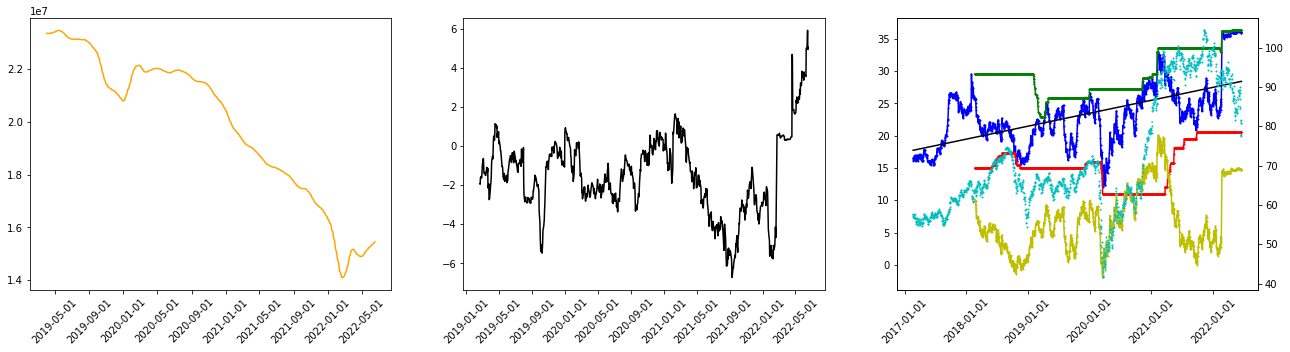

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 16.339797467108134 12.251312736702047
test cv mean error, stdev (10 folds): 16.151104613250034 12.834042499659013
sell date: 2022-07-24
expected return: 0.004201066765801288
discounted return: 0.0001164586397262024
quarter return: 1.0107711668268085


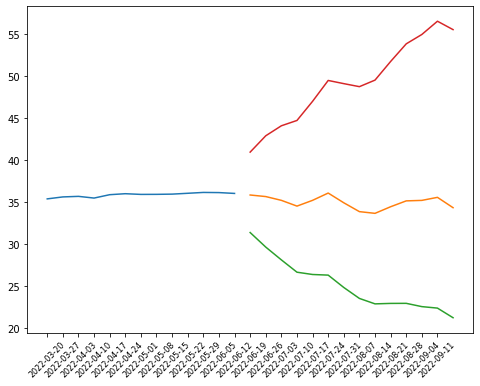

['options', ('2022-08-19',)]
symbol: TVTY
sector: error
sector: error
Index: SP600
vol_30d_2yr: 10900973.046875
Sector 1YMF: 2.7400035858154297
1YMF: 2.7400035858154297
risk trend factor: 2.3418794362082624
Empty DataFrame
Columns: []
Index: [TVTY]


Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  32.130001  31.878985  32.19127  32.503555  31.861111  0.826432   

            90d_lower  90d_upper  
2022-06-17  30.208246  33.513976

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
TVTY      1.643789  32.130001  10900973.046875  0.966327  0.518794  0.448871

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


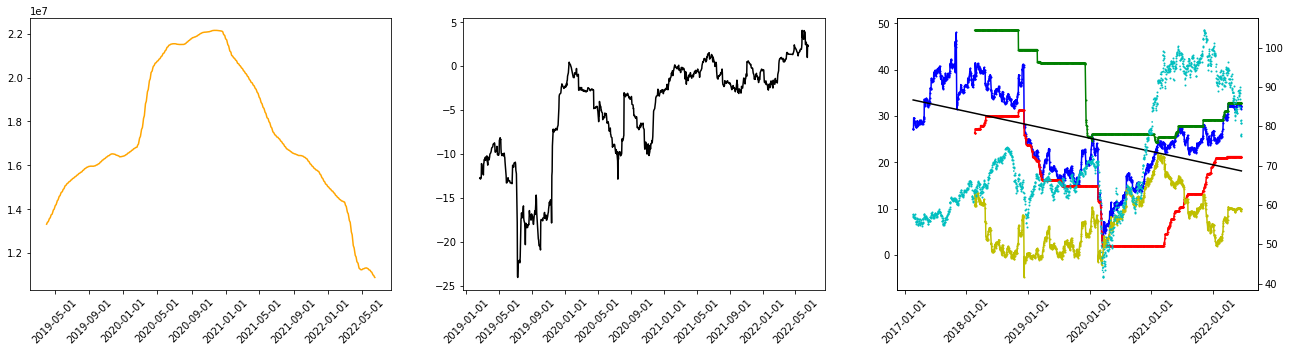

ets next 13 weeks
inner cv scores:
best model: [None, 'add', False]
best inner cv score, sdev (11 folds): 21.097800759872197 17.71902968222689
test cv mean error, stdev (10 folds): 22.5903469866116 17.91244789487483
sell date: 2022-09-18
expected return: 0.08387397070642642
discounted return: 0.0008758358538163424
quarter return: 1.083873970706425


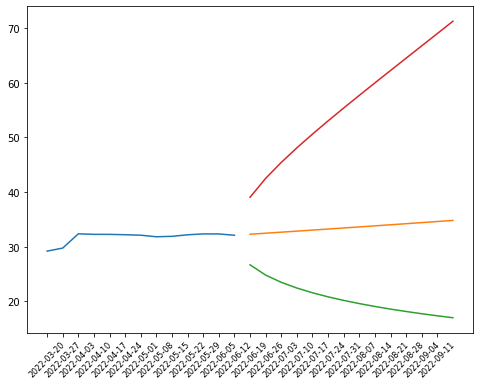

['options', ('2022-08-19',)]
symbol: BANF
sector: error
sector: error
Index: SP600
vol_30d_2yr: 2480755.6640625
Sector 1YMF: 33.56000518798828
1YMF: 33.56000518798828
risk trend factor: 2.0119906818931326
Empty DataFrame
Columns: []
Index: [BANF]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  94.860001  81.144325  89.856826  98.569327  85.566191  4.220089   

            90d_lower  90d_upper  
2022-06-17  77.126013  94.006368

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
BANF      1.135864  94.860001  2480755.664062  0.965783  0.955166  0.536352

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


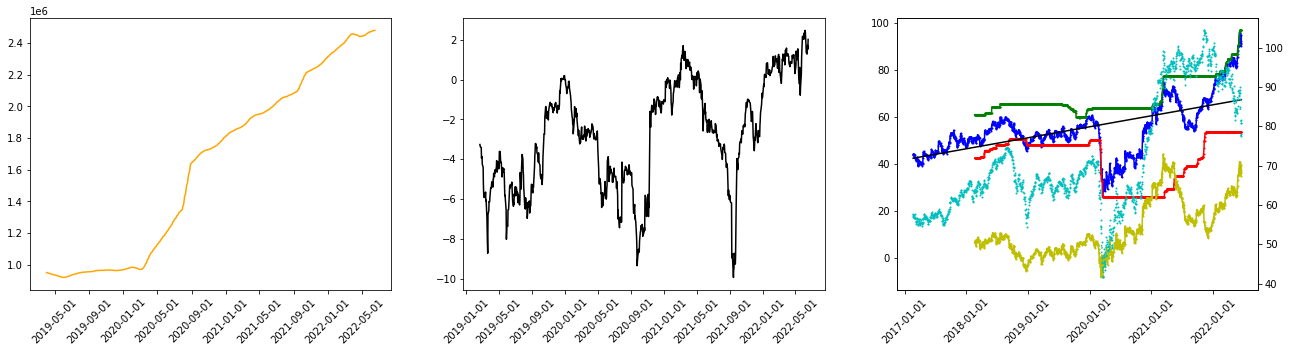

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 64.40840297506074 42.523508838176234
test cv mean error, stdev (10 folds): 68.88292685552456 42.0575639735724
sell date: 2022-09-18
expected return: -0.03831151591514609
discounted return: -0.0004245261879796125
quarter return: 0.96168848408485


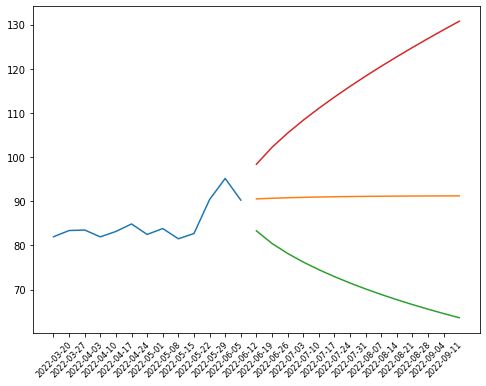

symbol: Y
sector: Financial Services
Index: SP400
vol_30d_2yr: 1623886.71875
Sector 1YMF: 27.8699951171875
1YMF: 27.8699951171875
risk trend factor: 1.771775570386466
       beta currentRatio debtToEquity earningsGrowth      ebitda  \
Y  0.663839        1.597         31.5         -0.433  1620000000   

  ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
Y       0.13423  9.936376     90016496      0.44211   5101669000   

  heldPercentInstitutions                       industry    marketCap  \
Y                 0.86723  Insurance—Property & Casualty  11220848640   

  operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
Y        1928840960          0.11935           0     0.15    1.305451   

  priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
Y                     0.929715        0.0771      1.004        0.02938   

  returnOnEquity revenueGrowth revenuePerShare              sector  \
Y        0.11868         0.025         878.577

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17     830.5  830.573879  833.250157  835.926435  838.613332   

             90dSDev  90d_lower   90d_upper  
2022-06-17  7.460501  823.69233  853.534333

volume_factor latest_p    vol_30d_2yr   pct_2yr       adf     hurst
Y       1.56538    830.5  1623886.71875  0.919536  0.382688  0.459685

Sector 1YMF: -72.2699966430664
Sector Volume Factor: 1.2707168073107045
Sector Risk Trend Factor: -4.617890709055871
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


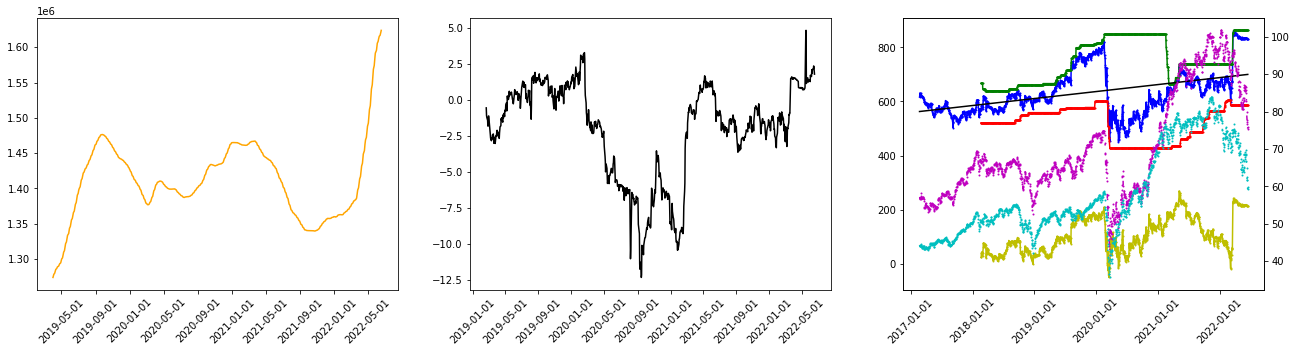

ets next 13 weeks
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 6830.83998938945 9059.456308741981
test cv mean error, stdev (10 folds): 7149.575450461864 9442.747716168018
sell date: 2022-08-07
expected return: 0.018482186671808076
discounted return: 0.0003663364200887642
quarter return: 1.0342709463466802


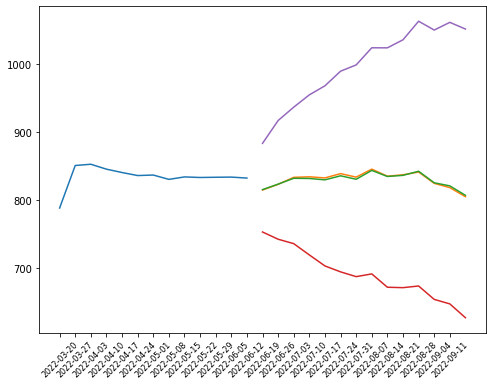

['options', ('2022-07-15',)]
['sustainability',                            Value
2022-5                          
palmOil                    False
controversialWeapons       False
gambling                   False
socialScore                 8.71
nuclear                    False
furLeather                 False
alcoholic                  False
gmo                        False
catholic                   False
socialPercentile            None
peerCount                     96
governanceScore            11.77
environmentPercentile       None
animalTesting              False
tobacco                    False
totalEsg                   21.71
highestControversy             1
esgPerformance          AVG_PERF
coal                       False
pesticides                 False
adult                      False
percentile                 30.32
peerGroup              Insurance
smallArms                  False
environmentScore            1.23
governancePercentile        None
militaryContract           F

Adj Close     21dBOLD    21dMA-TP     21dBOLU     90dSMA  \
2022-06-17  208.309998  186.953267  199.289207  211.625148  191.30127   

            90dSDev   90d_lower   90d_upper  
2022-06-17  7.50937  176.282531  206.320009

volume_factor    latest_p     vol_30d_2yr  pct_2yr       adf     hurst
SAFM      1.334104  208.309998  5061001.171875  0.98121  0.675913  0.476629

Sector 1YMF: -74.80001831054688
Sector Volume Factor: 1.4135920452708397
Sector Risk Trend Factor: -2.283970024749523
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


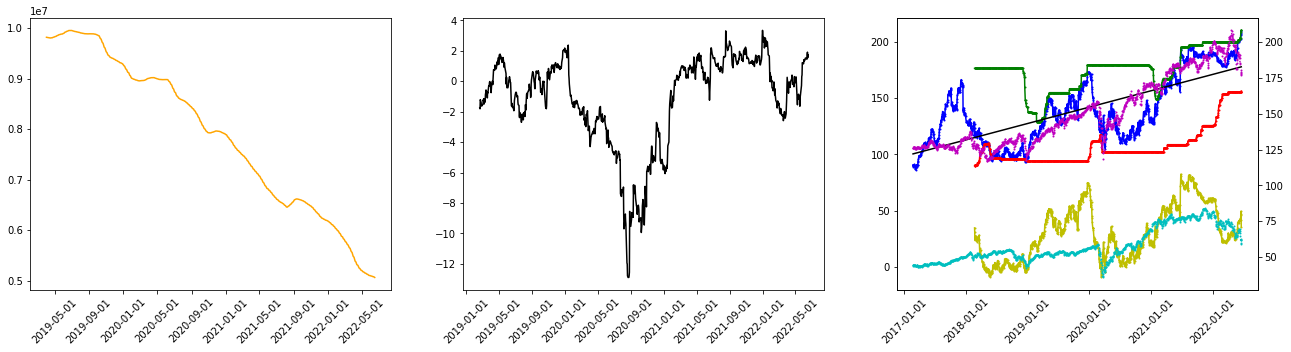

ets next 13 weeks
inner cv scores:
best model: [None, 'add', False]
best inner cv score, sdev (11 folds): 341.8995456857701 406.0401102878622
test cv mean error, stdev (10 folds): 366.1965661087105 418.16467429903594
sell date: 2022-09-18
expected return: 0.03477390905806314
discounted return: 0.00037162292056591717
quarter return: 1.0347739090580612


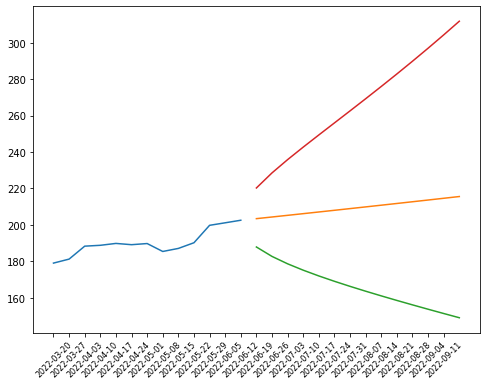

['options', ('2022-08-19', '2022-12-16')]
symbol: SJI
sector: error
sector: error
Index: SP600
vol_30d_2yr: 26850614.0625
Sector 1YMF: 2.720003128051758
1YMF: 2.720003128051758
risk trend factor: 1.295238173088975
Empty DataFrame
Columns: []
Index: [SJI]


Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  34.200001  33.571564  34.29746  35.023356  34.252857  0.376732   

            90d_lower  90d_upper  
2022-06-17  33.499393  35.006321

volume_factor   latest_p    vol_30d_2yr   pct_2yr       adf     hurst
SJI      0.791297  34.200001  26850614.0625  0.934426  0.172286  0.415691

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


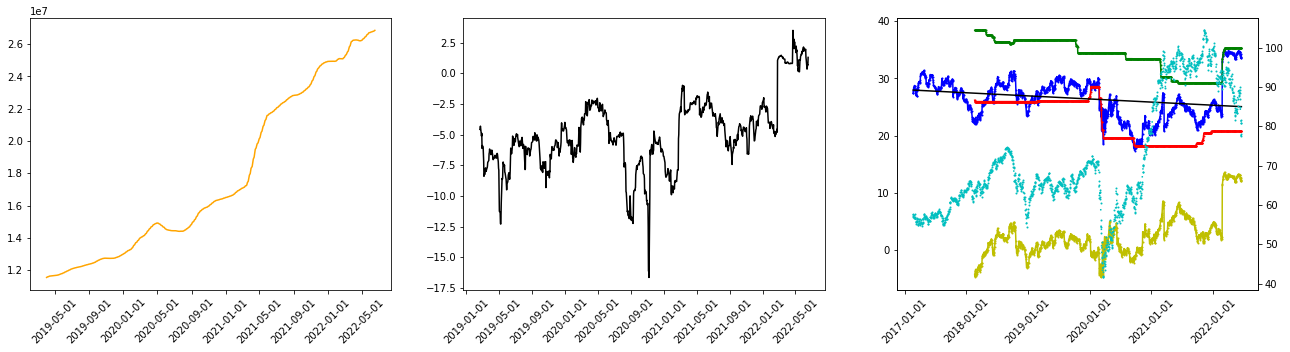

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 11.032857893371341 9.065456814726048
test cv mean error, stdev (10 folds): 12.011302107920269 8.936993711591871
sell date: 2022-09-18
expected return: -0.013758166069532271
discounted return: -0.00015057221476544314
quarter return: 0.9862418339304628


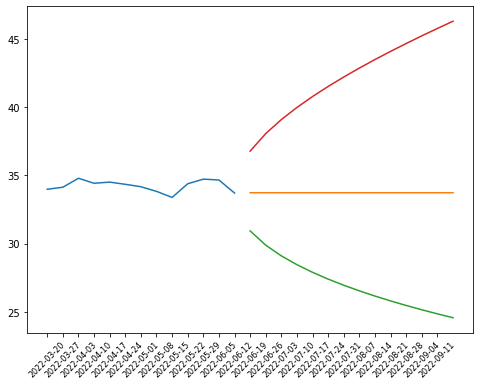

['options', ('2022-07-15',)]
symbol: LNTH
sector: Healthcare
Index: SP600
vol_30d_2yr: 14149384.1796875
Sector 1YMF: 22.491004943847656
1YMF: 22.491004943847656
risk trend factor: 1.1787739665678139
          beta currentRatio debtToEquity earningsGrowth     ebitda  \
LNTH  0.750453        1.828       36.846          3.692  108329000   

     ebitdaMargins  forwardPE freeCashflow grossMargins grossProfits  \
LNTH       0.20002  18.234236     77142872      0.50913    187695000   

     heldPercentInstitutions                industry   marketCap  \
LNTH                 1.01237  Diagnostics & Research  4167462400   

     operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
LNTH          54362000          0.11518           0     0.55    8.071249   

     priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
LNTH                     7.695022      -0.06892      1.563        0.04389   

     returnOnEquity revenueGrowth revenuePerShare      sector  \
LNTH 

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  60.720001  58.693247  66.262412  73.831578  61.742857  5.236883   

            90d_lower  90d_upper  
2022-06-17  51.269091  72.216623

volume_factor   latest_p      vol_30d_2yr  pct_2yr       adf     hurst
LNTH      1.823238  60.720001  14149384.179688  0.79355  0.965336  0.533209

Sector 1YMF: -122.20997619628906
Sector Volume Factor: 1.2238851152317325
Sector Risk Trend Factor: -3.3236323632363236
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


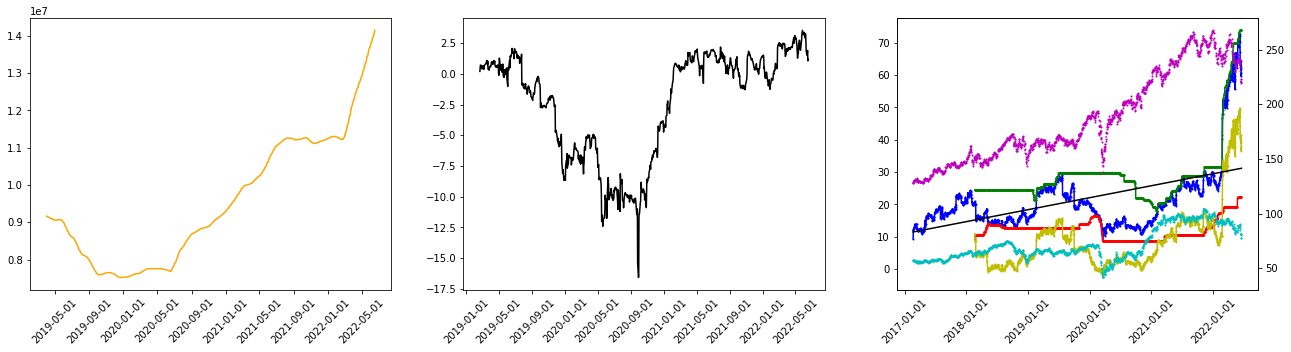

ets next 13 weeks
inner cv scores:
best model: [None, 'mul', True]
best inner cv score, sdev (11 folds): 42.20944812442461 64.78300074110848
test cv mean error, stdev (10 folds): 42.661154437542265 67.92863270301751
sell date: 2022-06-19
expected return: 0.029860428254579387
discounted return: 0.029860428254579352
quarter return: 14.983391569760325


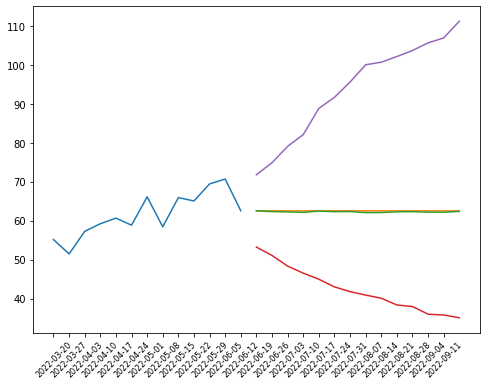

['quarterly_balance_sheet',                                    2022-03-31   2021-12-31   2021-09-30  \
Intangible Assets                 340204000.0  348510000.0  356883000.0   
Capital Surplus                   691516000.0  685472000.0  680819000.0   
Total Liab                        417316000.0  399345000.0  348472000.0   
Total Stockholder Equity          515850000.0  464439000.0  499344000.0   
Other Current Liab                 89178000.0          NaN          NaN   
Total Assets                      933166000.0  863784000.0  847816000.0   
Common Stock                         686000.0     677000.0     677000.0   
Other Current Assets               12860000.0    2705000.0   12043000.0   
Retained Earnings                -178263000.0 -221225000.0 -181010000.0   
Other Liab                         64083000.0  129181000.0   88437000.0   
Good Will                          61189000.0   61189000.0   61189000.0   
Treasury Stock                      1911000.0    -485000.0   -1142000.0 

Adj Close     21dBOLD   21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  259.380005  254.172765  260.19492  266.217074  267.576983   

             90dSDev   90d_lower  90d_upper  
2022-06-17  6.298768  254.979447  280.17452

volume_factor    latest_p     vol_30d_2yr  pct_2yr      adf     hurst
ROG      0.980653  259.380005  3248345.898438  0.91539  0.71811  0.478768

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


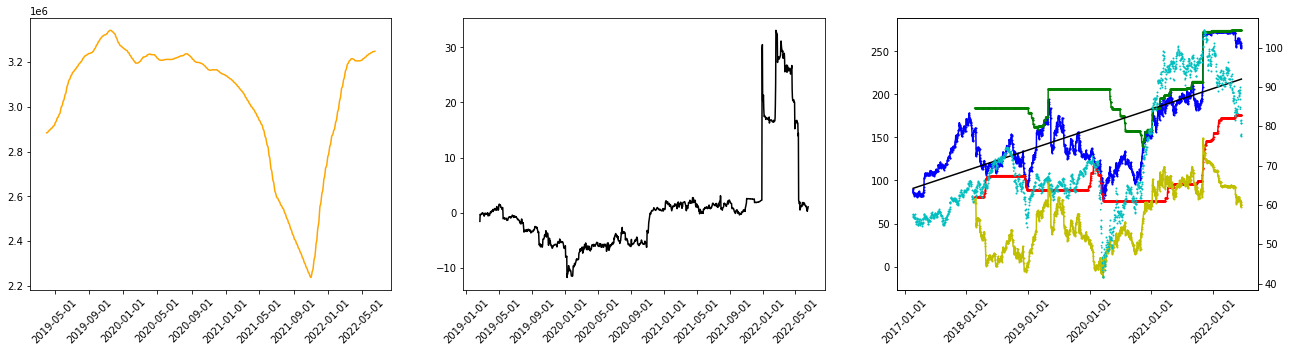

ets next 13 weeks
inner cv scores:
best model: [None, None]
best inner cv score, sdev (11 folds): 923.7177242546556 1367.48960810325
test cv mean error, stdev (10 folds): 1005.1315131672602 1408.5880717304296
sell date: 2022-06-19
expected return: -0.009700416122058986
discounted return: -0.009700416122058964
quarter return: 0.4078748091135111


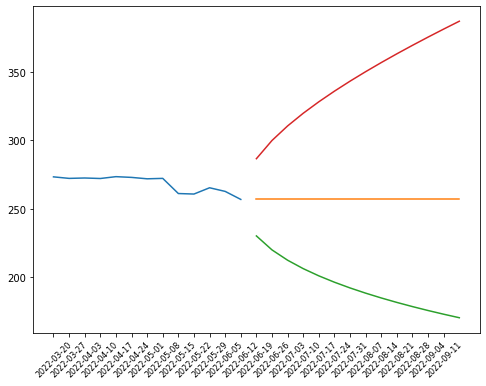

symbol: TWI
sector: Industrials
Index: SP600
vol_30d_2yr: 10530212.5
Sector 1YMF: 6.0800018310546875
1YMF: 6.0800018310546875
risk trend factor: 0.9310876079145333
         beta currentRatio debtToEquity earningsGrowth     ebitda  \
TWI  2.412885        1.853      219.119          0.682  163579008   

    ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
TWI       0.08464   8.09589    -24455124      0.13457    227051000   

    heldPercentInstitutions                             industry   marketCap  \
TWI                 0.77816  Farm & Heavy Construction Machinery  1110906752   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
TWI           8171000          0.06043           0     0.38    4.470499   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
TWI                     0.574797       0.03101      0.829        0.06237   

    returnOnEquity revenueGrowth revenuePerShare       sector  \
TWI        0.28169        

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     17.52  16.247353  18.072381  19.897408  15.954921  1.924943   

            90d_lower  90d_upper  
2022-06-17  12.105034  19.804807

volume_factor latest_p vol_30d_2yr   pct_2yr       adf     hurst
TWI      1.389288    17.52  10530212.5  0.876816  0.791457  0.500704

Sector 1YMF: -141.5800018310547
Sector Volume Factor: 0.8696853533786545
Sector Risk Trend Factor: -4.514668337867341
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


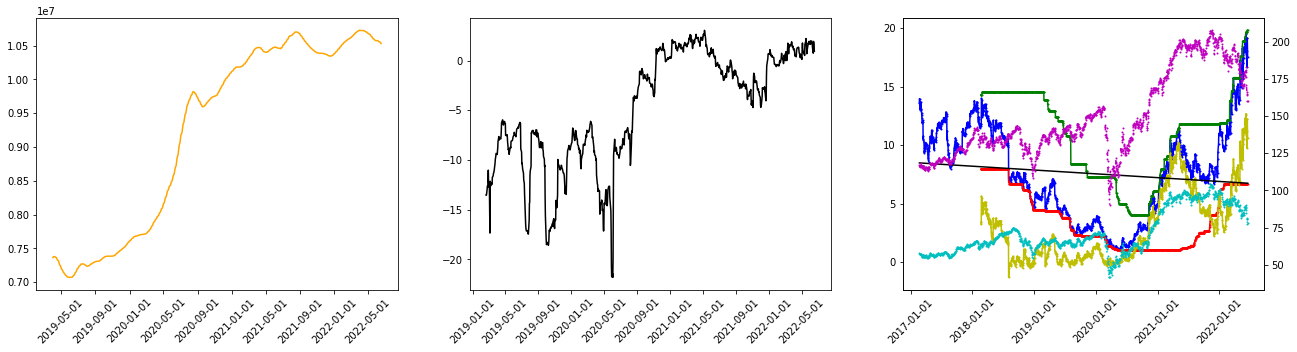

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 3.2805800359921733 4.993652709991219
test cv mean error, stdev (10 folds): 3.572171330127623 5.147324164231099
sell date: 2022-07-24
expected return: 0.027649232949760703
discounted return: 0.0007578952721092325
quarter return: 1.0721864295982584


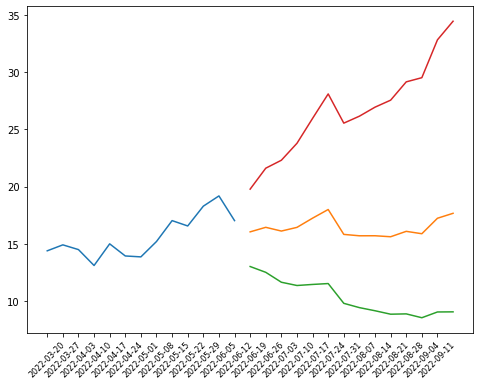

['options', ('2022-07-15',)]
symbol: PBF
sector: Energy
Index: SP600
vol_30d_2yr: 92668774.0234375
Sector 1YMF: 17.619998931884766
1YMF: 17.619998931884766
risk trend factor: 0.8876574451557954
         beta currentRatio debtToEquity     ebitda ebitdaMargins  forwardPE  \
PBF  2.259981        1.254      197.914  690400000       0.02194  11.930909   

    freeCashflow grossMargins grossProfits heldPercentInstitutions  \
PBF    284750016       0.0362    671100000                 0.80139   

                           industry   marketCap operatingCashflow  \
PBF  Oil & Gas Refining & Marketing  3964366848         803299968   

    operatingMargins payoutRatio pegRatio priceToBook  \
PBF           0.0135           0    -0.18    2.070946   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
PBF                     0.125972       0.00798      0.629        0.02192   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
PBF        0.14223   

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-17     32.98  27.175062  35.668889  44.162716  29.964286  5.34115   

            90d_lower  90d_upper  
2022-06-17  19.281986  40.646585

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
PBF      0.835417    32.98  92668774.023438  0.721917  0.581704  0.554972

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


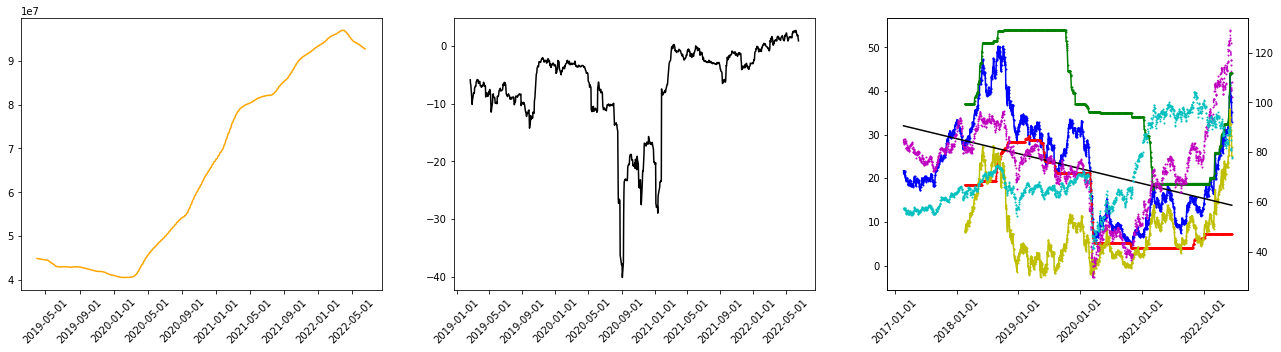

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', False]
best inner cv score, sdev (11 folds): 34.290264563311545 23.68393173963982
test cv mean error, stdev (10 folds): 29.94793293586909 20.238754848688544
sell date: 2022-08-07
expected return: 0.6501301570526777
discounted return: 0.010067422279423255
quarter return: 2.5132372643029206


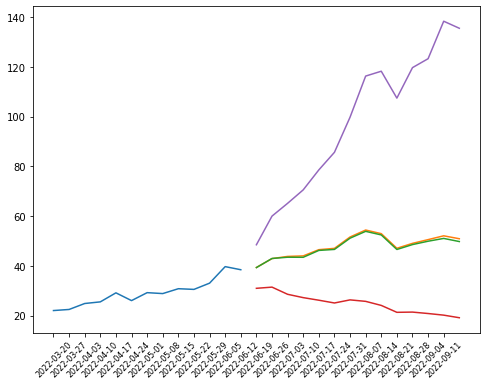

['options', ('2022-07-15', '2022-12-16', '2023-01-20', '2024-01-19')]
symbol: GO
sector: Consumer Defensive
Index: SP400
vol_30d_2yr: 21744971.2890625
Sector 1YMF: 9.090003967285156
1YMF: 9.090003967285156
risk trend factor: 0.8421349867224205
        beta currentRatio debtToEquity earningsGrowth     ebitda  \
GO -0.204778        1.904      144.187         -0.368  158646000   

   ebitdaMargins  forwardPE freeCashflow grossMargins grossProfits  \
GO       0.05023  34.782608    -14480875      0.30639    948786000   

   heldPercentInstitutions        industry   marketCap operatingCashflow  \
GO                  1.0557  Grocery Stores  3854695936         175503008   

   operatingMargins payoutRatio pegRatio priceToBook  \
GO          0.02681           0      3.5    3.760813   

   priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
GO                     1.220403       0.01741      0.611        0.02033   

   returnOnEquity revenueGrowth revenuePerShare              

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  40.150002  35.915072  38.024936  40.134801  35.226667  2.439389   

            90d_lower  90d_upper  
2022-06-17  30.347888  40.105445

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
GO      1.191531  40.150002  21744971.289062  0.687007  0.173605  0.403873

Sector 1YMF: -74.80001831054688
Sector Volume Factor: 1.4135920452708397
Sector Risk Trend Factor: -2.283970024749523
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


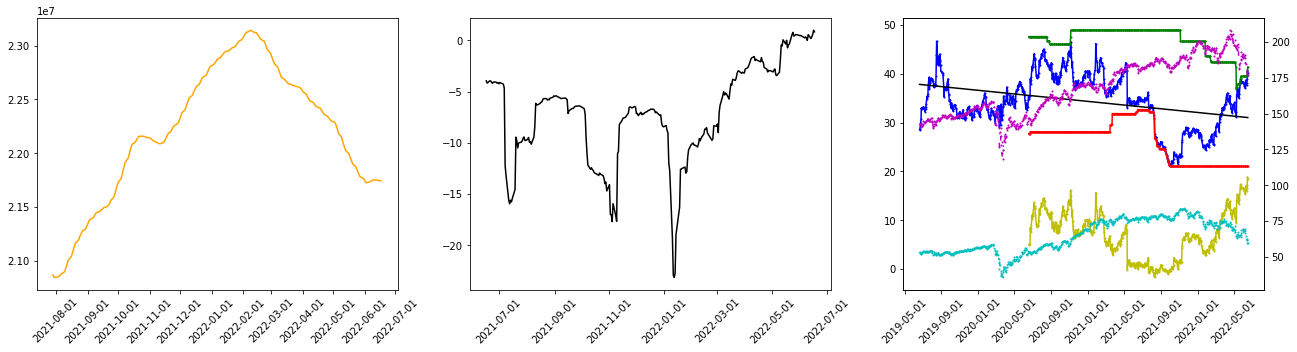

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 15.809879339831612 6.829165054824745
test cv mean error, stdev (10 folds): 15.809879339831612 6.829165054824745
sell date: 2022-07-24
expected return: 0.006391410939963005
discounted return: 0.00017698989664149956
quarter return: 1.0164148977153795


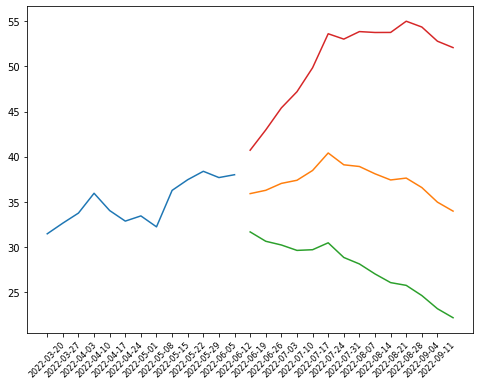

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
symbol: HRB
sector: Consumer Cyclical
Index: SP400
vol_30d_2yr: 54249330.46875
Sector 1YMF: 9.64000129699707
1YMF: 9.64000129699707
risk trend factor: 0.73141120475963
         beta currentRatio debtToEquity dividendRate dividendYield  \
HRB  0.695099        1.103     5314.905         1.08        0.0327   

    earningsGrowth     ebitda ebitdaMargins forwardPE grossMargins  \
HRB         -0.008  806428032       0.30238  8.967391        0.472   

    grossProfits heldPercentInstitutions           industry   marketCap  \
HRB   1400058000                 0.93136  Personal Services  5266601984   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
HRB          80728000          0.25066      0.3344     0.99   117.43773   

    priceToSalesTrailing12Months profitMargins quickRatio revenueGrowth  \
HRB                      1.97476       0.16063      0.971         0.039   

    revenuePerShare             sector sh

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17      33.0  32.411108  34.624444  36.837781  29.692222  4.042801   

           90d_lower  90d_upper  
2022-06-17  21.60662  37.777824

volume_factor latest_p     vol_30d_2yr  pct_2yr       adf     hurst
HRB      0.963511     33.0  54249330.46875  0.83894  0.727369  0.435637

Sector 1YMF: -359.96002197265625
Sector Volume Factor: 1.2928194874233667
Sector Risk Trend Factor: -4.72140697901556
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


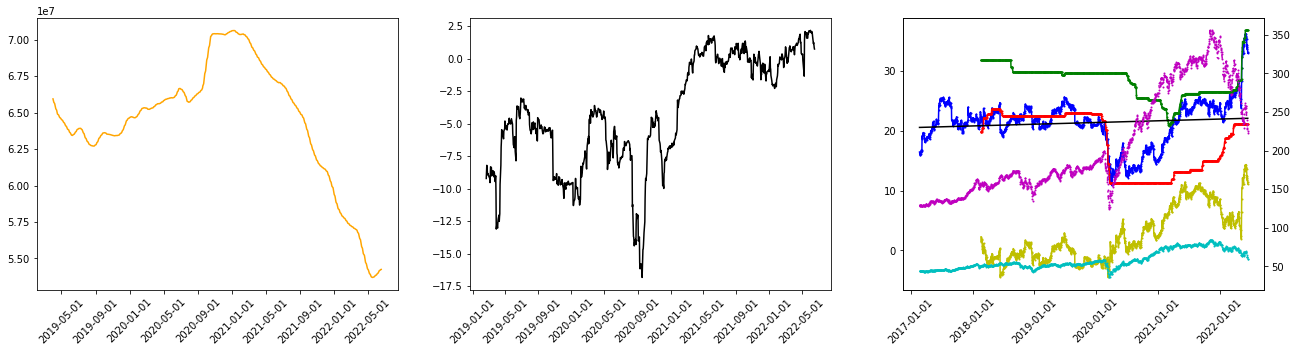

ets next 13 weeks
inner cv scores:
best model: [None, 'mul', True]
best inner cv score, sdev (11 folds): 6.810426517709371 7.071435197582785
test cv mean error, stdev (10 folds): 7.190817295452251 7.30849166023054
sell date: 2022-09-18
expected return: 0.03855437643735156
discounted return: 0.00041127719823297326
quarter return: 1.0385543764373528


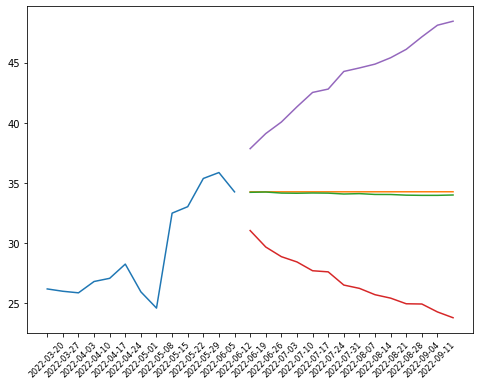

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
symbol: AZPN
sector: Technology
Index: SP400
vol_30d_2yr: 9413646.875
Sector 1YMF: 44.3599853515625
1YMF: 44.3599853515625
risk trend factor: 0.7193120754472356
     currentRatio debtToEquity earningsGrowth    ebitda ebitdaMargins  \
AZPN        1.176       40.561          0.231  27337000       0.08523   

      forwardPE grossMargins grossProfits heldPercentInstitutions  \
AZPN  34.490196      0.46746    137630000                 1.03086   

                  industry    marketCap operatingCashflow operatingMargins  \
AZPN  Software—Application  12029022208          45755000         -0.08421   

     payoutRatio pegRatio priceToBook priceToSalesTrailing12Months  \
AZPN           0     4.59   16.632854                    37.503967   

     profitMargins quickRatio revenueGrowth revenuePerShare      sector  \
AZPN      -0.07406      1.116         0.154           4.811  Technology   

     sharesOutstanding shortRatio  totalCash tot

Adj Close     21dBOLD   21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  189.199997  179.517829  194.02619  208.534551  172.712063   

             90dSDev   90d_lower   90d_upper  
2022-06-17  17.04983  138.612402  206.811723

volume_factor    latest_p  vol_30d_2yr   pct_2yr       adf     hurst
AZPN      0.677612  189.199997  9413646.875  0.817172  0.799656  0.381343

Sector 1YMF: -363.4599914550781
Sector Volume Factor: 1.1528457613891094
Sector Risk Trend Factor: -4.954471974241429
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


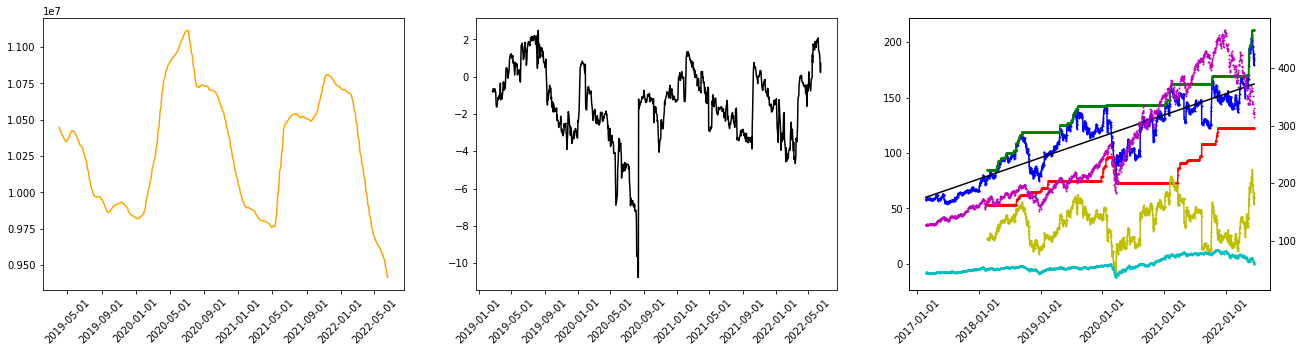

ets next 13 weeks
inner cv scores:
best model: [None, 'mul', False]
best inner cv score, sdev (11 folds): 455.88267076129983 541.1075629116453
test cv mean error, stdev (10 folds): 500.50451769770837 547.8829642390989
sell date: 2022-09-18
expected return: 0.10134786512475712
discounted return: 0.0010498415855568766
quarter return: 1.1013478651247464


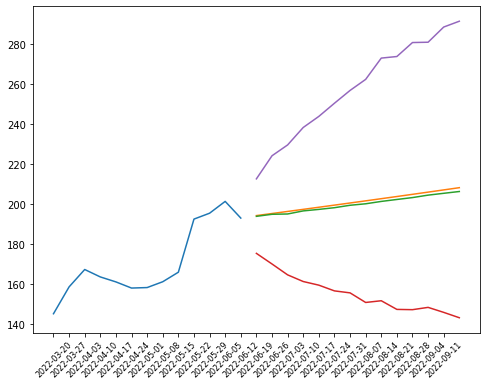

['options', ('2022-07-15', '2022-12-16')]
symbol: CEIX
sector: Energy
Index: SP600
vol_30d_2yr: 10292389.84375
Sector 1YMF: 13.870006561279297
1YMF: 13.870006561279297
risk trend factor: 0.677246429262603
          beta currentRatio debtToEquity     ebitda ebitdaMargins forwardPE  \
CEIX  2.034072        0.842       95.981  241890000       0.16404  2.585434   

     freeCashflow grossMargins grossProfits heldPercentInstitutions  \
CEIX    252373632       0.3951    422536000                 0.82577   

          industry   marketCap operatingCashflow operatingMargins payoutRatio  \
CEIX  Thermal Coal  1606689280         375780000          0.01441           0   

     priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
CEIX    2.403771                     1.089613       0.00221      0.658   

     returnOnAssets returnOnEquity revenueGrowth revenuePerShare  sector  \
CEIX        0.00507         0.0052         0.616          42.718  Energy   

     sharesOutstanding short

Adj Close    21dBOLD   21dMA-TP    21dBOLU    90dSMA   90dSDev  \
2022-06-17  46.150002  47.268535  52.341873  57.415211  46.69127  6.413974   

            90d_lower  90d_upper  
2022-06-17  33.863321  59.519218

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
CEIX      1.548727  46.150002  10292389.84375  0.762563  0.855686  0.521917

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


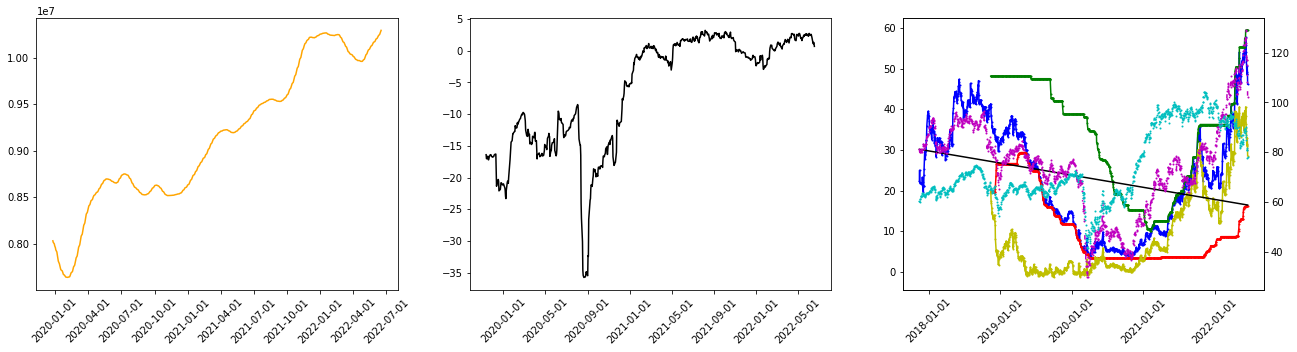

ets next 13 weeks
inner cv scores:
best model: ['add', None]
best inner cv score, sdev (11 folds): 36.976322062024906 64.10180894383853
test cv mean error, stdev (10 folds): 36.97632920692045 64.1018197865243
sell date: 2022-09-04
expected return: 0.3179430553154001
discounted return: 0.003545658589680034
quarter return: 1.384894073695398


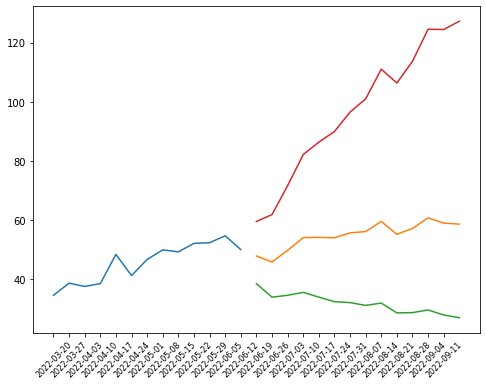

['options', ('2022-08-19',)]
symbol: PSB
sector: error
sector: error
Index: SP400
vol_30d_2yr: 2723370.8984375
Sector 1YMF: 12.849990844726562
1YMF: 12.849990844726562
risk trend factor: 0.576750069513787
Empty DataFrame
Columns: []
Index: [PSB]


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  185.919998  185.696223  186.664367  187.632511  178.031091   

              90dSDev   90d_lower   90d_upper  
2022-06-17  10.476157  157.078776  198.983405

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf    hurst
PSB      2.540601  185.919998  2723370.898438  0.951471  0.840486  0.47672

Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


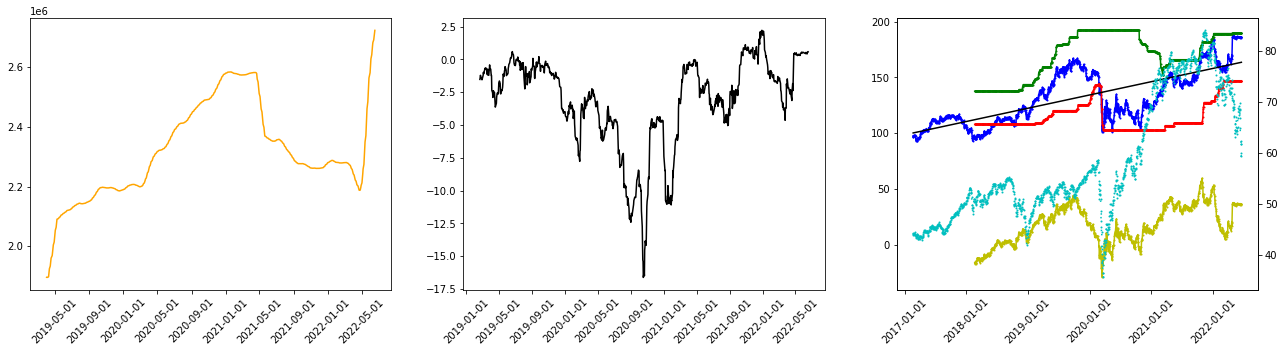

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 338.2036909355542 505.799897507174
test cv mean error, stdev (10 folds): 371.31200528684496 518.9986573566903
sell date: 2022-08-07
expected return: 0.017148258571142442
discounted return: 0.00034011556113511254
quarter return: 1.0317798406686582


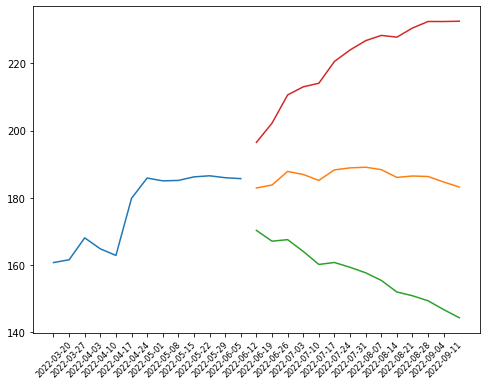

symbol: MCK
sector: Healthcare
Index: SP500
vol_30d_2yr: 22868822.0703125
Sector 1YMF: 23.670013427734375
1YMF: 23.670013427734375
risk trend factor: 0.5738185073390152
         beta currentRatio dividendRate dividendYield      ebitda  \
MCK  0.716666         0.98         1.88        0.0058  3516999936   

    ebitdaMargins  forwardPE freeCashflow grossMargins grossProfits  \
MCK       0.01368  13.643667   2778374912       0.0503  11967000000   

    heldPercentInstitutions              industry    marketCap  \
MCK                   0.898  Medical Distribution  45891629056   

    operatingCashflow operatingMargins payoutRatio pegRatio  \
MCK        4917000192           0.0105      0.2521     1.05   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
MCK                     0.178562       0.00549      0.445        0.02686   

    returnOnEquity revenueGrowth revenuePerShare      sector  \
MCK       14.01754         0.096        1655.966  Healthcare   

    sha

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  300.570007  299.443248  318.421081  337.398913  317.445859   

              90dSDev   90d_lower   90d_upper  
2022-06-17  10.066372  297.313115  337.578604

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
MCK      1.048139  300.570007  22868822.070312  0.803327  0.997242  0.461301

Sector 1YMF: -122.20997619628906
Sector Volume Factor: 1.2238851152317325
Sector Risk Trend Factor: -3.3236323632363236
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


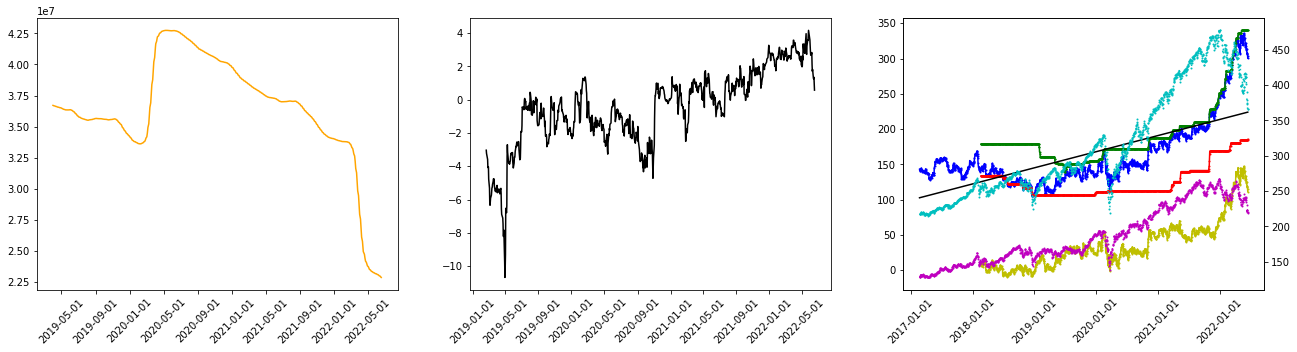

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 518.2206827971352 568.7446331297657
test cv mean error, stdev (10 folds): 542.1495065634238 591.2014883903353
sell date: 2022-06-19
expected return: 0.028401984075183757
discounted return: 0.028401984075183684
quarter return: 13.151864867613655


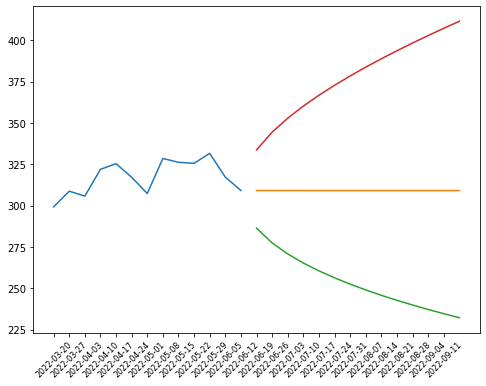

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Intangible Assets          2.130000e+09  2.385000e+09  2.797000e+09   
Capital Surplus            7.411000e+09  7.311000e+09  7.057000e+09   
Total Liab                 6.449500e+10  6.368800e+10  6.293200e+10   
Total Stockholder Equity  -1.274000e+09 -5.710000e+08 -5.290000e+08   
Minority Interest          4.870000e+08  4.840000e+08  4.910000e+08   
Other Current Liab         5.975000e+09  3.504000e+09  6.850000e+08   
Total Assets               6.370800e+10  6.360100e+10  6.289400e+10   
Common Stock               2.000000e+06  2.000000e+06  2.000000e+06   
Other Current Assets       5.940000e+09  3.470000e+09  1.230000e+08   
Retained Earnings          8.734000e+09  8.812000e+09  8.618000e+09   
Other Liab                 1.007600e+10  9.988000e+09  1.065700e+10   
Good Will                  9.462000e+09  9.473000e+09  9.520000e+09   
Treasury Stock            -1.742100e+10 -1.669600

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     30.93  30.835356  31.038381  31.241406  31.187778  0.232375   

            90d_lower  90d_upper  
2022-06-17  30.723027  31.652528

volume_factor latest_p     vol_30d_2yr   pct_2yr       adf     hurst
GCP       1.87078    30.93  8243886.328125  0.913628  0.155232  0.442804

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


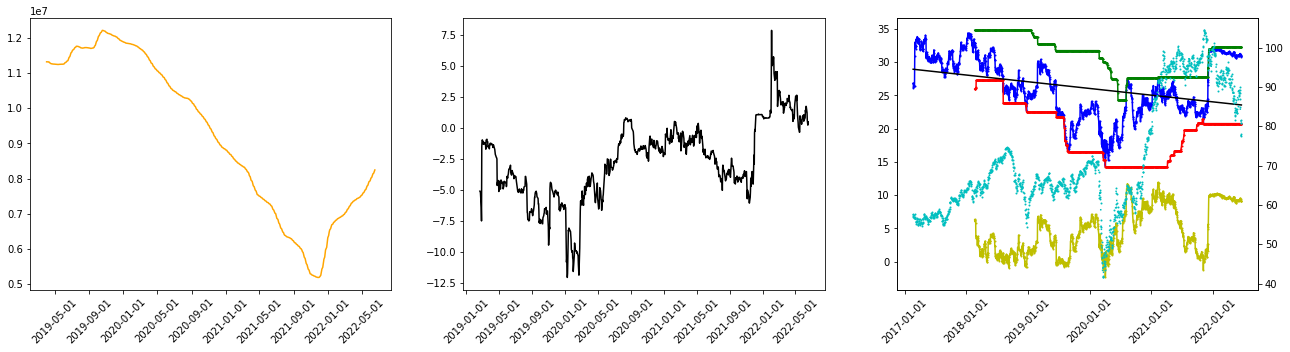

ets next 13 weeks
inner cv scores:
best model: [None, None]
best inner cv score, sdev (11 folds): 6.725378368752119 8.767570419824128
test cv mean error, stdev (10 folds): 7.2299543149586 9.04194417328711
sell date: 2022-06-19
expected return: 0.00872880060547515
discounted return: 0.008728800605475096
quarter return: 2.224573225058479


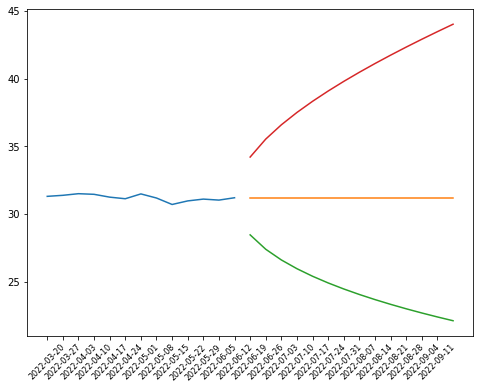

['options', ('2022-08-19', '2022-12-16')]
symbol: WRB
sector: Financial Services
Index: SP500
vol_30d_2yr: 24741280.6640625
Sector 1YMF: 2.7066688537597656
1YMF: 2.7066688537597656
risk trend factor: 0.37488481940951457
         beta currentRatio debtToEquity dividendRate dividendYield  \
WRB  0.741517        0.453       44.413         0.35        0.0049   

    earningsGrowth      ebitda ebitdaMargins  forwardPE freeCashflow  \
WRB          1.585  1969144064       0.19279  15.017057   2491864832   

    grossMargins grossProfits heldPercentInstitutions  \
WRB      0.44661   4029355000                 0.69611   

                          industry    marketCap operatingCashflow  \
WRB  Insurance—Property & Casualty  18677542912        2350679040   

    operatingMargins payoutRatio pegRatio priceToBook  \
WRB          0.18096        0.07     1.94    2.720776   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
WRB                     1.828621       0.13546   

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     66.82  65.019435  68.896032  72.772628  67.946191  1.725853   

            90d_lower  90d_upper  
2022-06-17  64.494485  71.397896

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
WRB      1.220256    66.82  24741280.664062  0.845794  0.942554  0.452599

Sector 1YMF: -72.2699966430664
Sector Volume Factor: 1.2707168073107045
Sector Risk Trend Factor: -4.617890709055871
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


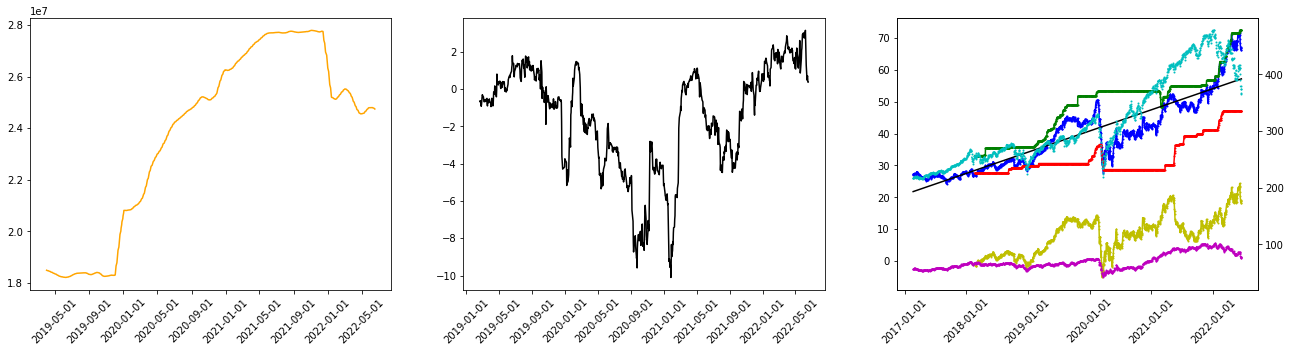

ets next 13 weeks
inner cv scores:
best model: ['add', None]
best inner cv score, sdev (11 folds): 36.39137190779945 68.87309451333526
test cv mean error, stdev (10 folds): 39.758058374202825 71.36647055436109
sell date: 2022-07-17
expected return: 0.04292055199189668
discounted return: 0.0014501884571076484
quarter return: 1.142616366753765


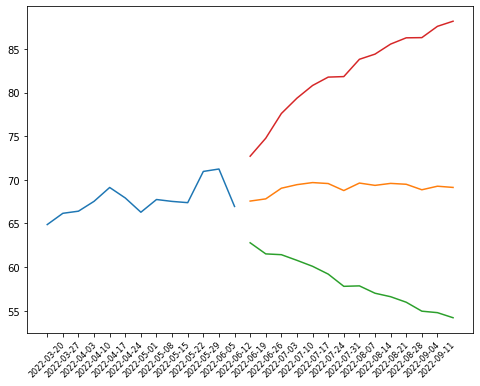

['options', ('2022-07-15',)]
['sustainability',                            Value
2022-5                          
palmOil                    False
controversialWeapons       False
gambling                   False
socialScore                 7.83
nuclear                    False
furLeather                 False
alcoholic                  False
gmo                        False
catholic                   False
socialPercentile            None
peerCount                     96
governanceScore            12.16
environmentPercentile       None
animalTesting              False
tobacco                    False
totalEsg                   21.95
highestControversy             1
esgPerformance          AVG_PERF
coal                       False
pesticides                 False
adult                      False
percentile                 31.22
peerGroup              Insurance
smallArms                  False
environmentScore            1.95
governancePercentile        None
militaryContract           F

Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-17  164.020004  159.077845  165.278412  171.47898  162.282857   

             90dSDev   90d_lower   90d_upper  
2022-06-17  5.027495  152.227867  172.337847

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
FCN      0.694756  164.020004  6853053.320312  0.888589  0.922824  0.404937

Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


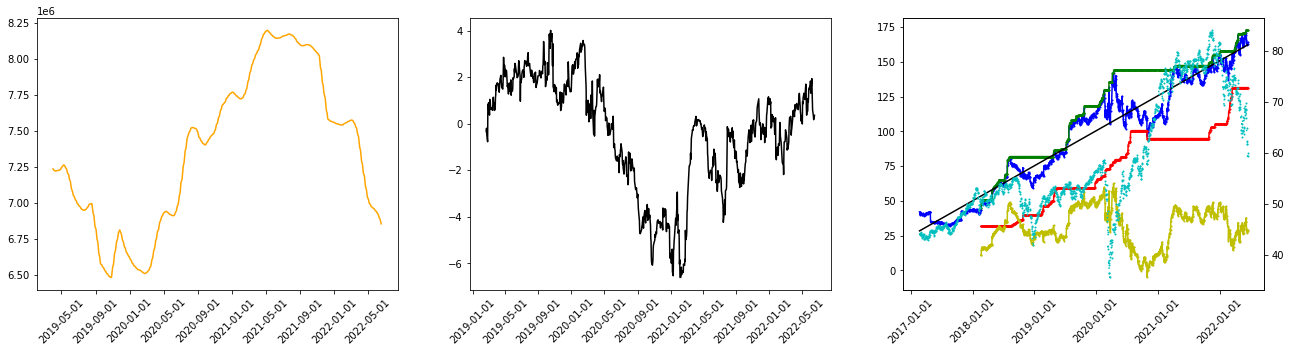

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 221.9363996832125 99.19003381369951
test cv mean error, stdev (10 folds): 216.74437087831566 102.59621043317205
sell date: 2022-09-04
expected return: 0.12937876716759217
discounted return: 0.0015610597253727931
quarter return: 1.154313175112898


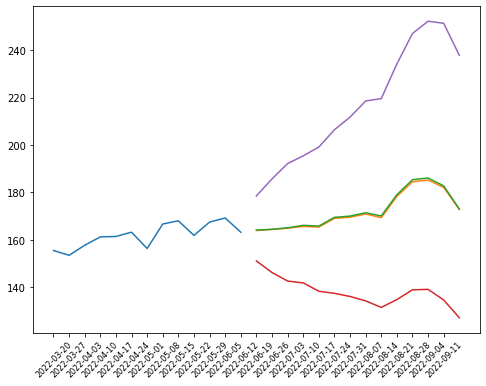

symbol: XOM
sector: Energy
Index: SP500
vol_30d_2yr: 552640281.25
Sector 1YMF: 9.1300048828125
1YMF: 9.1300048828125
risk trend factor: 0.34741268291096833
         beta currentRatio debtToEquity dividendRate dividendYield  \
XOM  1.040834        1.072       26.929         3.52        0.0409   

    earningsGrowth       ebitda ebitdaMargins forwardPE freeCashflow  \
XOM          1.003  53895000064       0.17427  9.558269  31484874752   

    grossMargins grossProfits heldPercentInstitutions              industry  \
XOM      0.31806  90045000000                 0.56863  Oil & Gas Integrated   

        marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
XOM  362840784896       53653000192          0.10859      0.5804     0.32   

    priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
XOM    2.143942                     1.173221       0.08339      0.739   

    returnOnAssets returnOnEquity revenueGrowth revenuePerShare  sector  \
XOM        0.06097    

Adj Close    21dBOLD   21dMA-TP     21dBOLU     90dSMA   90dSDev  \
2022-06-17  86.120003  88.433461  96.553809  104.674158  88.917204  6.448671   

            90d_lower   90d_upper  
2022-06-17  76.019861  101.814547

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
XOM      1.153813  86.120003  552640281.25  0.738786  0.784328  0.530974

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


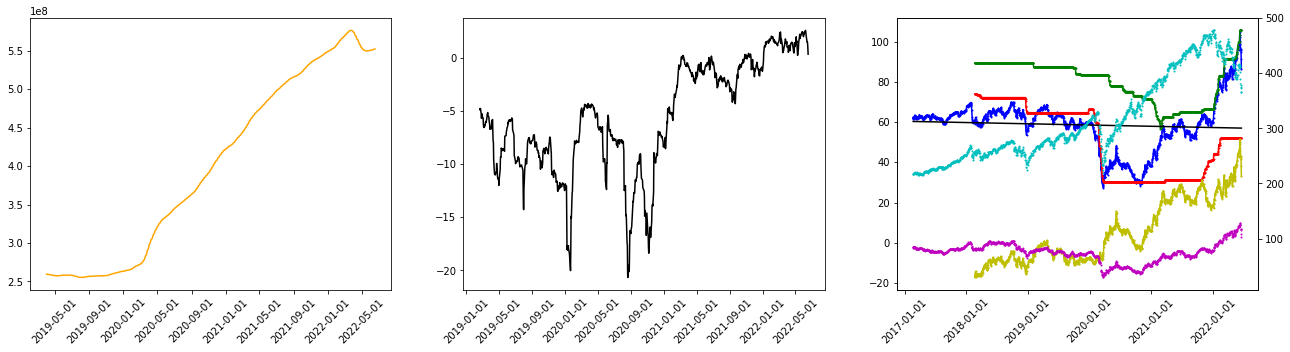

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 91.49524534369253 82.24235842155166
test cv mean error, stdev (10 folds): 100.12742404067721 81.36662053659578
sell date: 2022-09-11
expected return: 0.2361151748872659
discounted return: 0.0024969184539533895
quarter return: 1.2578830420178908


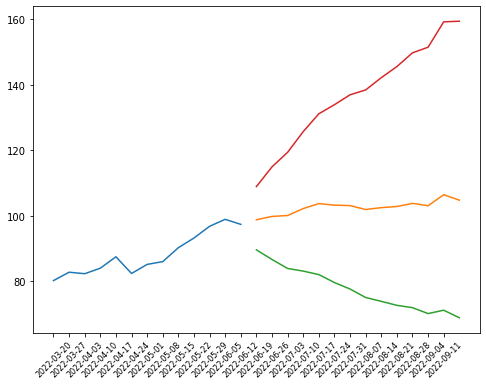

['options', ('2022-07-15', '2023-01-20', '2024-01-19', '2026-02-21')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           9.82
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       8.14
environmentPercentile                 None
animalTesting                         True
tobacco                              False
totalEsg                             36.46
highestControversy                       3
esgPerformance                    OUT_PERF
coal                                 False
pesticid

Adj Close   21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  94.790001  94.21236  94.956032  95.699705  88.233333  5.546632   

            90d_lower  90d_upper  
2022-06-17  77.140069  99.326598

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MANT      2.782348  94.790001  4428022.265625  0.833671  0.571232  0.363702

Sector 1YMF: -363.4599914550781
Sector Volume Factor: 1.1528457613891094
Sector Risk Trend Factor: -4.954471974241429
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


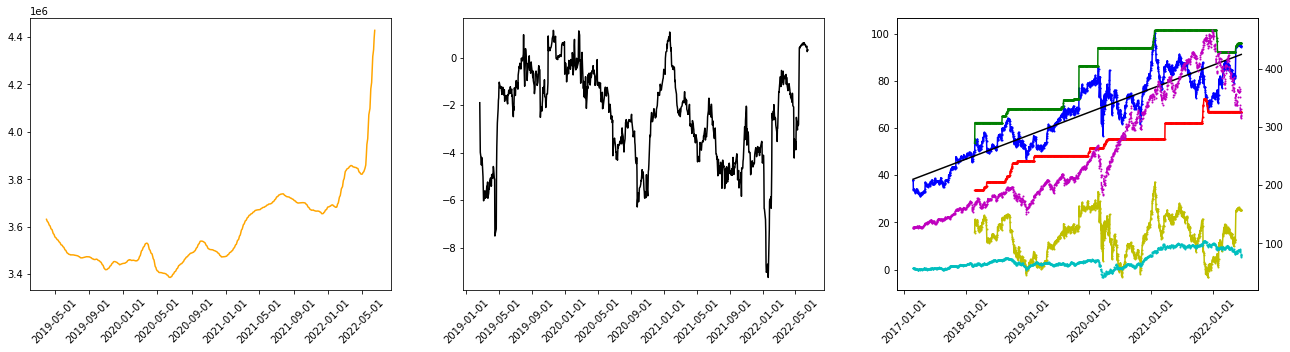

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 60.3856226320546 35.3162792997746
test cv mean error, stdev (10 folds): 57.005995059868496 35.30329432505976
sell date: 2022-09-18
expected return: -0.0006459376271060396
discounted return: -7.0233050614154635e-06
quarter return: 0.9993540623728944


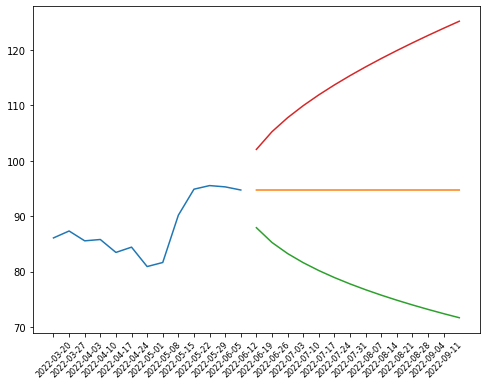

['options', ('2022-08-19',)]
symbol: SM
sector: Energy
Index: SP600
vol_30d_2yr: 85332599.609375
Sector 1YMF: 6.969999313354492
1YMF: 6.969999313354492
risk trend factor: 0.3050327621527311
        beta currentRatio debtToEquity dividendRate dividendYield      ebitda  \
SM  5.488235        0.717       93.916         0.02        0.0006  1315937024   

   ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
SM       0.45427  8.413136    570353344       0.8671   2136878000   

   heldPercentInstitutions       industry   marketCap operatingCashflow  \
SM                 0.88028  Oil & Gas E&P  4823732224        1396240000   

   operatingMargins payoutRatio pegRatio priceToBook  \
SM          0.18012       0.007     0.12    2.946938   

   priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
SM                      1.66518       0.11608        0.7        0.06264   

   returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
SM        0.1731

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  39.709999  36.543497  46.618254  56.693011  41.080159  5.405133   

            90d_lower  90d_upper  
2022-06-17  30.269893  51.890424

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
SM      0.640686  39.709999  85332599.609375  0.715458  0.803847  0.471215

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


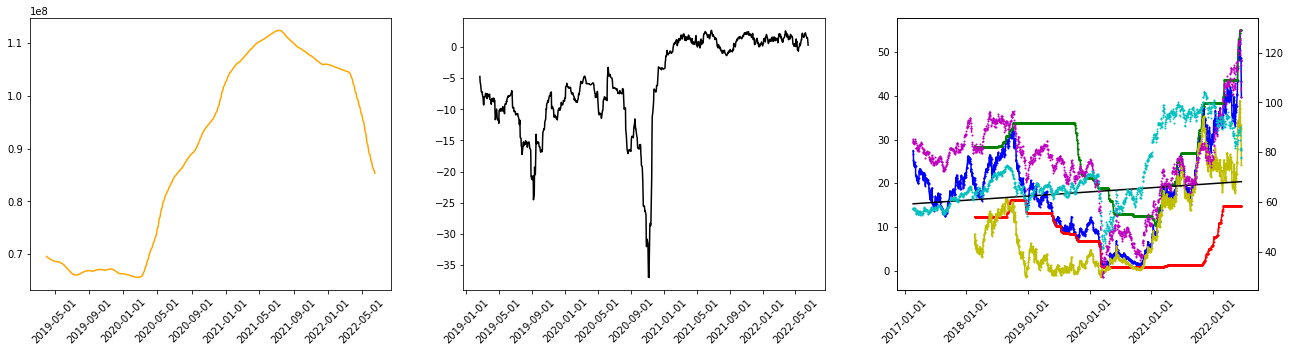

ets next 13 weeks
inner cv scores:
best model: [None, None]
best inner cv score, sdev (11 folds): 42.376101369640985 58.106739019848455
test cv mean error, stdev (10 folds): 46.45057636670336 59.42573196818282
sell date: 2022-06-19
expected return: 0.23344907668740075
discounted return: 0.23344907668740067
quarter return: 241630987.13855398


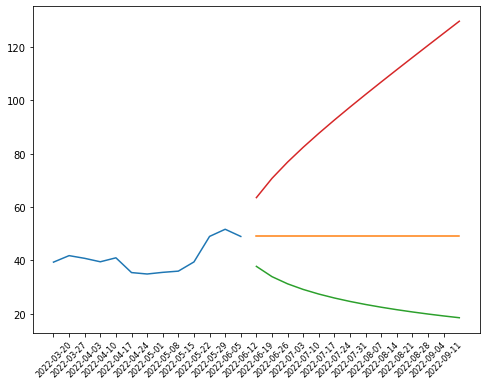

['quarterly_balance_sheet',                              2022-03-31    2021-12-31    2021-09-30  \
Capital Surplus            1.844478e+09  1.840228e+09  1.838620e+09   
Total Liab                 3.280672e+09  3.170846e+09  3.425061e+09   
Total Stockholder Equity   2.115109e+09  2.063131e+09  1.636899e+09   
Deferred Long Term Liab    2.300000e+06  2.700000e+06  3.100000e+06   
Other Current Liab         5.381270e+08  4.047460e+08  5.520440e+08   
Total Assets               5.395781e+09  5.233977e+09  5.061960e+09   
Common Stock               1.219000e+06  1.219000e+06  1.215000e+06   
Other Current Assets       9.649000e+06  2.409500e+07  2.451400e+07   
Retained Earnings          2.820790e+08  2.345330e+08 -1.903670e+08   
Other Liab                 2.415590e+08  1.809150e+08  2.438640e+08   
Treasury Stock            -1.266700e+07 -1.284900e+07 -1.256900e+07   
Other Assets               5.397300e+07  2.576600e+07  6.020700e+07   
Cash                       4.198870e+08  3.327160

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-17      45.0  43.432974  51.035714  58.638454  43.785397  6.19363   

            90d_lower  90d_upper  
2022-06-17  31.398138  56.172656

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
DINO      1.094012     45.0  51433534.179688  0.676181  0.488602  0.560442

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


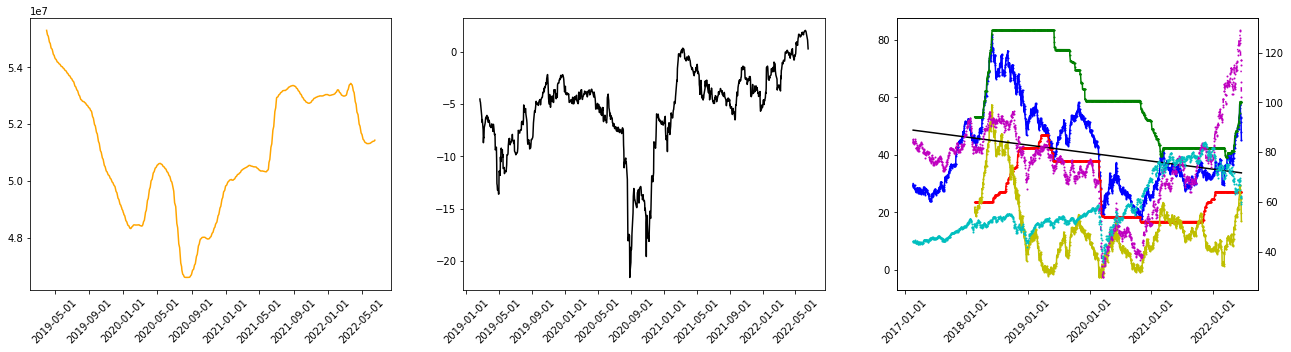

ets next 13 weeks
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 68.74363593556068 61.18345174913362
test cv mean error, stdev (10 folds): 74.39993247179872 61.366318003884665
sell date: 2022-09-18
expected return: 0.2808344011369161
discounted return: 0.0026939672414314497
quarter return: 1.2808344011369226


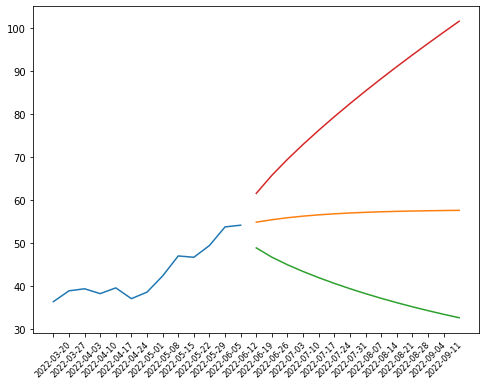

symbol: PLAB
sector: Technology
Index: SP600
vol_30d_2yr: 10786618.9453125
Sector 1YMF: 2.2899999618530273
1YMF: 2.2899999618530273
risk trend factor: 0.26412914530661946
          beta currentRatio debtToEquity earningsGrowth     ebitda  \
PLAB  0.980357        3.417        7.842          1.889  233440992   

     ebitdaMargins  forwardPE freeCashflow grossMargins grossProfits  \
PLAB       0.31281  10.108109     90646496      0.30828    167044000   

     heldPercentInstitutions                             industry   marketCap  \
PLAB                 0.90554  Semiconductor Equipment & Materials  1385207808   

     operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
PLAB         195842000          0.19934           0     1.19     1.62538   

     priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
PLAB                     1.856183       0.12032      2.814        0.07156   

     returnOnEquity revenueGrowth revenuePerShare      sector  \
PLAB   

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     19.15  14.678059  19.802381  24.926703  17.249841  2.549321   

            90d_lower  90d_upper  
2022-06-17  12.151199  22.348483

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
PLAB      2.163783    19.15  10786618.945312  0.729861  0.736899  0.332818

Sector 1YMF: -363.4599914550781
Sector Volume Factor: 1.1528457613891094
Sector Risk Trend Factor: -4.954471974241429
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


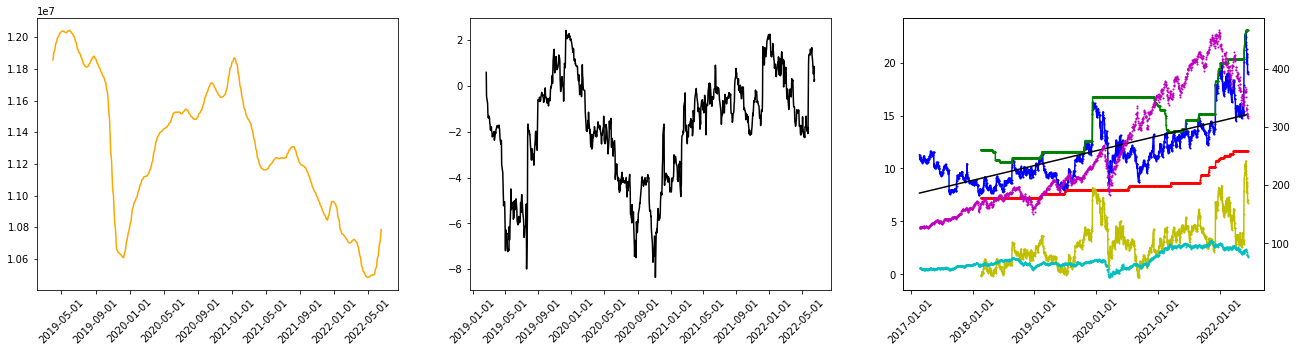

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 3.3346583318115752 2.7550716521280796
test cv mean error, stdev (10 folds): 3.3074930603752497 2.8881385568789124
sell date: 2022-06-26
expected return: 0.06532945727658211
discounted return: 0.00794188337970958
quarter return: 2.070452453781259


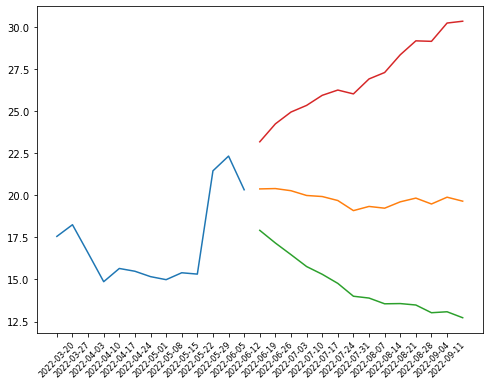

['options', ('2022-12-16',)]
symbol: MPC
sector: Energy
Index: SP500
vol_30d_2yr: 141817662.109375
Sector 1YMF: 6.860008239746094
1YMF: 6.860008239746094
risk trend factor: 0.20927420668724137
        beta currentRatio debtToEquity dividendRate dividendYield      ebitda  \
MPC  1.75499        1.449       89.568         2.32        0.0266  8572000256   

    ebitdaMargins  forwardPE freeCashflow grossMargins grossProfits  \
MPC       0.06306  11.191026  18097874944      0.08778  10443000000   

    heldPercentInstitutions                        industry    marketCap  \
MPC                 0.79745  Oil & Gas Refining & Marketing  47223455744   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
MPC        6418999808           0.0386      0.5472     0.35     1.98454   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
MPC                     0.347428       0.07964      1.045        0.03693   

    returnOnEquity revenueGrowth revenuePerS

Adj Close    21dBOLD    21dMA-TP     21dBOLU     90dSMA   90dSDev  \
2022-06-17  87.290001  89.493723  102.090159  114.686595  92.392331  8.807067   

            90d_lower   90d_upper  
2022-06-17  74.778196  110.006465

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
MPC      1.221452  87.290001  141817662.109375  0.691764  0.549549  0.514371

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


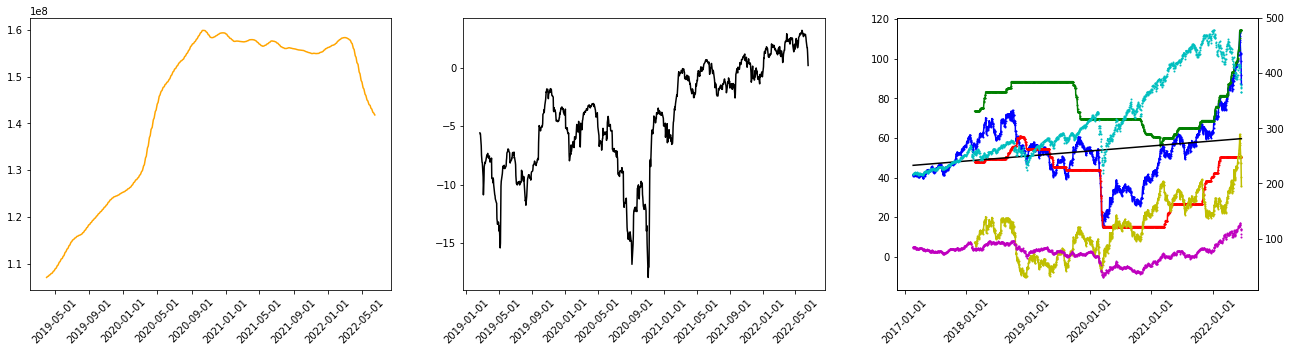

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', False]
best inner cv score, sdev (11 folds): 140.02382788023675 139.69178702403212
test cv mean error, stdev (10 folds): 136.3540993080901 146.00360280846877
sell date: 2022-09-11
expected return: 0.38235983545152613
discounted return: 0.003816583079964575
quarter return: 1.419716627023713


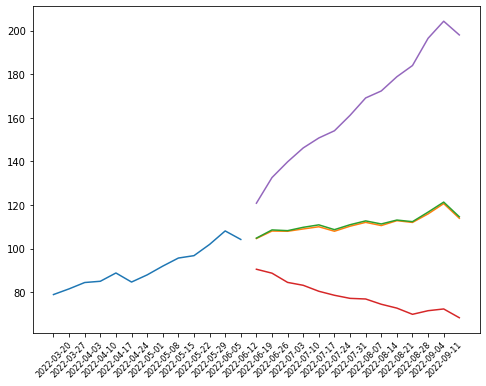

['options', ('2022-07-15', '2022-09-16', '2023-01-20', '2024-01-19')]
['sustainability',                                       Value
2022-5                                     
palmOil                               False
controversialWeapons                  False
gambling                              False
socialScore                            7.01
nuclear                               False
furLeather                            False
alcoholic                             False
gmo                                   False
catholic                              False
socialPercentile                       None
peerCount                                39
governanceScore                        5.87
environmentPercentile                  None
animalTesting                         False
tobacco                               False
totalEsg                              28.78
highestControversy                        3
esgPerformance                     AVG_PERF
coal                           

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  290.899994  284.096885  302.232381  320.367877  296.315556   

             90dSDev   90d_lower   90d_upper  
2022-06-17  9.524706  277.266144  315.364968

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
LLY      0.967658  290.899994  70977344.335938  0.829733  0.979741  0.407173

Sector 1YMF: -122.20997619628906
Sector Volume Factor: 1.2238851152317325
Sector Risk Trend Factor: -3.3236323632363236
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


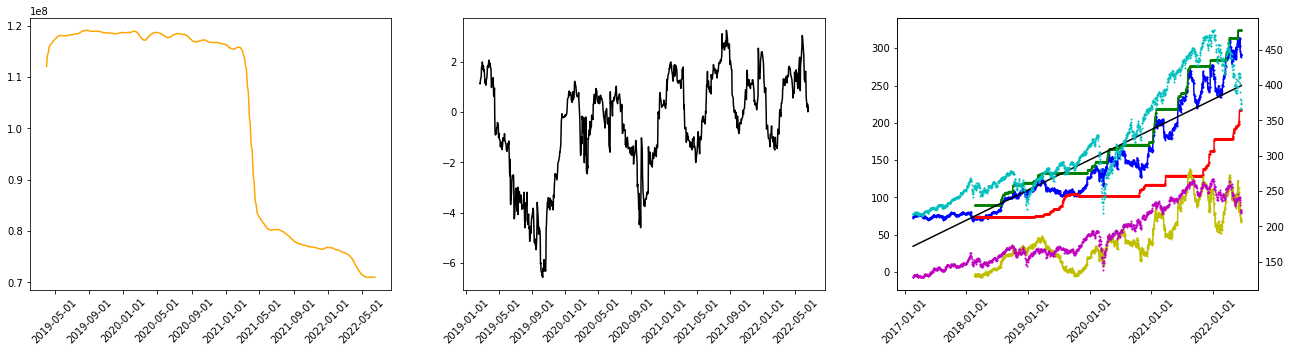

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 459.63043627228745 543.8838721179123
test cv mean error, stdev (10 folds): 480.5259051560421 566.2048035395488
sell date: 2022-08-28
expected return: 0.12533084380836684
discounted return: 0.0016644410526294173
quarter return: 1.165326472107341


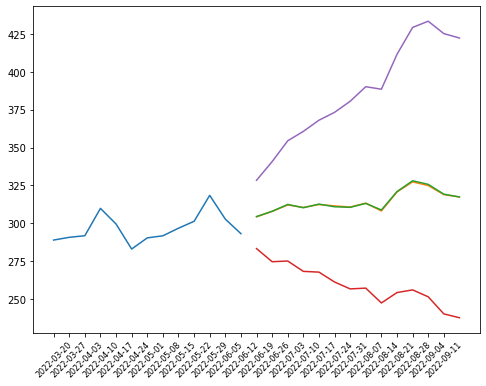

['quarterly_balance_sheet',                                     2022-03-31    2021-12-31    2021-09-30  \
Intangible Assets                 7.482400e+09  7.691900e+09  7.887700e+09   
Capital Surplus                   6.656300e+09  6.833400e+09  6.758000e+09   
Total Liab                        3.745730e+10  3.965120e+10  4.023290e+10   
Total Stockholder Equity          9.330800e+09  8.979200e+09  7.757000e+09   
Minority Interest                 1.312000e+08  1.756000e+08  1.971000e+08   
Other Current Liab                3.135000e+09  3.814100e+09  2.513000e+09   
Total Assets                      4.691930e+10  4.880600e+10  4.818700e+10   
Common Stock                      5.941000e+08  5.963000e+08  5.982000e+08   
Other Current Assets              3.880000e+07  9.900000e+06  5.500000e+06   
Retained Earnings                 9.369400e+09  8.958500e+09  9.639400e+09   
Other Liab                        8.875200e+09  8.674200e+09  1.099380e+10   
Good Will                         3.

Adj Close     21dBOLD    21dMA-TP     21dBOLU     90dSMA  \
2022-06-17  112.440002  114.972524  130.979841  146.987158  116.34127   

              90dSDev  90d_lower   90d_upper  
2022-06-17  14.566462  87.208346  145.474193

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
VLO        1.3872  112.440002  90552079.101562  0.691389  0.569718  0.530999

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


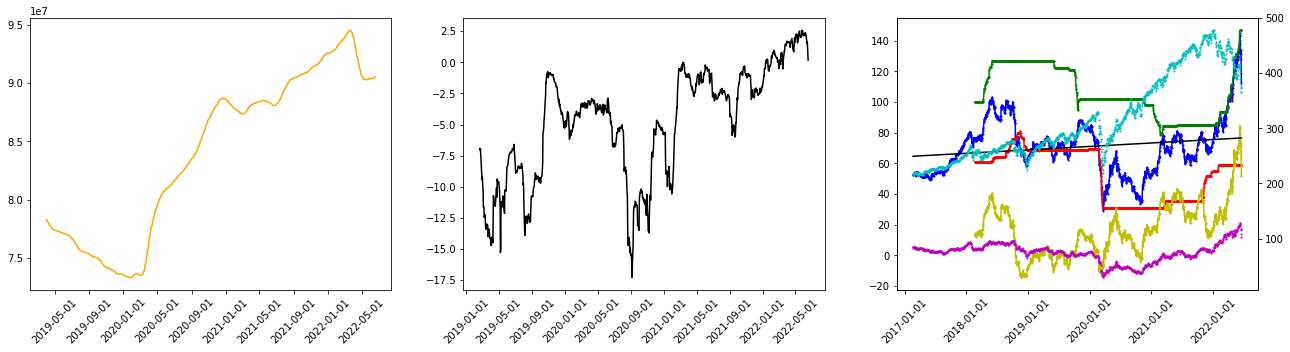

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', False]
best inner cv score, sdev (11 folds): 298.2473901768996 228.50628816714766
test cv mean error, stdev (10 folds): 310.91454801965676 235.94980352018624
sell date: 2022-09-11
expected return: 0.44081876494495903
discounted return: 0.004305849985525967
quarter return: 1.4848114331385551


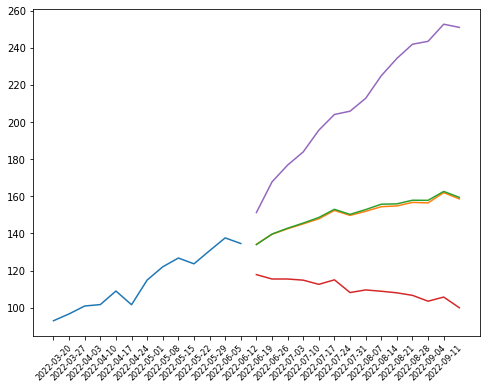

['options', ('2023-01-20', '2024-01-19')]
['sustainability',                                       Value
2022-5                                     
palmOil                               False
controversialWeapons                  False
gambling                              False
socialScore                            7.23
nuclear                               False
furLeather                            False
alcoholic                             False
gmo                                   False
catholic                              False
socialPercentile                       None
peerCount                                39
governanceScore                        4.98
environmentPercentile                  None
animalTesting                         False
tobacco                               False
totalEsg                              30.94
highestControversy                        3
esgPerformance                     OUT_PERF
coal                                  False
pesticides     

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  39.220001  39.703868  46.051746  52.399625  42.946032  3.294685   

            90d_lower  90d_upper  
2022-06-17  36.356662  49.535402

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
APA      0.999608  39.220001  204531248.4375  0.713933  0.302651  0.445144

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


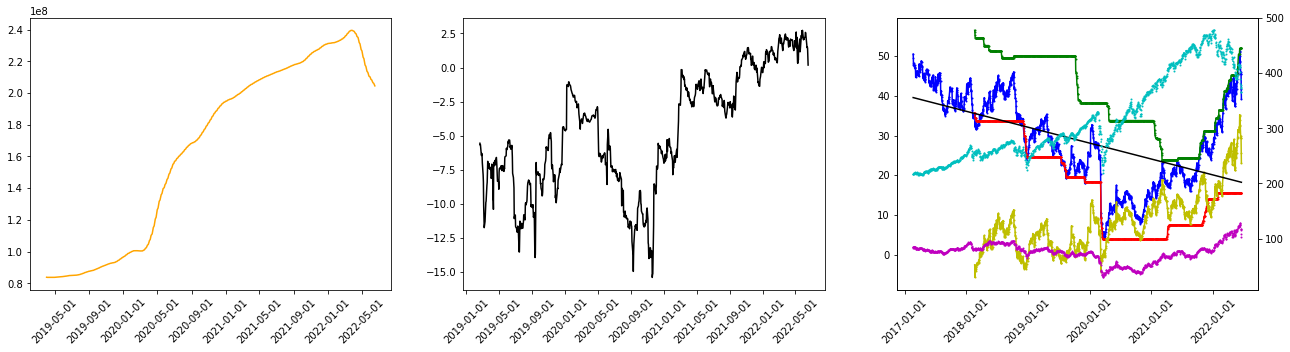

ets next 13 weeks
inner cv scores:
best model: [None, 'add', False]
best inner cv score, sdev (11 folds): 46.85248669350492 42.246404781358315
test cv mean error, stdev (10 folds): 51.13206818418586 41.97346296601979
sell date: 2022-06-19
expected return: 0.18413822832352542
discounted return: 0.18413822832352533
quarter return: 5662666.440975121


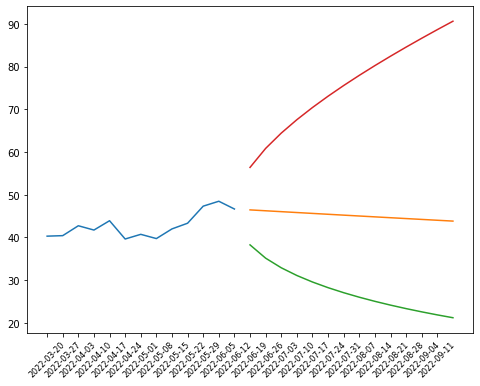

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   1.164500e+10  1.168600e+10  1.170400e+10   
Total Liab                        1.330800e+10  1.270500e+10  1.281900e+10   
Total Stockholder Equity         -1.595000e+09 -1.095000e+09 -9.640000e+08   
Minority Interest                 1.590000e+09  1.580000e+09  1.657000e+09   
Deferred Long Term Liab           5.700000e+08  5.150000e+08  5.120000e+08   
Other Current Liab                3.370000e+08  2.760000e+08  2.990000e+08   
Total Assets                      1.330300e+10  1.331000e+10  1.351200e+10   
Common Stock                      2.620000e+08  2.620000e+08  2.620000e+08   
Other Current Assets              1.550000e+08  1.020000e+08  7.600000e+07   
Retained Earnings                -9.488000e+09 -9.870000e+09 -9.757000e+09   
Other Liab                        3.744000e+09  3.673000e+09  2.626000e+09   
Treasury Stock                   -4.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-17     29.34  28.165931  31.419048  34.672164  28.426667  2.86898   

            90d_lower  90d_upper  
2022-06-17  22.688707  34.164626

volume_factor latest_p vol_30d_2yr   pct_2yr       adf     hurst
PPC      1.275425    29.34  17241312.5  0.741748  0.282386  0.556574

Sector 1YMF: -74.80001831054688
Sector Volume Factor: 1.4135920452708397
Sector Risk Trend Factor: -2.283970024749523
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


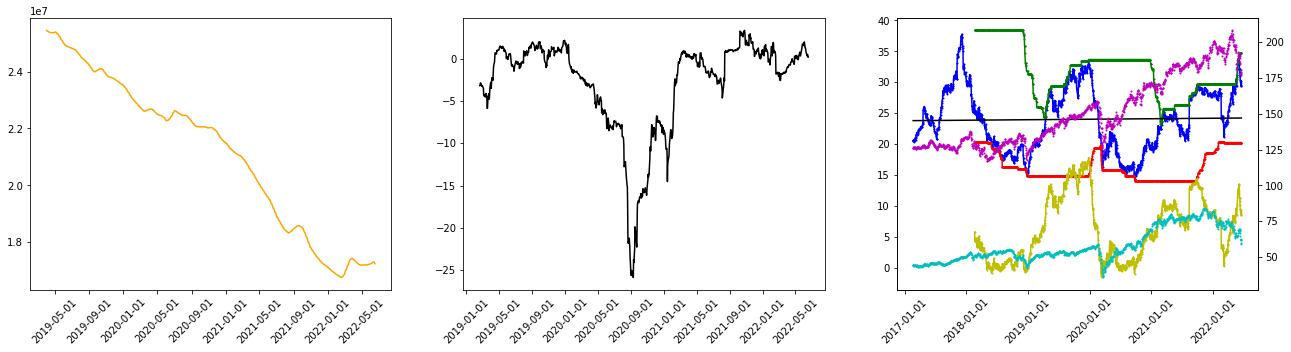

ets next 13 weeks
inner cv scores:
best model: ['add', 'mul', False]
best inner cv score, sdev (11 folds): 26.61952259828387 34.681387004200694
test cv mean error, stdev (10 folds): 27.983158956889138 36.09188747556151
sell date: 2022-07-24
expected return: 0.058044205317821965
discounted return: 0.0015685097857791597
quarter return: 1.1551033820495453


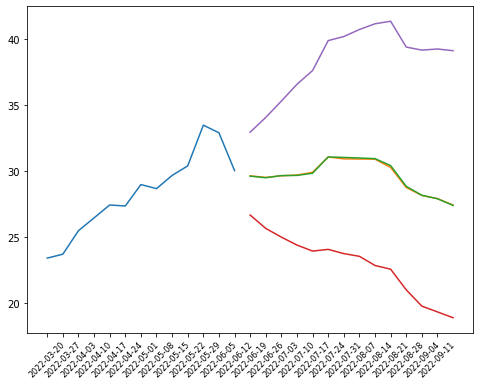

['quarterly_balance_sheet',                                     2022-03-27    2021-12-26    2021-09-26  \
Intangible Assets                 9.385640e+08  9.632430e+08  1.028664e+09   
Capital Surplus                   1.966066e+09  1.964028e+09  1.962750e+09   
Total Liab                        6.524261e+09  6.324271e+09  6.216460e+09   
Total Stockholder Equity          2.781630e+09  2.577080e+09  2.604243e+09   
Minority Interest                 1.197600e+07  1.185400e+07  1.214000e+07   
Other Current Liab                3.009220e+08  3.085060e+08  4.109530e+08   
Total Assets                      9.317867e+09  8.913205e+09  8.832843e+09   
Common Stock                      2.616000e+06  2.614000e+06  2.614000e+06   
Other Current Assets              6.858900e+07  4.054500e+07  6.656900e+07   
Retained Earnings                 1.284007e+09  1.003569e+09  9.668150e+08   
Other Liab                        4.077630e+08  4.709210e+08  5.265940e+08   
Good Will                         1.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     24.15  25.128986  29.471905  33.814823  26.957624  2.372893   

            90d_lower 90d_upper  
2022-06-17  22.211838  31.70341

volume_factor latest_p       vol_30d_2yr   pct_2yr      adf    hurst
MRO      1.000459    24.15  490057840.234375  0.691969  0.80545  0.53536

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


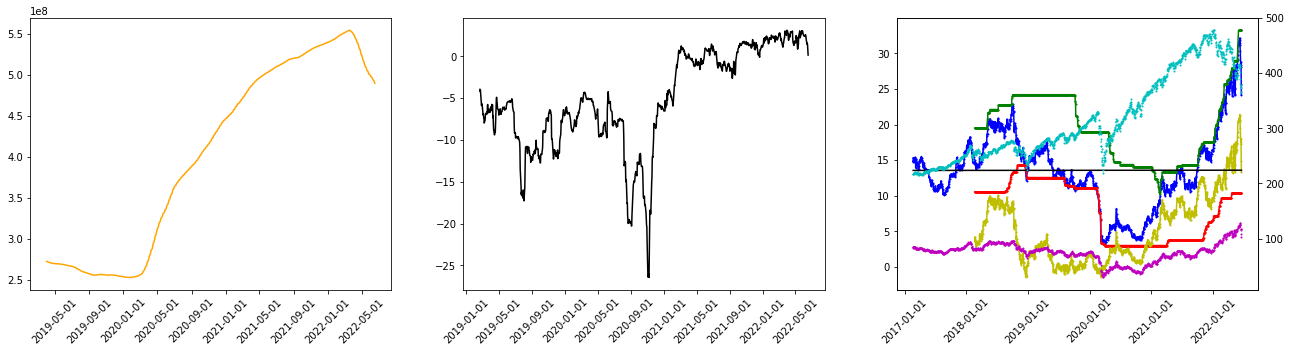

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 11.75784441657806 12.667631416131938
test cv mean error, stdev (10 folds): 12.772815210119978 12.852390886741173
sell date: 2022-08-28
expected return: 0.6156287892172689
discounted return: 0.006779557066307396
quarter return: 1.8619316819986207


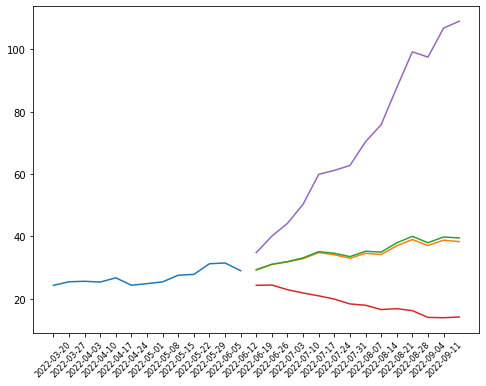

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            7.221000e+09  7.213000e+09  7.201000e+09   
Total Liab                 6.308000e+09  6.365000e+09  7.166000e+09   
Total Stockholder Equity   1.068600e+10  1.079600e+10  1.063400e+10   
Other Current Liab         3.680000e+08  4.960000e+08  5.020000e+08   
Total Assets               1.699400e+10  1.716100e+10  1.780000e+10   
Common Stock               9.370000e+08  9.370000e+08  9.370000e+08   
Other Current Assets       2.200000e+07  2.500000e+07  1.900000e+07   
Retained Earnings          7.271000e+09  6.669000e+09  6.524000e+09   
Other Liab                 6.440000e+08  6.420000e+08  6.650000e+08   
Treasury Stock            -4.743000e+09 -4.023000e+09 -4.028000e+09   
Other Assets               1.100000e+08  1.040000e+08  9.300000e+07   
Cash                       5.800000e+08  4.850000e+08  9.700000e+08   
Total Current Liabilities  1.637000e+09  1.676000

Adj Close    21dBOLD 21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     58.02  63.067854    72.56  82.052146  65.759365  6.444488   

            90d_lower  90d_upper  
2022-06-17  52.870389  78.648341

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
DVN      1.104104    58.02  237878397.65625  0.701688  0.885466  0.540317

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


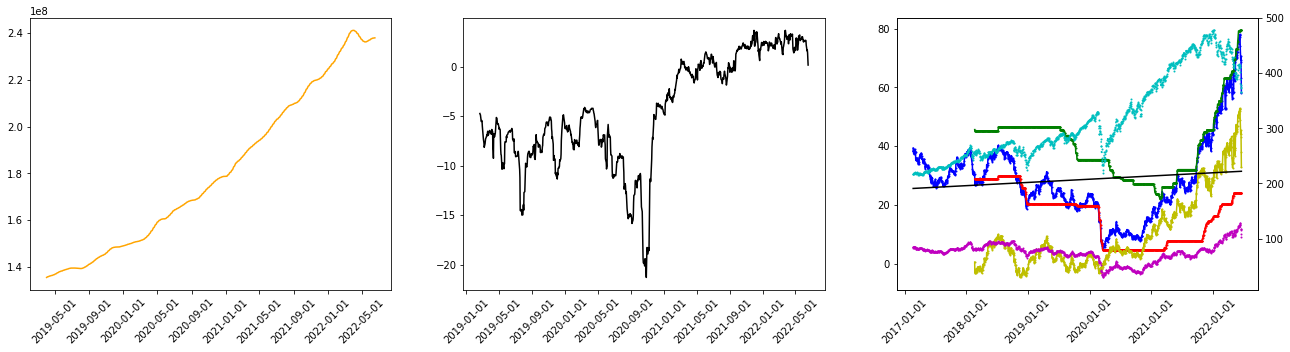

ets next 13 weeks
inner cv scores:
best model: [None, 'add', False]
best inner cv score, sdev (11 folds): 67.08034661109826 86.6725124718212
test cv mean error, stdev (10 folds): 73.27584410585618 88.55005929559908
sell date: 2022-09-18
expected return: 0.477348348144283
discounted return: 0.004250844361888051
quarter return: 1.4773483481442684


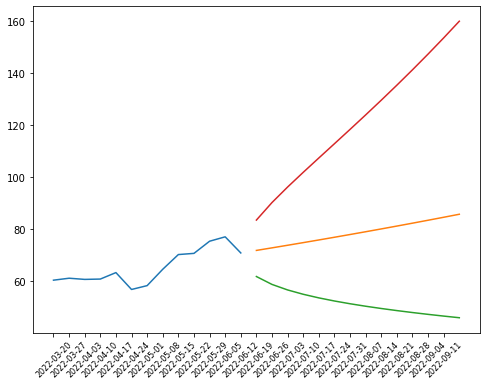

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   7.636000e+09  8.206000e+09  8.189000e+09   
Total Liab                        1.162600e+10  1.199600e+10  1.153000e+10   
Total Stockholder Equity          9.262000e+09  8.924000e+09  8.399000e+09   
Minority Interest                 1.370000e+08  1.370000e+08  1.360000e+08   
Other Current Liab                2.545000e+09  2.940000e+09  2.554000e+09   
Total Assets                      2.102500e+10  2.105700e+10  2.006500e+10   
Common Stock                      6.600000e+07  6.800000e+07  6.800000e+07   
Other Current Assets              5.240000e+08  4.860000e+08  5.030000e+08   
Retained Earnings                 1.692000e+09  7.500000e+08  2.430000e+08   
Other Liab                        1.805000e+09  1.743000e+09  1.698000e+09   
Good Will                         7.530000e+08  7.530000e+08  7.530000e+08   
Treasury Stock                   -1.

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  219.380005  194.589531  219.462223  244.334915  195.494921   

              90dSDev   90d_lower   90d_upper  
2022-06-17  19.533079  156.428764  234.561078

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
UTHR      1.481235  219.380005  8360250.78125  0.878858  0.826178  0.414478

Sector 1YMF: -122.20997619628906
Sector Volume Factor: 1.2238851152317325
Sector Risk Trend Factor: -3.3236323632363236
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


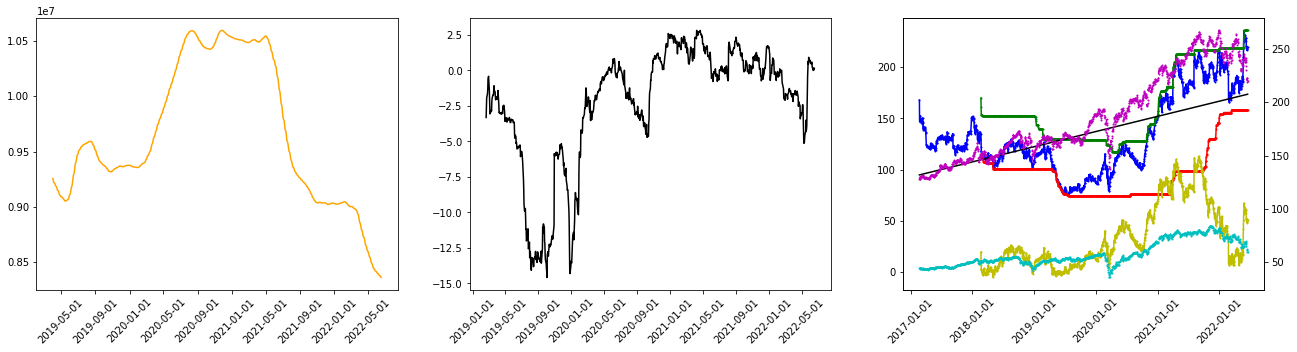

ets next 13 weeks
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 581.052066365091 434.30316162788483
test cv mean error, stdev (10 folds): 606.4042953716666 447.67296522383276
sell date: 2022-08-28
expected return: 0.04383961346197422
discounted return: 0.0006044903871480489
quarter return: 1.0571708320889197


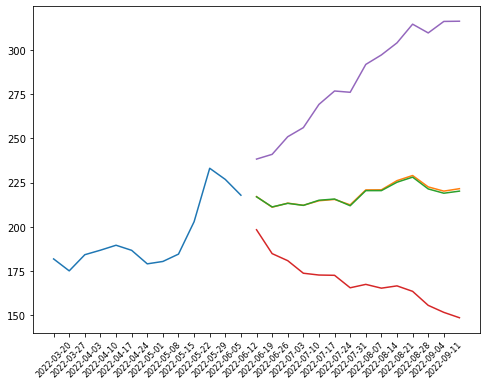

['options', ('2022-08-19',)]
['sustainability',                                  Value
2022-5                                
palmOil                          False
controversialWeapons             False
gambling                         False
socialScore                      16.62
nuclear                          False
furLeather                       False
alcoholic                        False
gmo                              False
catholic                         False
socialPercentile                  None
peerCount                           83
governanceScore                   7.41
environmentPercentile             None
animalTesting                     True
tobacco                          False
totalEsg                         25.71
highestControversy                   1
esgPerformance                AVG_PERF
coal                             False
pesticides                       False
adult                            False
percentile                       45.83
peerGroup       

Adj Close    21dBOLD   21dMA-TP    21dBOLU    90dSMA   90dSDev  \
2022-06-17      28.5  25.427799  27.012222  28.596646  26.44746  1.162243   

            90d_lower  90d_upper  
2022-06-17  24.122974  28.771947

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
VIVO      0.591657     28.5  11730103.320312  0.878325  0.565494  0.431737

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


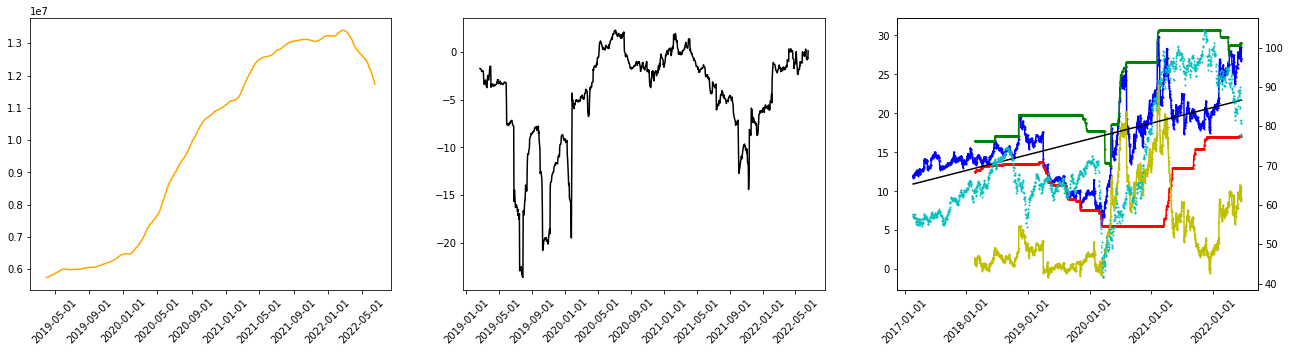

ets next 13 weeks
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 16.179814837641146 14.97126725367644
test cv mean error, stdev (10 folds): 17.70093452925235 14.869460950444271
sell date: 2022-09-18
expected return: 0.051296322828618374
discounted return: 0.0005438869382852207
quarter return: 1.051296322828615


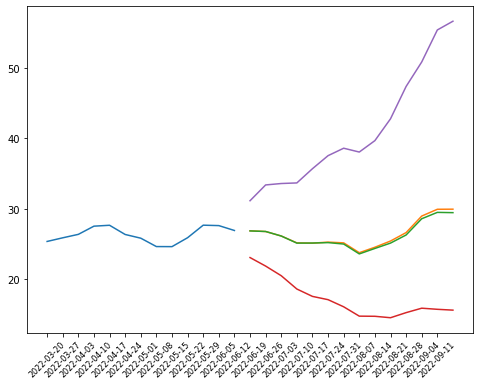

['options', ('2022-07-15',)]
symbol: ROCC
sector: Energy
Index: SP600
vol_30d_2yr: 11962556.0546875
Sector 1YMF: 2.549999237060547
1YMF: 2.549999237060547
risk trend factor: 0.10821588524114191
          beta currentRatio debtToEquity     ebitda ebitdaMargins forwardPE  \
ROCC  2.866152        0.497       80.978  323780000       0.45632  3.112757   

     freeCashflow grossMargins grossProfits heldPercentInstitutions  \
ROCC    111158752       0.9232    508729000                 0.83062   

           industry  marketCap operatingCashflow operatingMargins payoutRatio  \
ROCC  Oil & Gas E&P  800399808         390172992          0.23271           0   

     pegRatio priceToBook priceToSalesTrailing12Months profitMargins  \
ROCC     0.13    2.546801                     1.128053       0.06175   

     quickRatio returnOnAssets returnOnEquity revenueGrowth revenuePerShare  \
ROCC      0.404        0.08139        0.19205         1.903           39.08   

      sector sharesOutstanding shortR

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     37.82  32.048974  43.306825  54.564677  37.893968  5.380754   

            90d_lower  90d_upper  
2022-06-17  27.132461  48.655476

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
ROCC      1.213679    37.82  11962556.054688  0.666102  0.594188  0.577777

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


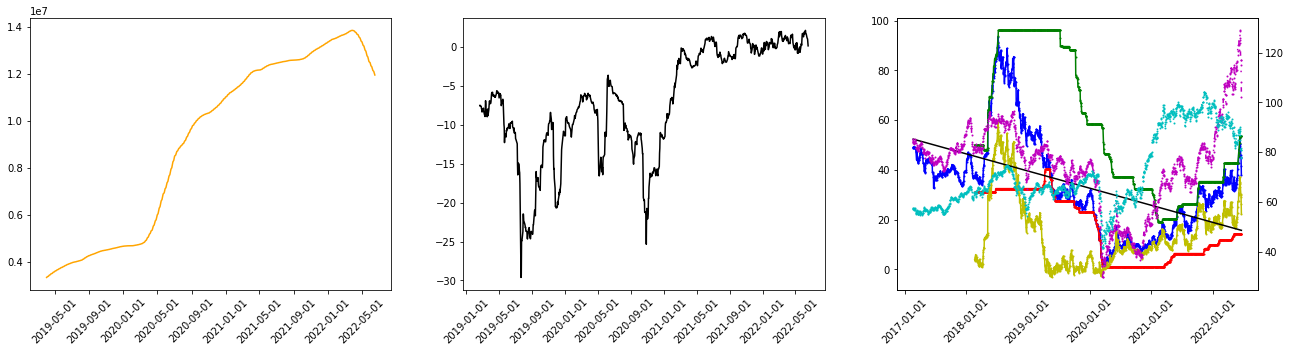

ets next 13 weeks
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 77.56947848579797 62.68356673287805
test cv mean error, stdev (10 folds): 80.28001059170666 65.12556527221653
sell date: 2022-08-07
expected return: 0.47100754960841223
discounted return: 0.0077488193841972475
quarter return: 2.0342832305314826


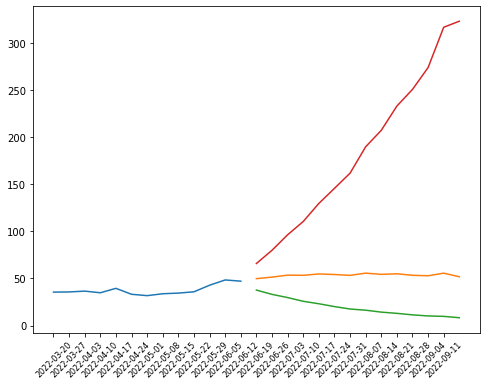

['options', ('2022-07-15', '2022-12-16')]
symbol: COP
sector: Energy
Index: SP500
vol_30d_2yr: 189274208.203125
Sector 1YMF: 3.6199951171875
1YMF: 3.6199951171875
risk trend factor: 0.1025203790799483
         beta currentRatio debtToEquity dividendRate dividendYield  \
COP  1.350272        1.513       38.088         1.92        0.0176   

    earningsGrowth       ebitda ebitdaMargins forwardPE freeCashflow  \
COP          4.853  25497999360       0.46444  7.529317  10752749568   

    grossMargins grossProfits heldPercentInstitutions       industry  \
COP      0.52295  22936000000                 0.81349  Oil & Gas E&P   

        marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
COP  121247997952       19983998976          0.33401      0.2348     0.48   

    priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
COP    2.463471                     2.208525       0.23417      1.287   

    returnOnAssets returnOnEquity revenueGrowth revenuePerShare  s

Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  93.739998  99.652102  112.199365  124.746628  104.355397   

             90dSDev  90d_lower   90d_upper  
2022-06-17  7.447422  89.460553  119.250241

volume_factor   latest_p       vol_30d_2yr   pct_2yr      adf    hurst
COP       0.95084  93.739998  189274208.203125  0.685759  0.80033  0.48084

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


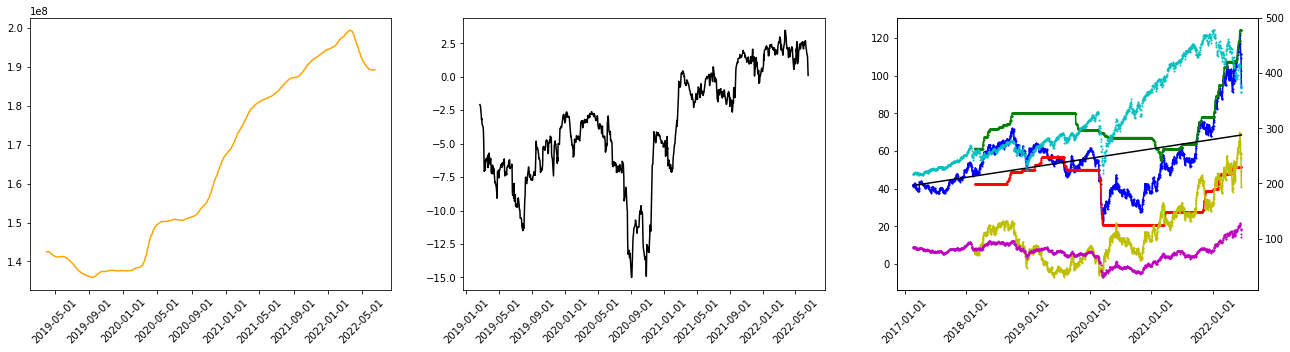

ets next 13 weeks
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 131.8588036807157 147.39173844312845
test cv mean error, stdev (10 folds): 144.32990311944945 148.9494774888766
sell date: 2022-09-11
expected return: 0.39963937496998936
discounted return: 0.003963299228999961
quarter return: 1.4389344529812573


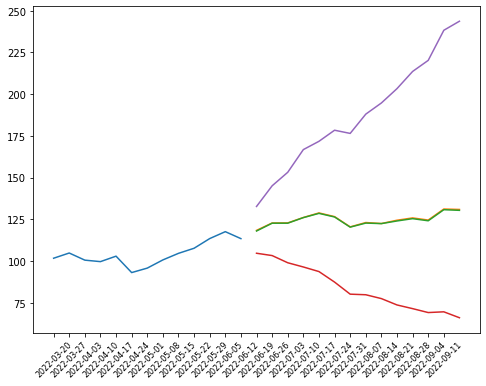

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           9.71
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       7.68
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             34.92
highestControversy                       2
esgPerformance                    OUT_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     55.68  56.839295  65.607143  74.374991  61.382222  4.693201   

            90d_lower  90d_upper  
2022-06-17  51.995819  70.768625

volume_factor latest_p       vol_30d_2yr  pct_2yr       adf     hurst
OXY      1.190976    55.68  498984476.953125  0.71978  0.690434  0.542013

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


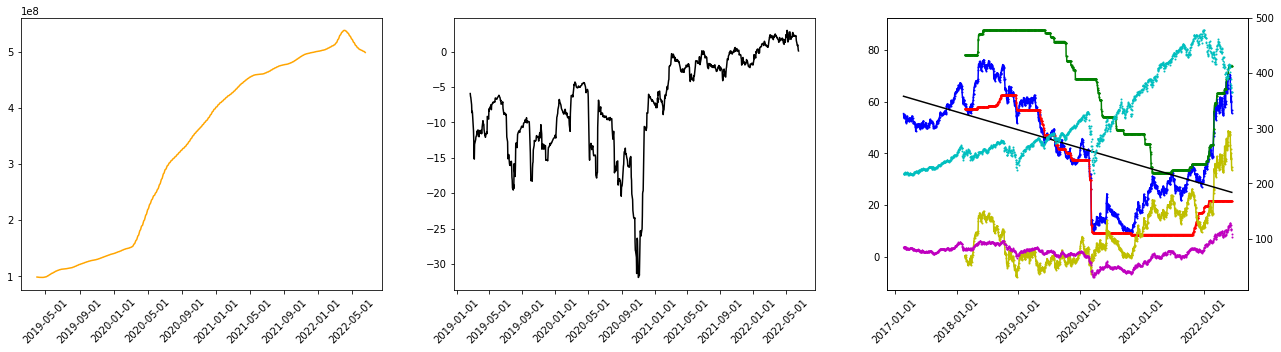

ets next 13 weeks
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 52.33362728746343 43.44383537157274
test cv mean error, stdev (10 folds): 56.28436553093534 43.63956757445321
sell date: 2022-09-18
expected return: 0.4701404460424396
discounted return: 0.004197457989383091
quarter return: 1.470140446042453


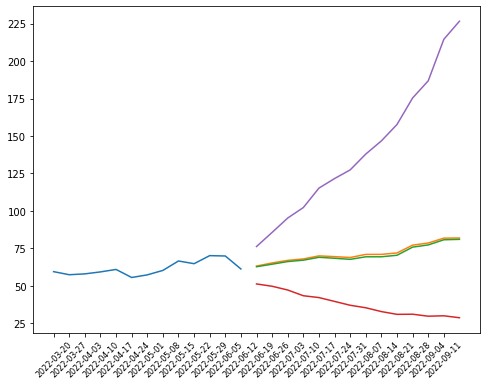

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                          12.04
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       6.88
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             43.53
highestControversy                       2
esgPerformance                   LEAD_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  93.139999  89.504506  94.30381  99.103114  92.664127  3.996399   

            90d_lower   90d_upper  
2022-06-17  84.671329  100.656925

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MGPI      1.204144  93.139999  2319158.789062  0.847493  0.649088  0.471114

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


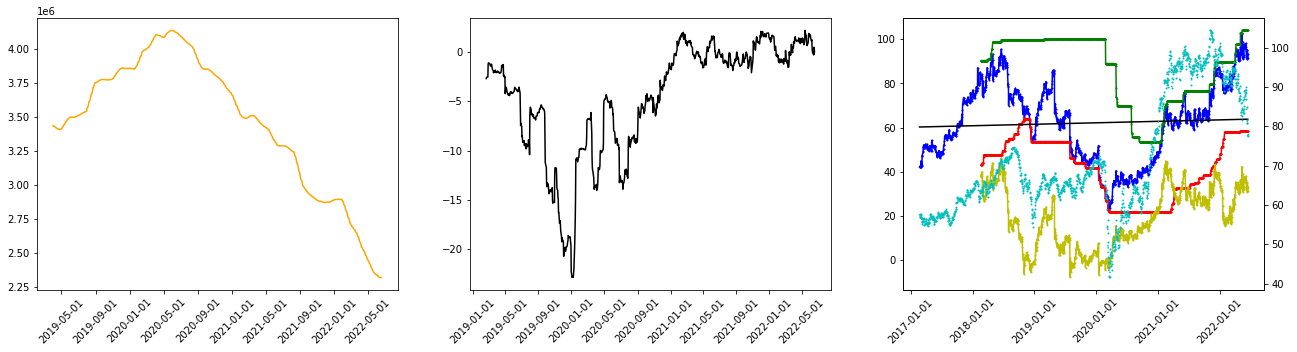

ets next 13 weeks
inner cv scores:
best model: [None, 'mul', True]
best inner cv score, sdev (11 folds): 110.11939012568004 125.9007193981329
test cv mean error, stdev (10 folds): 112.09217945846277 131.88358217270994
sell date: 2022-06-19
expected return: -0.019630121147322783
discounted return: -0.019630121147322765
quarter return: 0.16138986757441978


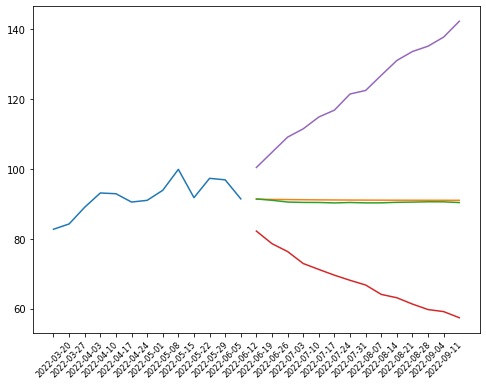

In [58]:
import statsmodels
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

client = Client('192.168.3.100:8786')

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

batchClearLimit = round(len(list__)/7)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
 
decision_metrics = []

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*spdr_indexes['Symbol'].values,*vanguard_sectors['Symbol'].values,"""
for s in list__:

    #for s in ['CEIX']:
    msize = 2
    date_form = DateFormatter("%Y-%m-%d")

    metrics_df_ = pd.DataFrame(pd.DataFrame(screener.loc[s].dropna()).T[['volume_factor','latest_p','vol_30d_2yr','pct_2yr','adf','hurst']])

    subset=prices[prices['Symbol']==s]

    dates = []
    for t in subset.index.values:
        d = pd.Timestamp(t).strftime('%Y-%m-%d')
        dates.append(d)
        dto = datetime.strptime(d, '%Y-%m-%d').date()

    old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
    new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
    x = new_ordinal    

    lookup_index_ = []

    labels = list()
    print("symbol:",s)   

    try:
        symbol_sector = dict_sectors[sector_merged[sector_merged['Symbol']==s]['Sector'].values[0]]
        print("sector:",dict_sectors_reverse[symbol_sector])
    except:
        if(symbol_sector=='error'):
            if(np.sum([vanguard_sectors['Symbol'].values==s])):
                symbol_sector = s
                print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
    if(symbol_sector=='error'):
        if(np.sum([vanguard_sectors['Symbol'].values==s])):
            symbol_sector = s
            print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
            print("sector:",'error')

    symbol_index = temp_sm.loc[s]['index_Symbol']

    try:
        matched_index_name = spdr_indexes.iloc[np.where(spdr_indexes['Symbol'].values==s)].index[0]
    except:
        try:
            matched_index_name = temp_sm.loc[s]['index']
        except:
            matched_index_name = "none"

    print("Index:",matched_index_name)

    print("vol_30d_2yr:",screener.iloc[np.where(screener.index==s)]['vol_30d_2yr'][0])
    #print("1YMF:",subset['1YMF'].values[-1])
    print("Sector 1YMF:",screener[screener.index==s]['1YMF'][0])
    print("1YMF:",screener.iloc[np.where(screener.index==s)]['1YMF'][0])
    print("risk trend factor:",screener.iloc[np.where(screener.index==s)]['risk_trend_factor'][0])

    temp = pd.DataFrame(stock_fundamentals.loc[s])
    print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

    last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices[prices['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

    bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
    bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
    bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2

    bbands.index = [last_date]
    display(bbands)

    display(metrics_df_)

    mean_revert_flag = False

    if(metrics_df_['adf'][0]<.05):
        print("ADFuller H0 rejected @ .05, Mean Reverting TS")
        if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
            colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True
        if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
            colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True    

    l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', '30d_vol_2yr','risk_trend_factor/linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

    r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

    display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])        

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(22,5))
    ax1.plot(subset['30d_vol_2yr'],color='orange')
    ax1.set_xticklabels(subset[['30d_vol_2yr']].dropna().index, rotation = 45)

    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)


    ax1.xaxis.set_major_formatter(date_form)

    #plt.title('30d_vol_2yr')
    ax2.plot(subset['risk_trend_factor'],color='black')
    ax2.set_xticklabels(subset[['risk_trend_factor']].dropna().index, rotation = 45)

    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)

    ax2.xaxis.set_major_formatter(date_form)
    #plt.title('risk_trend_factor')

    #fig, ax1 = plt.subplots()   

    ax4 = ax3.twinx()

    if(symbol_sector=='error'):
        pass
    else:
        if(np.sum(vanguard_sectors['Symbol'].values==s)>0):
            pass
        else:
            #print("sector",)
            #print("else_sector:",dict_sectors_reverse[s])            
            print("Sector 1YMF:",screener[screener.index==symbol_sector]['1YMF'][0])
            print("Sector Volume Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['volume_factor'][0])
            print("Sector Risk Trend Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['risk_trend_factor'][0])
            ax4.plot(x, (prices[prices['Symbol']==symbol_sector]['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
            #ax2.plot(x, prices[prices['Symbol']==symbol_sector]['Adj Close'],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))        
            #plt.legend([temp_sm.loc[s]['Sector']])
            #labels_ax2.append(temp_sm.loc[s]['Sector'])
            #plt.show()

    if(str(temp_sm.loc[s]['index_Symbol'])!='nan'):
        if(temp_sm.loc[s]['index_Symbol']!='error'):
            #print(temp_sm.loc[s]['index_Symbol'])
            print("Index 1YMF:",screener[screener.index==temp_sm.loc[s]['index_Symbol']]['1YMF'][0])
            print("Index Volume Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['volume_factor'][0])
            print("Index Risk Trend Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['risk_trend_factor'][0])

            ax4.plot(x, prices[prices['Symbol']==temp_sm.loc[s]['index_Symbol']]['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
            #plt.plot()
            #plt.legend([temp_sm.loc[s]['index']])
            #labels_ax2.append(temp_sm.loc[s]['index'])
            #plt.show()

    y= subset['Adj Close']

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    mymodel = list(map(myfunc, x))

    ax3.plot(x, y,marker = '.',markersize=msize, color = 'b')
    ax3.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
    ax3.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
    #ax1.plot(x, subset['risk_trend_factor'],marker = '.',markersize=msize, color = 'orange')

    ax3.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')

    ax3.plot(x, mymodel, color = 'k')

    #for l in ['symbol','1yrMax','1yrMin','risk_trend_factor','supply_trend_1yr','linear']:
        #labels.append(l)

    l = matplotlib.dates.AutoDateLocator()
    f = matplotlib.dates.ConciseDateFormatter(l)    

    ax3.set_xticklabels(ax3.get_xticks(), rotation = 45)

    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax3.xaxis.set_major_locator(locator)
    ax3.xaxis.set_major_formatter(formatter)

    ax3.xaxis.set_major_formatter(date_form)
    plt.show()

    print("ets next 13 weeks")

    newDates = pd.date_range(end, (end + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W').map(lambda t: t.strftime('%Y-%m-%d'))

    data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W')

    if(np.where(np.array(list__)==s)[0][0]%batchClearLimit==0):        
        client.restart()

    cv_inner = TimeSeriesSplit(n_splits=11,test_size=13)

    #has to be different makeup than cv_inner because there is no randomization.  Recommend a number that isn't a divisor of cv_inner's n_splits to ensure training is mixed up and not aligned
    cv_outer = TimeSeriesSplit(n_splits=10,test_size=13)

    outer_results = []

    #sm.tsa.statespace.ExponentialSmoothing
    """
    flags = []
    seasonal_flags1 = ['add','mul',None]

    trend_flags2 = ['add','mul',None]

    damped__trend_flags3 = [True,False]

    for sf in seasonal_flags1:
        for dt_ in trend_flags2:
            if(dt_ is None):          
                for d_ in damped__trend_flags3:
                    flags.append([sf,dt_,d_])
    """

    flags = [['add', 'add', True],\
     ['add', 'add', False],\
     ['add', 'mul', True],\
     ['add', 'mul', False],\
     ['add', None],\
     ['mul', 'add', True],\
     ['mul', 'add', False],\
     ['mul', 'mul', True],\
     ['mul', 'mul', False],\
     ['mul', None],\
     [None, 'add', True],\
     [None, 'add', False],\
     [None, 'mul', True],\
     [None, 'mul', False],\
     [None, None]]

    #print(flags)

    #flags = [['T','T'],['T','F'],['F','F'],['F','T']]       

    rmse_inner_flags = []

    for flag in flags:

        npa = []

        for trainv_ix, test_ix in cv_inner.split(data.index):

            npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,flag])

        future = client.map(evaluate_ets, npa)        

        rmses_inner = []
        #flag_order = []
        #my intent was to capture future objects vs results and this gave me results
        for f in as_completed(future):
            #exclude errors
            if(f.status=="error"):
                #pass
                #this causes errors with [flag,rmse] being passed by evaluate_ets
                rmses_inner.append([np.nan])
            else:
                rmses_inner.append(f.result())

        #I don't want to keep track of flag here
        #flag_order = [r[0] for r in results_rmses].copy()

        rmse_ = [r[1] for r in rmses_inner].copy()
        #print(rmse_)
        #print(flag)
        rmse_inner_flags.append([flag,np.nanmean(rmse_),np.nanstd(rmse_)])

    #rmse_scores = []
    #flag_rmses = []

    #for fn_ in range(0,len(flags)):
        #flag_ = flags[fn_]
        #rmse_scores.append([flag_rmses[fn_],rmses[fn_][1]])

    print("inner cv scores:")
    inner_rmse_df = pd.DataFrame(rmse_inner_flags,columns=['flags','mean','std'])
    #print("inner cv scores:",[r[rmses)
    #print("inner cv sdevs:",sdevs)

    scores = inner_rmse_df['mean'].values
    sdevs = inner_rmse_df['std'].values
    best_model = inner_rmse_df['flags'].values[np.argmin(scores)]

    print("best model:",best_model)
    print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

    npa = []

    for trainv_ix, test_ix in cv_outer.split(data.index):

        npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,best_model])

    future = client.map(evaluate_ets, npa)
    results_rmses_outer = []

    #my intent was to capture future objects vs results and this gave me results
    for f in as_completed(future):
        #exclude errors
        if(f.status=="error"):
            #pass
            results_rmses_outer.append([np.nan])
        else:
            results_rmses_outer.append(f.result()) 

    test_score_mean = np.nanmean([r[1] for r in results_rmses_outer])
    test_score_std = np.nanstd([r[1] for r in results_rmses_outer])

    #test_score = [np.nanmean(rmse_outer_df['mean'].values),np.nanstd(rmse_outer_df['mean'].values)]
    print("test cv mean error, stdev (10 folds):",test_score_mean,test_score_std)
    
    #final_model=ETSModel(np.log(data),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()    
    flag = best_model
    if(len(flag)==2):
        if(flag[1] is None):
            final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],trend=flag[1],dates=data.index).fit()
        else:
            final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],dates=data.index).fit()
    else:
        final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],damped_trend=flag[2],dates=data.index).fit()
        
    df_pred = np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())
    #df_conf = np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).pred_int(alpha = .05))
    #df_conf.columns = ['ci_lower','ci_upper']
    
    #final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=['add','mul','None'][0],seasonal_periods=52,trend=['add','mul','None'][0],damped_trend=['True','False'][0],dates=data.index).fit()
    #pred = final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d'))
    
    #final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame()
    
    #df_pred = np.exp(pred.summary_frame(alpha=0.05))
    #df_pred = np.exp(pred.summary(alpha=0.05))
    s_date = df_pred.index[np.argmax(df_pred['mean'].values)].strftime('%Y-%m-%d')
    
    print("sell date:",s_date)
    e_return = np.array((np.max(df_pred['mean'].values)-metrics_df_['latest_p'])/metrics_df_['latest_p'])[0]
    p_metrics = pd.DataFrame(df_pred.iloc[np.argmax(df_pred['mean'].values)]).T
    #c_metrics = pd.DataFrame(df_conf.iloc[np.argmax(df_pred['mean'].values)]).T
    #print(c_metrics)
    print("expected return:",e_return)
        
    days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
    discounted_return = (1+e_return)**(1/days_delta)-1
    qtr_return = (1+discounted_return)**92

    print("discounted return:",discounted_return)
    
    print("quarter return:",qtr_return)
    
    #used to help filter at the end, not sdevs is chosen based on min score
    decision_metrics.append([s,e_return,s_date,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]])
    
    plt.plot(data.tail(13))
    plt.plot(df_pred)
    #plt.plot(df_conf)
    plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
    plt.show()

    if(np.sum(np.array(fundamental_entries)==s)>0):
        loc = np.where(np.array(fundamental_entries)==s)[0][0]
        #print(fundamentals_quarterlies[loc[0]][0])
        #fundamentals_quarterlies[loc][1]
        for item in fundamentals_quarterlies[loc][1]:
            if(type(item[1]) == type(None)):
                pass
            else:
                if(len(item[1])>0):
                    #print(len(item[1]))
                    print(item)
client.close()    

In [59]:
decision_metrics_df = pd.DataFrame(decision_metrics,columns=['SYMBOL','exp_return','sell_date','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_rmse_n11','outer_cv_std_n11','mean_revert_flag','pi_lower','pi_upper'])
decision_metrics_df = decision_metrics_df.set_index('SYMBOL').sort_values(by='disc_rtn',ascending=False)
decision_metrics_df['price'] = screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['Sector'] = temp_sm['Sector'].loc[decision_metrics_df.index]
decision_metrics_df['Index'] = temp_sm['index'].loc[decision_metrics_df.index]
decision_metrics_df['error_price_ratio'] = decision_metrics_df['outer_cv_avg_rmse_n11']/screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['std_price_ratio'] = decision_metrics_df['outer_cv_std_n11']/screener['latest_p'].loc[decision_metrics_df.index]

In [60]:
display(decision_metrics_df.style.applymap(highlight_cells, color_if_false='yellow', color_if_true='#C6E2E9', 
                  subset=['error_price_ratio','mean_revert_flag','std_price_ratio'], threshold_=.75))